In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# data partition
from sklearn.model_selection import train_test_split

# Imputing
from sklearn.impute import KNNImputer

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler


# embedded methods
from sklearn.linear_model import LassoCV

# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Modelling and report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# Imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# Exploration

In [2]:
data_train_val = pd.read_csv('train.csv')

In [3]:
data_test = pd.read_csv('test.csv')

In [4]:
data_train_val_multi = pd.read_csv('train.csv')

In [5]:
data_test_multi = pd.read_csv('test.csv')

In [6]:
# data_train_val.set_index('encounter_id', inplace = True)
# data_test.set_index('encounter_id', inplace = True)

In [7]:
# replace ? with nan
data_train_val.replace('?', np.nan, inplace = True)
data_test.replace('?', np.nan, inplace = True)

In [8]:
# replace ? with nan
data_train_val_multi.replace('?', np.nan, inplace = True)
data_test_multi.replace('?', np.nan, inplace = True)

In [9]:
# train and validation set
data_train, data_val = train_test_split(data_train_val, test_size = 0.2, random_state = 42, stratify=data_train_val['readmitted_binary'])

In [10]:
data_train_multi = data_train.copy()
data_val_multi = data_val.copy()

In [11]:
# Checking for missing values and their proportions in the dataset
def missing_values(data):
    missing = pd.DataFrame(data.isnull().sum())
    missing.columns = ['count']
    missing['percentage'] = (missing['count']/len(data))*100
    missing.sort_values(by = 'percentage', ascending = False, inplace = True)
    return missing

In [12]:
# print missing values for each dataset and since binary and multiclass will have basically the same we only print for binary
print('Missing values in train set')
print(missing_values(data_train))
print('Missing values in validation set')
print(missing_values(data_val))
print('Missing values in test set')
print(missing_values(data_test))

Missing values in train set
                                       count  percentage
weight                                 55206   96.873026
glucose_test_result                    54023   94.797150
a1c_test_result                        47444   83.252615
medical_specialty                      27881   48.924335
payer_code                             22604   39.664491
race                                    4006    7.029550
admission_source                        3816    6.696147
admission_type                          2982    5.232681
age                                     2811    4.932617
discharge_disposition                   2063    3.620060
additional_diagnosis                     822    1.442409
secondary_diagnosis                      213    0.373763
primary_diagnosis                         13    0.022812
number_of_medications                      0    0.000000
prescribed_diabetes_meds                   0    0.000000
number_diagnoses                           0    0.000000
med

In [13]:
# replace readmitted binary and multiclass with numerical values
data_train['readmitted_binary'] = data_train['readmitted_binary'].replace({'Yes':1, 'No':0})
data_val['readmitted_binary'] = data_val['readmitted_binary'].replace({'Yes':1, 'No':0})

data_train['readmitted_multiclass'] = data_train['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})
data_val['readmitted_multiclass'] = data_val['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})


In [14]:
# replace readmitted binary and multiclass with numerical values
data_train_multi['readmitted_binary'] = data_train_multi['readmitted_binary'].replace({'Yes':1, 'No':0})
data_val_multi['readmitted_binary'] = data_val_multi['readmitted_binary'].replace({'Yes':1, 'No':0})

data_train_multi['readmitted_multiclass'] = data_train_multi['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})
data_val_multi['readmitted_multiclass'] = data_val_multi['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})

# PreProcessing

## Functions

In [15]:
def plot_categorical_distribution(df, col):
    """
    Plots the percentage and distribution of a categorical variable against 
    both 'readmitted_binary' and 'readmitted_multiclass', with increased figure size for better visibility.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    col (str): The name of the categorical column to plot.
    """
    target_cols = ['readmitted_binary', 'readmitted_multiclass']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))  # Increased figure size for better visibility

    fig.suptitle(f'Distribution and Percentage of {col} for Readmission Types', fontsize=16)

    for i, target_col in enumerate(target_cols):
        # Plotting the percentage distribution
        ax = axes[0, i]
        (df.groupby([col, target_col]).size().groupby(level=0)
         .apply(lambda x: 100 * x / x.sum()).unstack()
         .plot(kind='bar', stacked=True, ax=ax))
        ax.set_title(f'Percentage of {target_col} for {col}')
        ax.set_ylabel('Percentage')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)  # Hides x-axis labels for the upper plots

        # Plotting the count distribution
        ax = axes[1, i]
        (df.groupby([col, target_col]).size().unstack()
         .plot(kind='bar', stacked=True, ax=ax))
        ax.set_title(f'Distribution of {target_col} for {col}')
        ax.set_ylabel('Count')
        ax.set_xlabel(col)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [16]:
def plot_continuous_distribution(df, feature_name):
    """
    Plots the distribution and boxplot of a continuous feature with respect to both 
    'readmitted_binary' and 'readmitted_multiclass' target variables using a vibrant color palette.

    Parameters:
    df (DataFrame): The pandas DataFrame containing the data.
    feature_name (str): The name of the continuous feature.
    """
    target_cols = ['readmitted_binary', 'readmitted_multiclass']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex='col', sharey='row')
    fig.suptitle(f'Distribution and Boxplot of {feature_name} for Readmission Types', fontsize=16)

    # Vibrant color palette
    palette = sns.color_palette("bright")

    for i, target_col in enumerate(target_cols):
        # Create a KDE plot in the first row
        sns.kdeplot(data=df, x=feature_name, hue=target_col, fill=True, palette=palette, ax=axes[0, i])
        axes[0, i].set_title(f'Distribution of {feature_name} by {target_col}')
        axes[0, i].set_xlabel(feature_name)
        axes[0, i].set_ylabel('Density')

        # Create a boxplot in the second row
        sns.boxplot(data=df, x=target_col, y=feature_name, palette=palette, ax=axes[1, i])
        axes[1, i].set_title(f'Boxplot of {feature_name} by {target_col}')
        axes[1, i].set_xlabel(target_col)
        axes[1, i].set_ylabel(feature_name)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [17]:
def cap_outliers(df, feature, percentile_cap):
    cap_value = df[feature].quantile(percentile_cap)
    df[feature] = df[feature].clip(upper=cap_value)
    return cap_value

## Columns

#### patient_id

In [18]:
# Calculate admission counts for train data
train_admission_counts = data_train.groupby('patient_id')['patient_id'].count().to_dict()

# Define a function to calculate admission count
def calculate_admission_count(row, dataset_type):
    patient_id = row['patient_id']
    encounter_id = row['encounter_id']

    # Count in train_data
    train_count = train_admission_counts.get(patient_id, 0)

    if dataset_type == 'train':
        return train_count
    elif dataset_type == 'val':
        val_count = data_val[data_val['patient_id'] == patient_id].shape[0]
        return train_count + val_count
    elif dataset_type == 'test':
        test_count = data_test[data_test['patient_id'] == patient_id].shape[0]
        return train_count + test_count

# Apply the function to each dataset
data_train['admission_count'] = data_train.apply(lambda row: calculate_admission_count(row, 'train'), axis=1)
data_val['admission_count'] = data_val.apply(lambda row: calculate_admission_count(row, 'val'), axis=1)
data_test['admission_count'] = data_test.apply(lambda row: calculate_admission_count(row, 'test'), axis=1)

# Apply the function to each dataset and we can use the same function since we are using copy of the data
data_train_multi['admission_count'] = data_train_multi.apply(lambda row: calculate_admission_count(row, 'train'), axis=1)
data_val_multi['admission_count'] = data_val_multi.apply(lambda row: calculate_admission_count(row, 'val'), axis=1)
data_test_multi['admission_count'] = data_test_multi.apply(lambda row: calculate_admission_count(row, 'test'), axis=1)

In [19]:
# # Define a function to calculate admission count
# def calculate_admission_count(row, dataset, dataset_type):
#     patient_id = row['patient_id']

#     # Count in the specified dataset
#     train_count = dataset.groupby('patient_id')['patient_id'].count().to_dict().get(patient_id, 0)

#     if dataset_type == 'train':
#         return train_count
#     elif dataset_type == 'val':
#         val_count = data_val[data_val['patient_id'] == patient_id].shape[0]
#         return train_count + val_count
#     elif dataset_type == 'test':
#         test_count = data_test[data_test['patient_id'] == patient_id].shape[0]
#         return train_count + test_count

# # Apply the function to each dataset
# data_train['admission_count'] = data_train.apply(lambda row: calculate_admission_count(row, data_train, 'train'), axis=1)
# data_val['admission_count'] = data_val.apply(lambda row: calculate_admission_count(row, data_train, 'val'), axis=1)
# data_test['admission_count'] = data_test.apply(lambda row: calculate_admission_count(row, data_train, 'test'), axis=1)

# data_train_multi['admission_count'] = data_train_multi.apply(lambda row: calculate_admission_count(row, data_train_multi, 'train'), axis=1)
# data_val_multi['admission_count'] = data_val_multi.apply(lambda row: calculate_admission_count(row, data_train_multi, 'val'), axis=1)
# data_test_multi['admission_count'] = data_test_multi.apply(lambda row: calculate_admission_count(row, data_train_multi, 'test'), axis=1)

In [20]:
# drop patient_id
# data_train.drop('patient_id', axis = 1, inplace = True)
# data_val.drop('patient_id', axis = 1, inplace = True)
# data_test.drop('patient_id', axis = 1, inplace = True)

In [21]:
# we will now set the index to encounter_id
data_train.set_index('encounter_id', inplace = True)
data_val.set_index('encounter_id', inplace = True)
data_test.set_index('encounter_id', inplace = True)

In [22]:
data_train_multi.set_index('encounter_id', inplace = True)
data_val_multi.set_index('encounter_id', inplace = True)
data_test_multi.set_index('encounter_id', inplace = True)

#### country

In [23]:
# delete country column since there is only one country
data_train.drop(['country'], axis=1, inplace=True)
data_val.drop(['country'], axis=1, inplace=True)
data_test.drop(['country'], axis=1, inplace=True)

In [24]:
# delete country column since there is only one country
data_train_multi.drop(['country'], axis=1, inplace=True)
data_val_multi.drop(['country'], axis=1, inplace=True)
data_test_multi.drop(['country'], axis=1, inplace=True)

#### race

In [25]:
def impute_missing_race(data_train, data_val, data_test):
    # Dictionary for most common value for each patient
    race_dict = data_train.groupby('patient_id')['race'].agg(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else None).to_dict()

    # Function inside to impute missing values in 'race'
    def impute_race(row):
        if pd.isna(row['race']):
            return race_dict.get(row['patient_id'], row['race'])
        return row['race']

    # Apply the impute_race function to each dataset
    data_train['race'] = data_train.apply(impute_race, axis=1)
    data_val['race'] = data_val.apply(impute_race, axis=1)
    data_test['race'] = data_test.apply(impute_race, axis=1)

    return data_train, data_val, data_test

# Apply the function to binary classification datasets
data_train, data_val, data_test = impute_missing_race(data_train, data_val, data_test)

# Apply the same function to multiclass classification datasets
data_train_multi, data_val_multi, data_test_multi = impute_missing_race(data_train_multi, data_val_multi, data_test_multi)

In [26]:
# Replace remaining missing values with new category 'Unknown' as the other imputation techniques might not be meaningful or giving a bias to the model
data_train['race'] = data_train['race'].fillna('Unknown')
data_val['race'] = data_val['race'].fillna('Unknown')
data_test['race'] = data_test['race'].fillna('Unknown')

In [27]:
data_train_multi['race'] = data_train_multi['race'].fillna('Unknown')
data_val_multi['race'] = data_val_multi['race'].fillna('Unknown')
data_test_multi['race'] = data_test_multi['race'].fillna('Unknown')

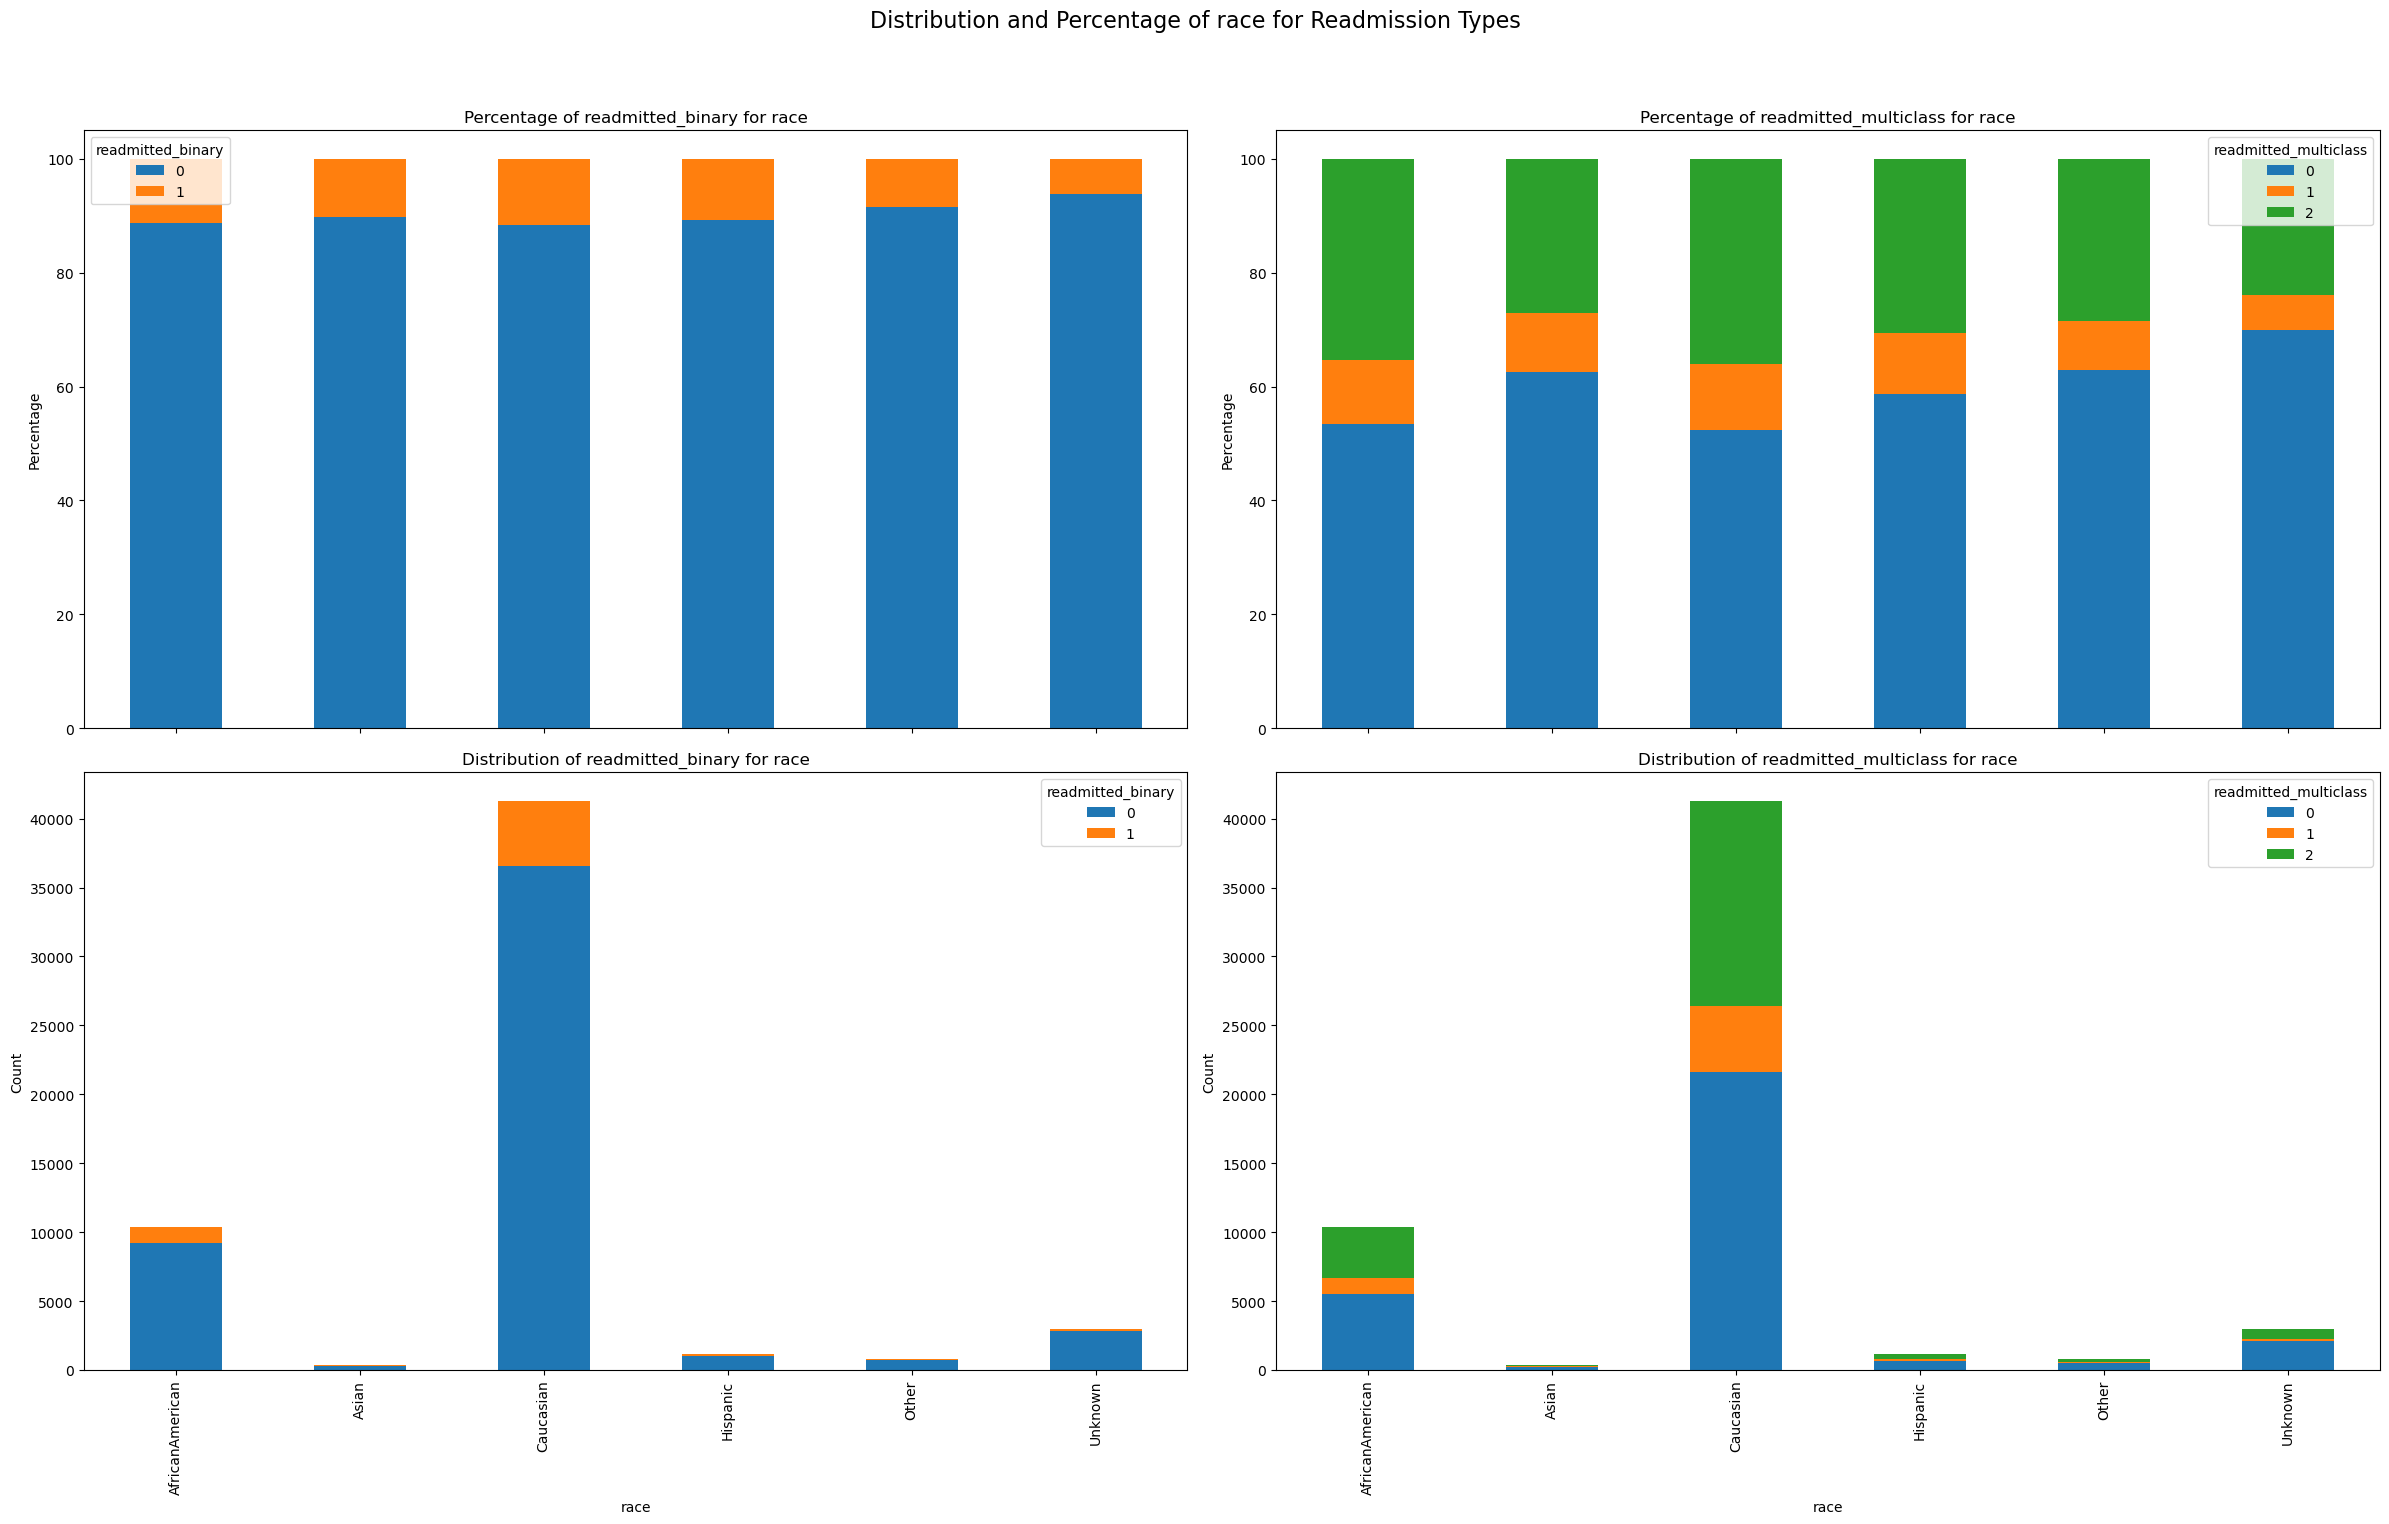

In [28]:
plot_categorical_distribution(data_train, 'race')

#### gender

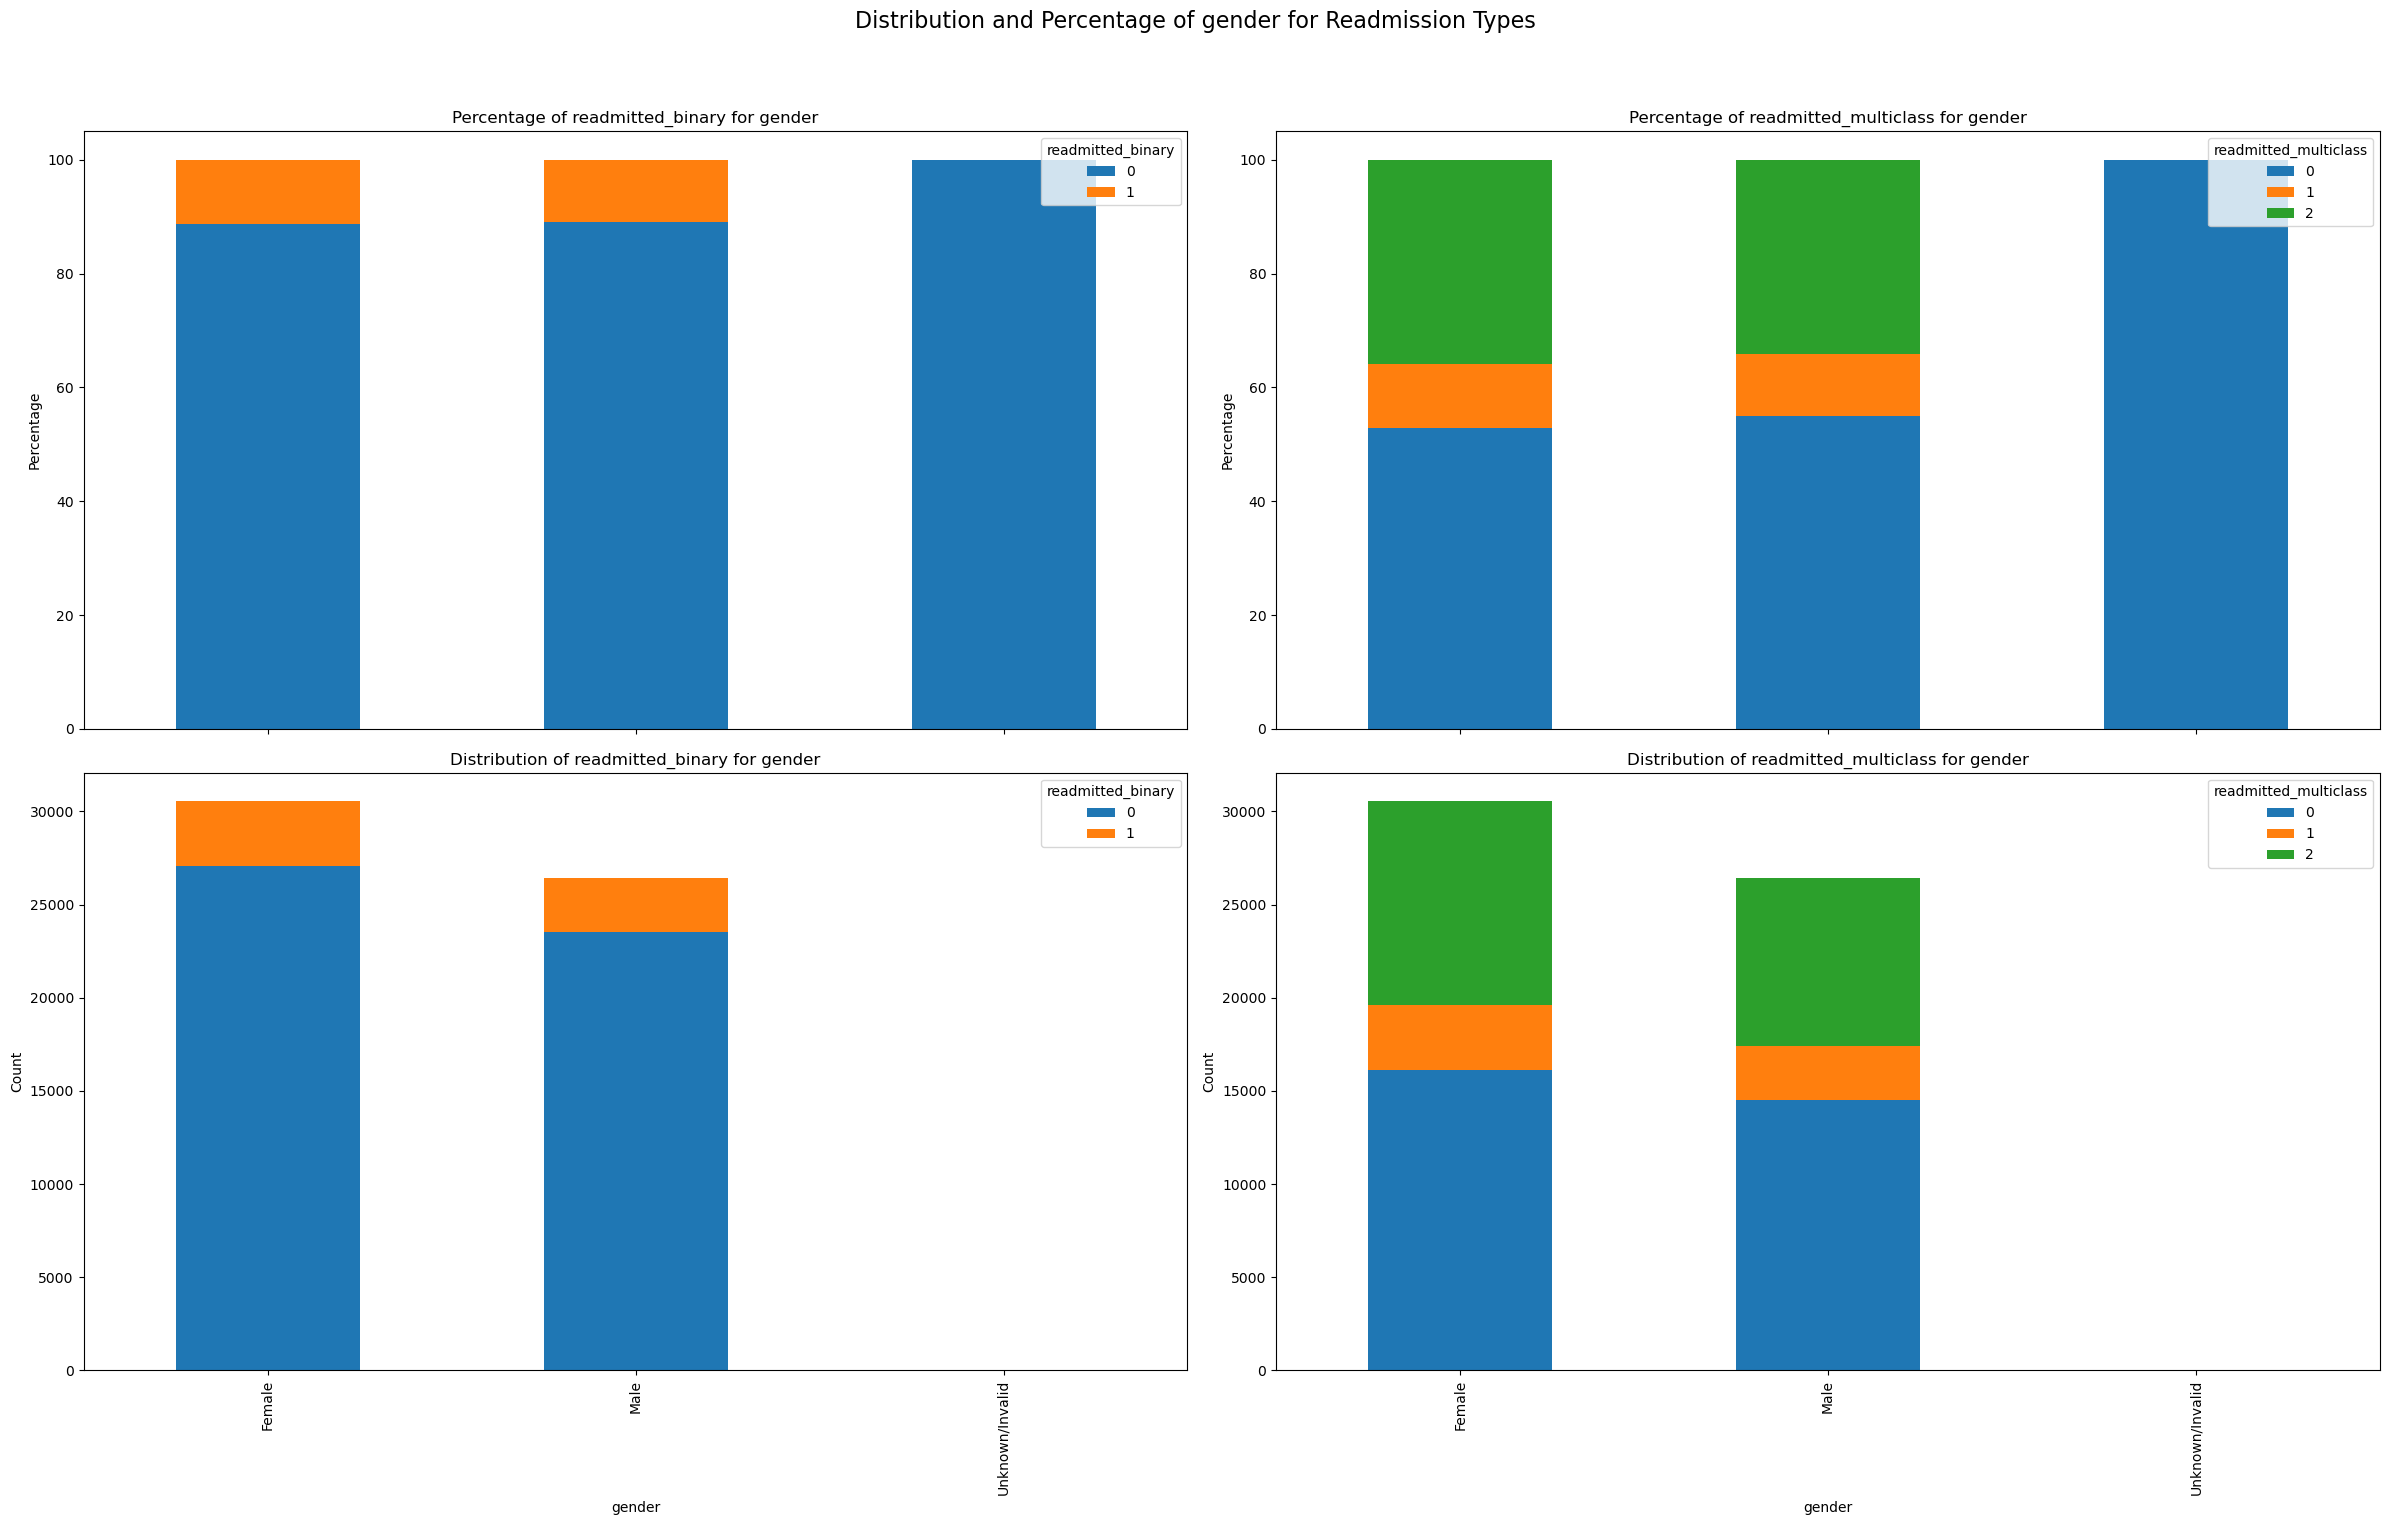

In [29]:
plot_categorical_distribution(data_train, 'gender')

In [30]:
# replace the few 'Unknown/Invalid' values with the mode in data_train
mode_gender_train = data_train['gender'].mode()[0]
data_train['gender'] = data_train['gender'].replace('Unknown/Invalid', mode_gender_train)

# Replace 'Unknown/Invalid' with the mode in data_val and data_test
data_val['gender'] = data_val['gender'].replace('Unknown/Invalid', mode_gender_train)
data_test['gender'] = data_test['gender'].replace('Unknown/Invalid', mode_gender_train)

In [31]:
# Replace 'Unknown/Invalid' with the mode in data_val and data_test
data_train_multi['gender'] = data_train_multi['gender'].replace('Unknown/Invalid', mode_gender_train)
data_val_multi['gender'] = data_val_multi['gender'].replace('Unknown/Invalid', mode_gender_train)
data_test_multi['gender'] = data_test_multi['gender'].replace('Unknown/Invalid', mode_gender_train)

In [32]:
# make gender column numeric
data_train['gender'] = data_train['gender'].map({'Male': 1, 'Female': 0})
data_val['gender'] = data_val['gender'].map({'Male': 1, 'Female': 0})
data_test['gender'] = data_test['gender'].map({'Male': 1, 'Female': 0})

In [33]:
data_train_multi['gender'] = data_train_multi['gender'].map({'Male': 1, 'Female': 0})
data_val_multi['gender'] = data_val_multi['gender'].map({'Male': 1, 'Female': 0})
data_test_multi['gender'] = data_test_multi['gender'].map({'Male': 1, 'Female': 0})

#### age

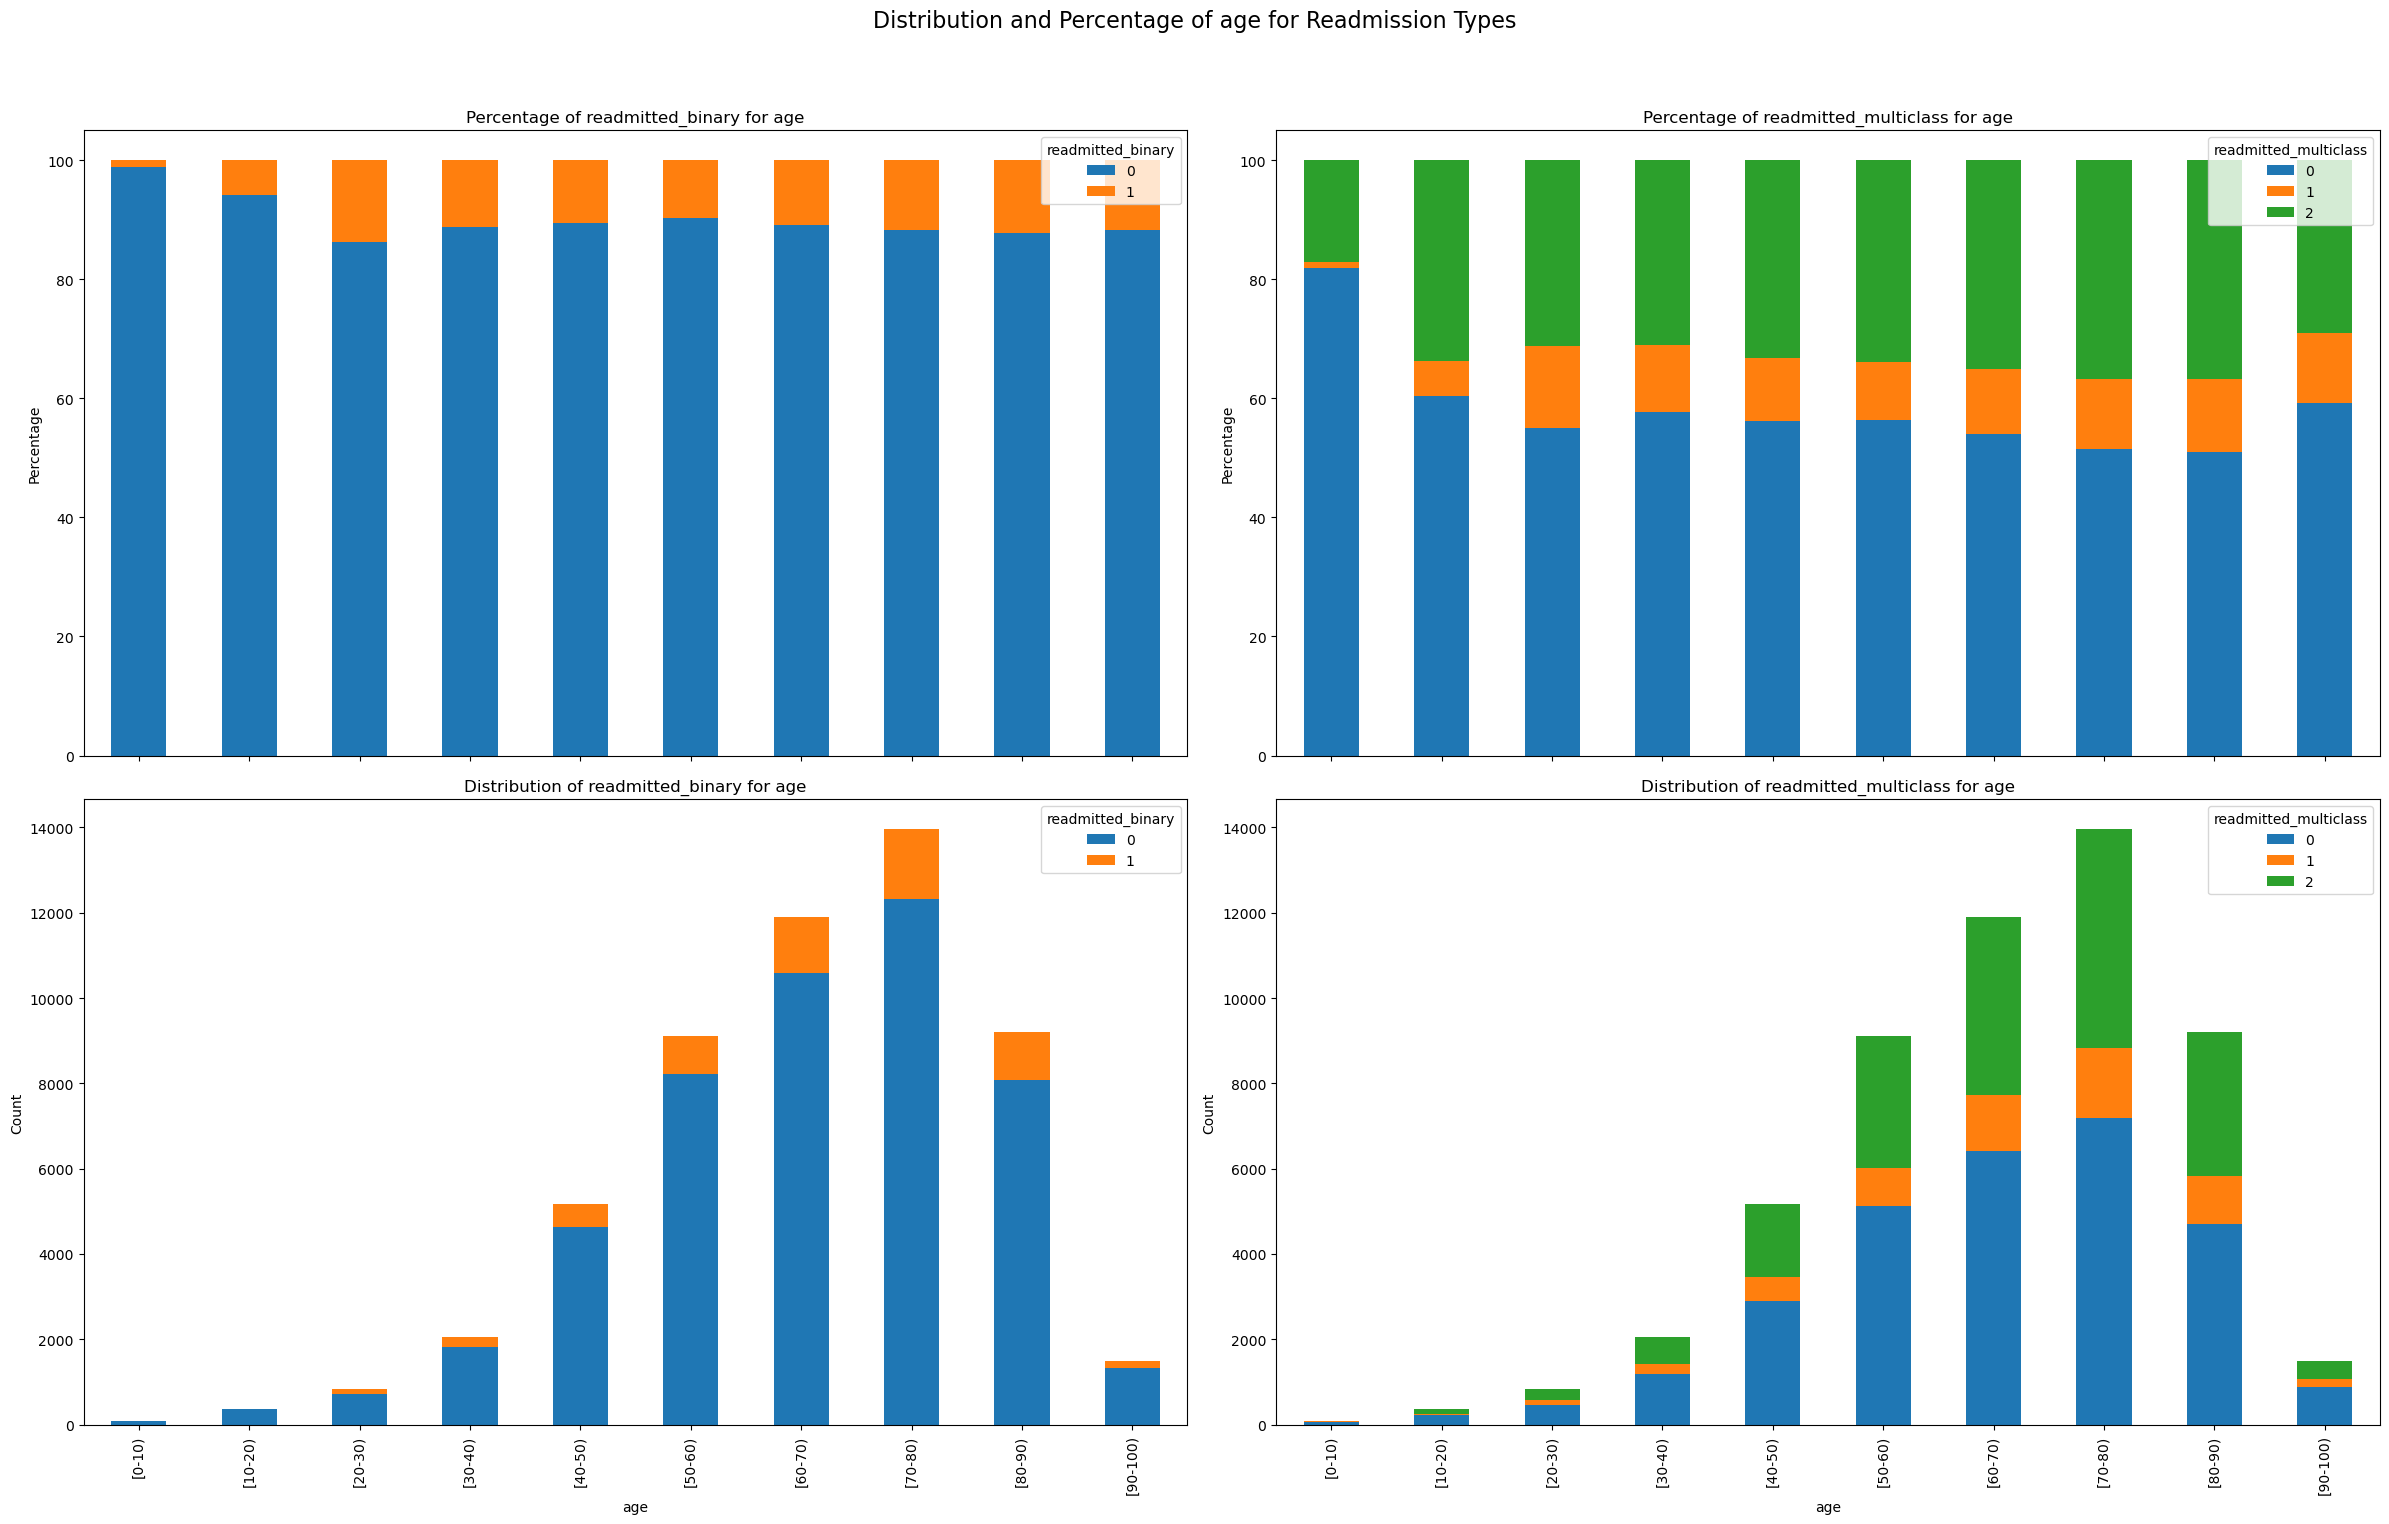

In [34]:
plot_categorical_distribution(data_train, 'age')

In [35]:
## Encode age seperate

# Define the mapping
age_mapping = {
    '[0-10)': 1,
    '[10-20)': 2,
    '[20-30)': 3,
    '[30-40)': 4,
    '[40-50)': 5,
    '[50-60)': 6,
    '[60-70)': 7,
    '[70-80)': 8,
    '[80-90)': 9,
    '[90-100)': 10
}

# Apply the mapping to the 'age' column
data_train['age'] = data_train['age'].map(age_mapping)
data_val['age'] = data_val['age'].map(age_mapping)
data_test['age'] = data_test['age'].map(age_mapping)

In [36]:
data_train_multi['age'] = data_train_multi['age'].map(age_mapping)
data_val_multi['age'] = data_val_multi['age'].map(age_mapping)
data_test_multi['age'] = data_test_multi['age'].map(age_mapping)

#### weight

In [37]:
# drop weight column since it has too many missing values
data_train.drop(['weight'], axis=1, inplace=True)
data_val.drop(['weight'], axis=1, inplace=True)
data_test.drop(['weight'], axis=1, inplace=True)

In [38]:
data_train_multi.drop(['weight'], axis=1, inplace=True)
data_val_multi.drop(['weight'], axis=1, inplace=True)
data_test_multi.drop(['weight'], axis=1, inplace=True)

#### payer_code

In [39]:
# fill nan with 'Missing' in data_train
data_train['payer_code'] = data_train['payer_code'].fillna('Missing')

# fill nan with 'Missing' in data_val and data_test
data_val['payer_code'] = data_val['payer_code'].fillna('Missing')
data_test['payer_code'] = data_test['payer_code'].fillna('Missing')


In [40]:
data_train_multi['payer_code'] = data_train_multi['payer_code'].fillna('Missing')
data_val_multi['payer_code'] = data_val_multi['payer_code'].fillna('Missing')
data_test_multi['payer_code'] = data_test_multi['payer_code'].fillna('Missing')

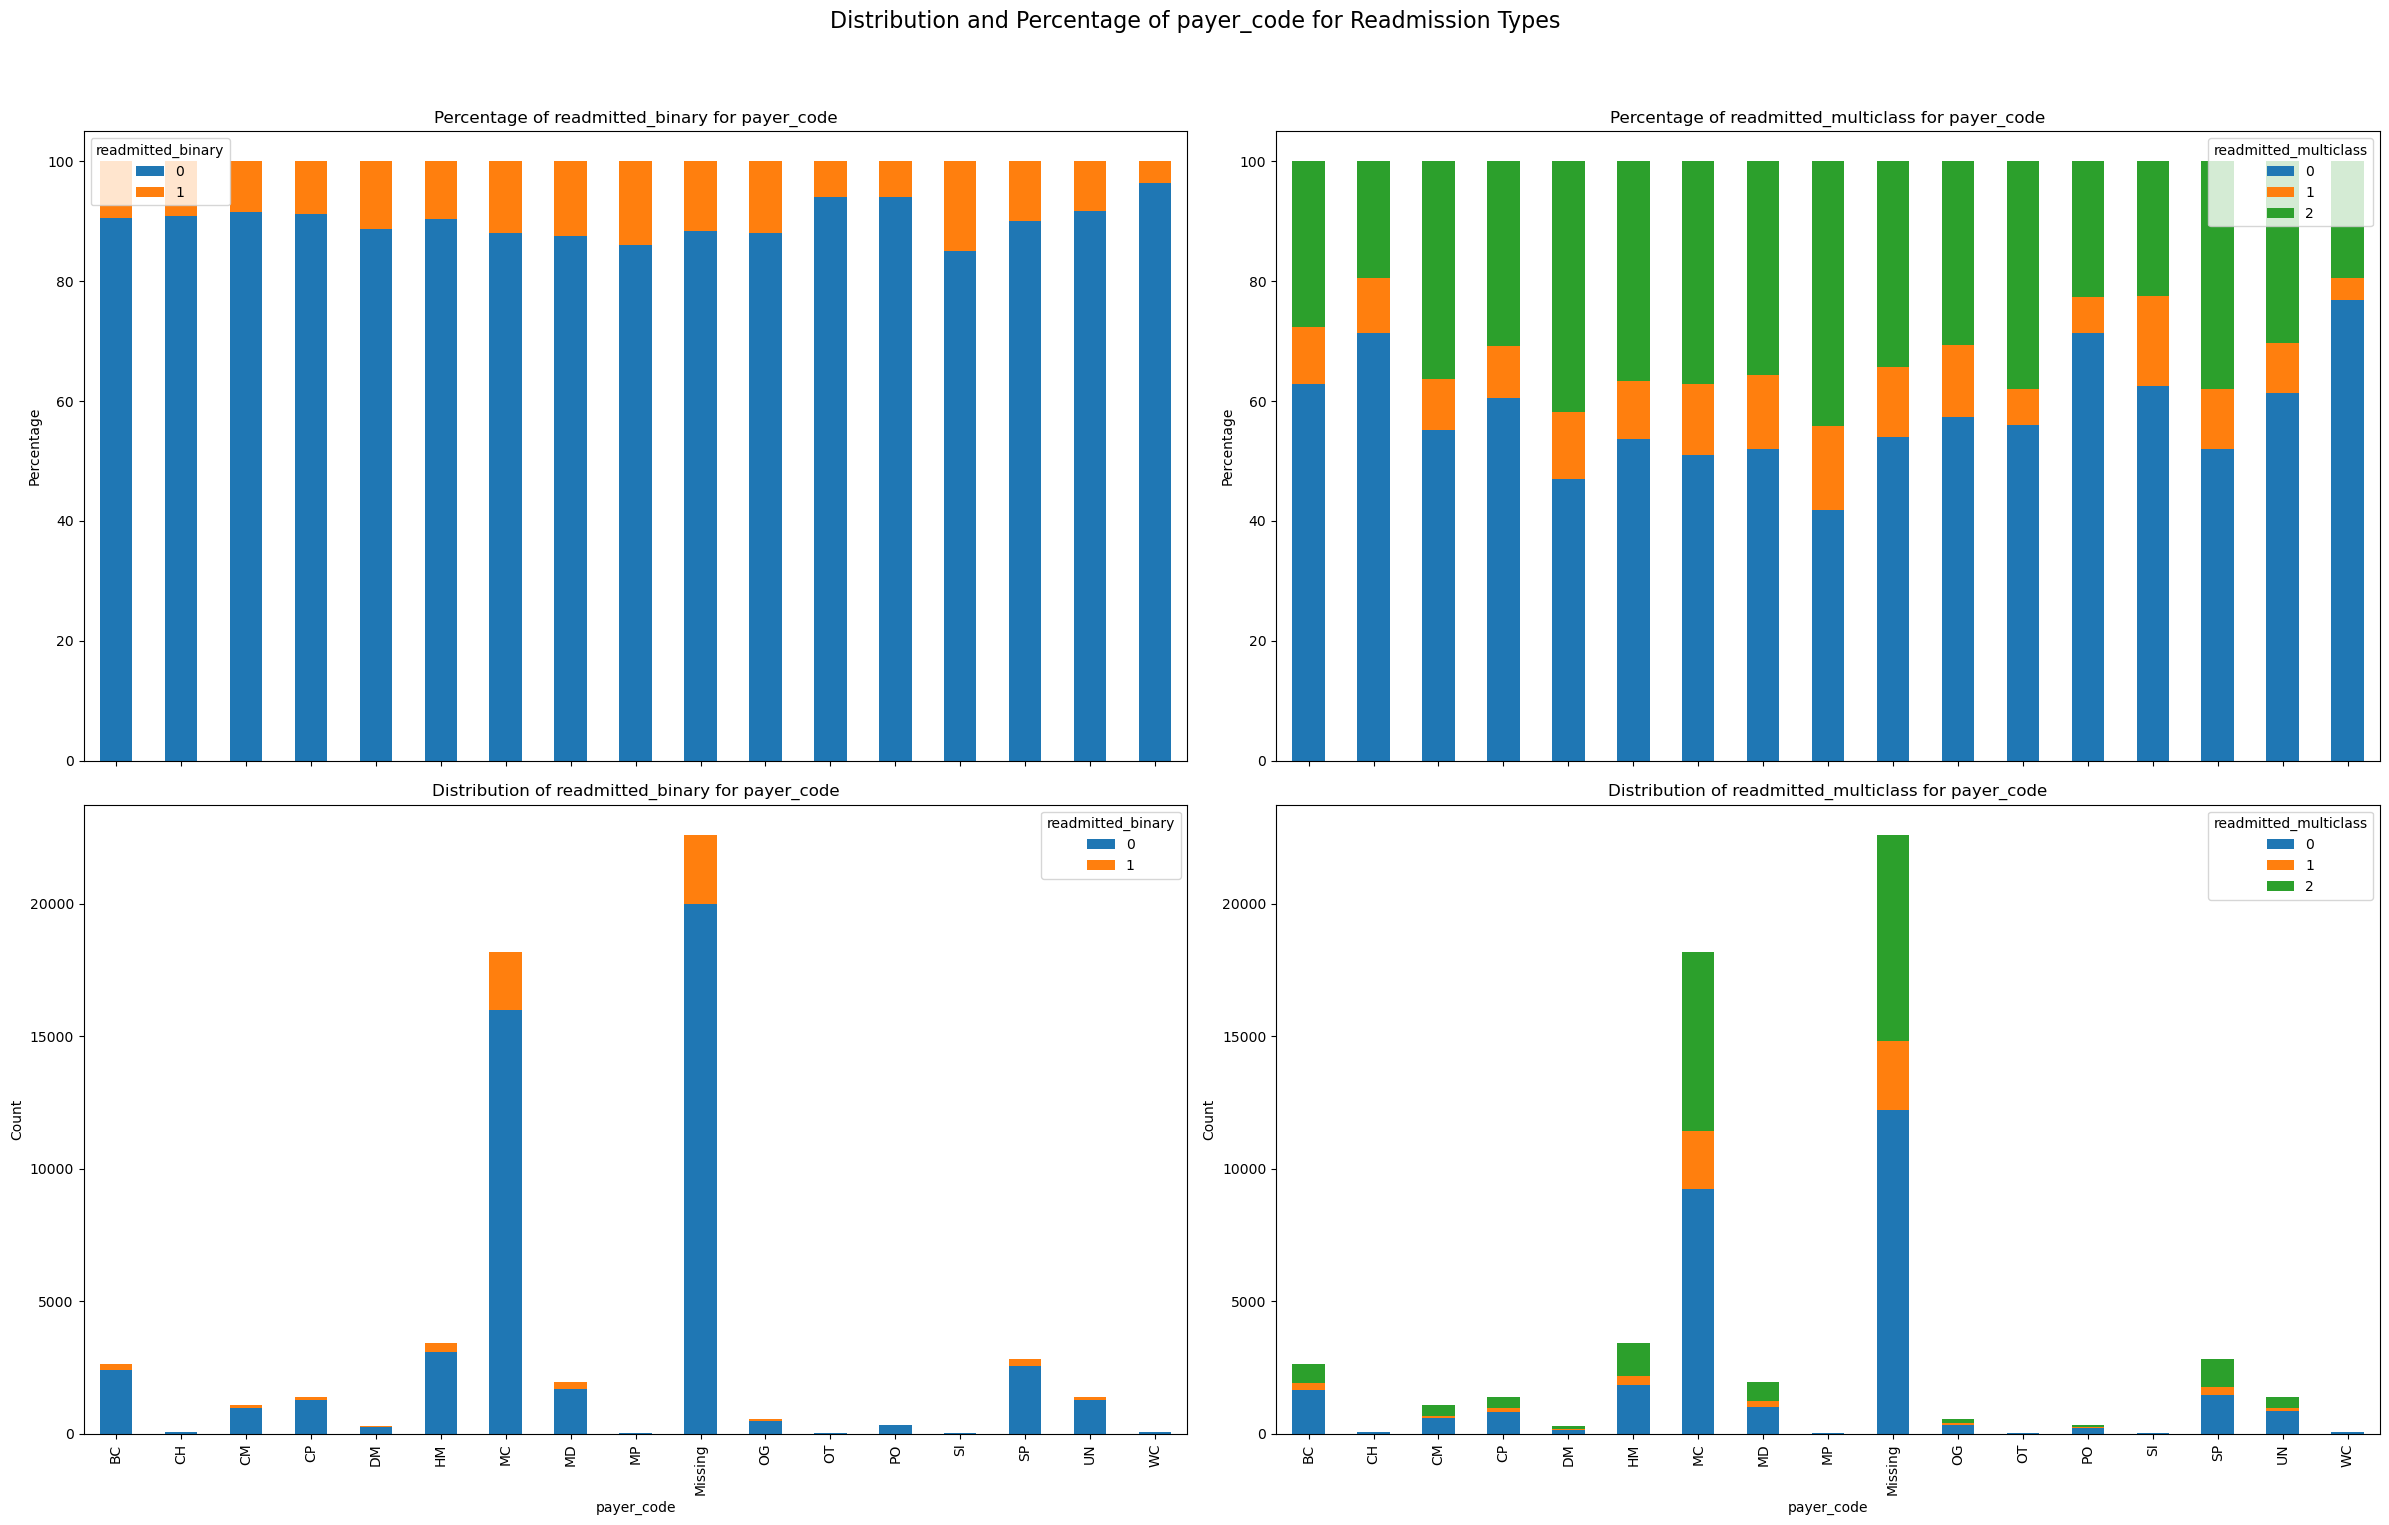

In [41]:
plot_categorical_distribution(data_train, 'payer_code')

#### outpatient_visits_in_previous_year

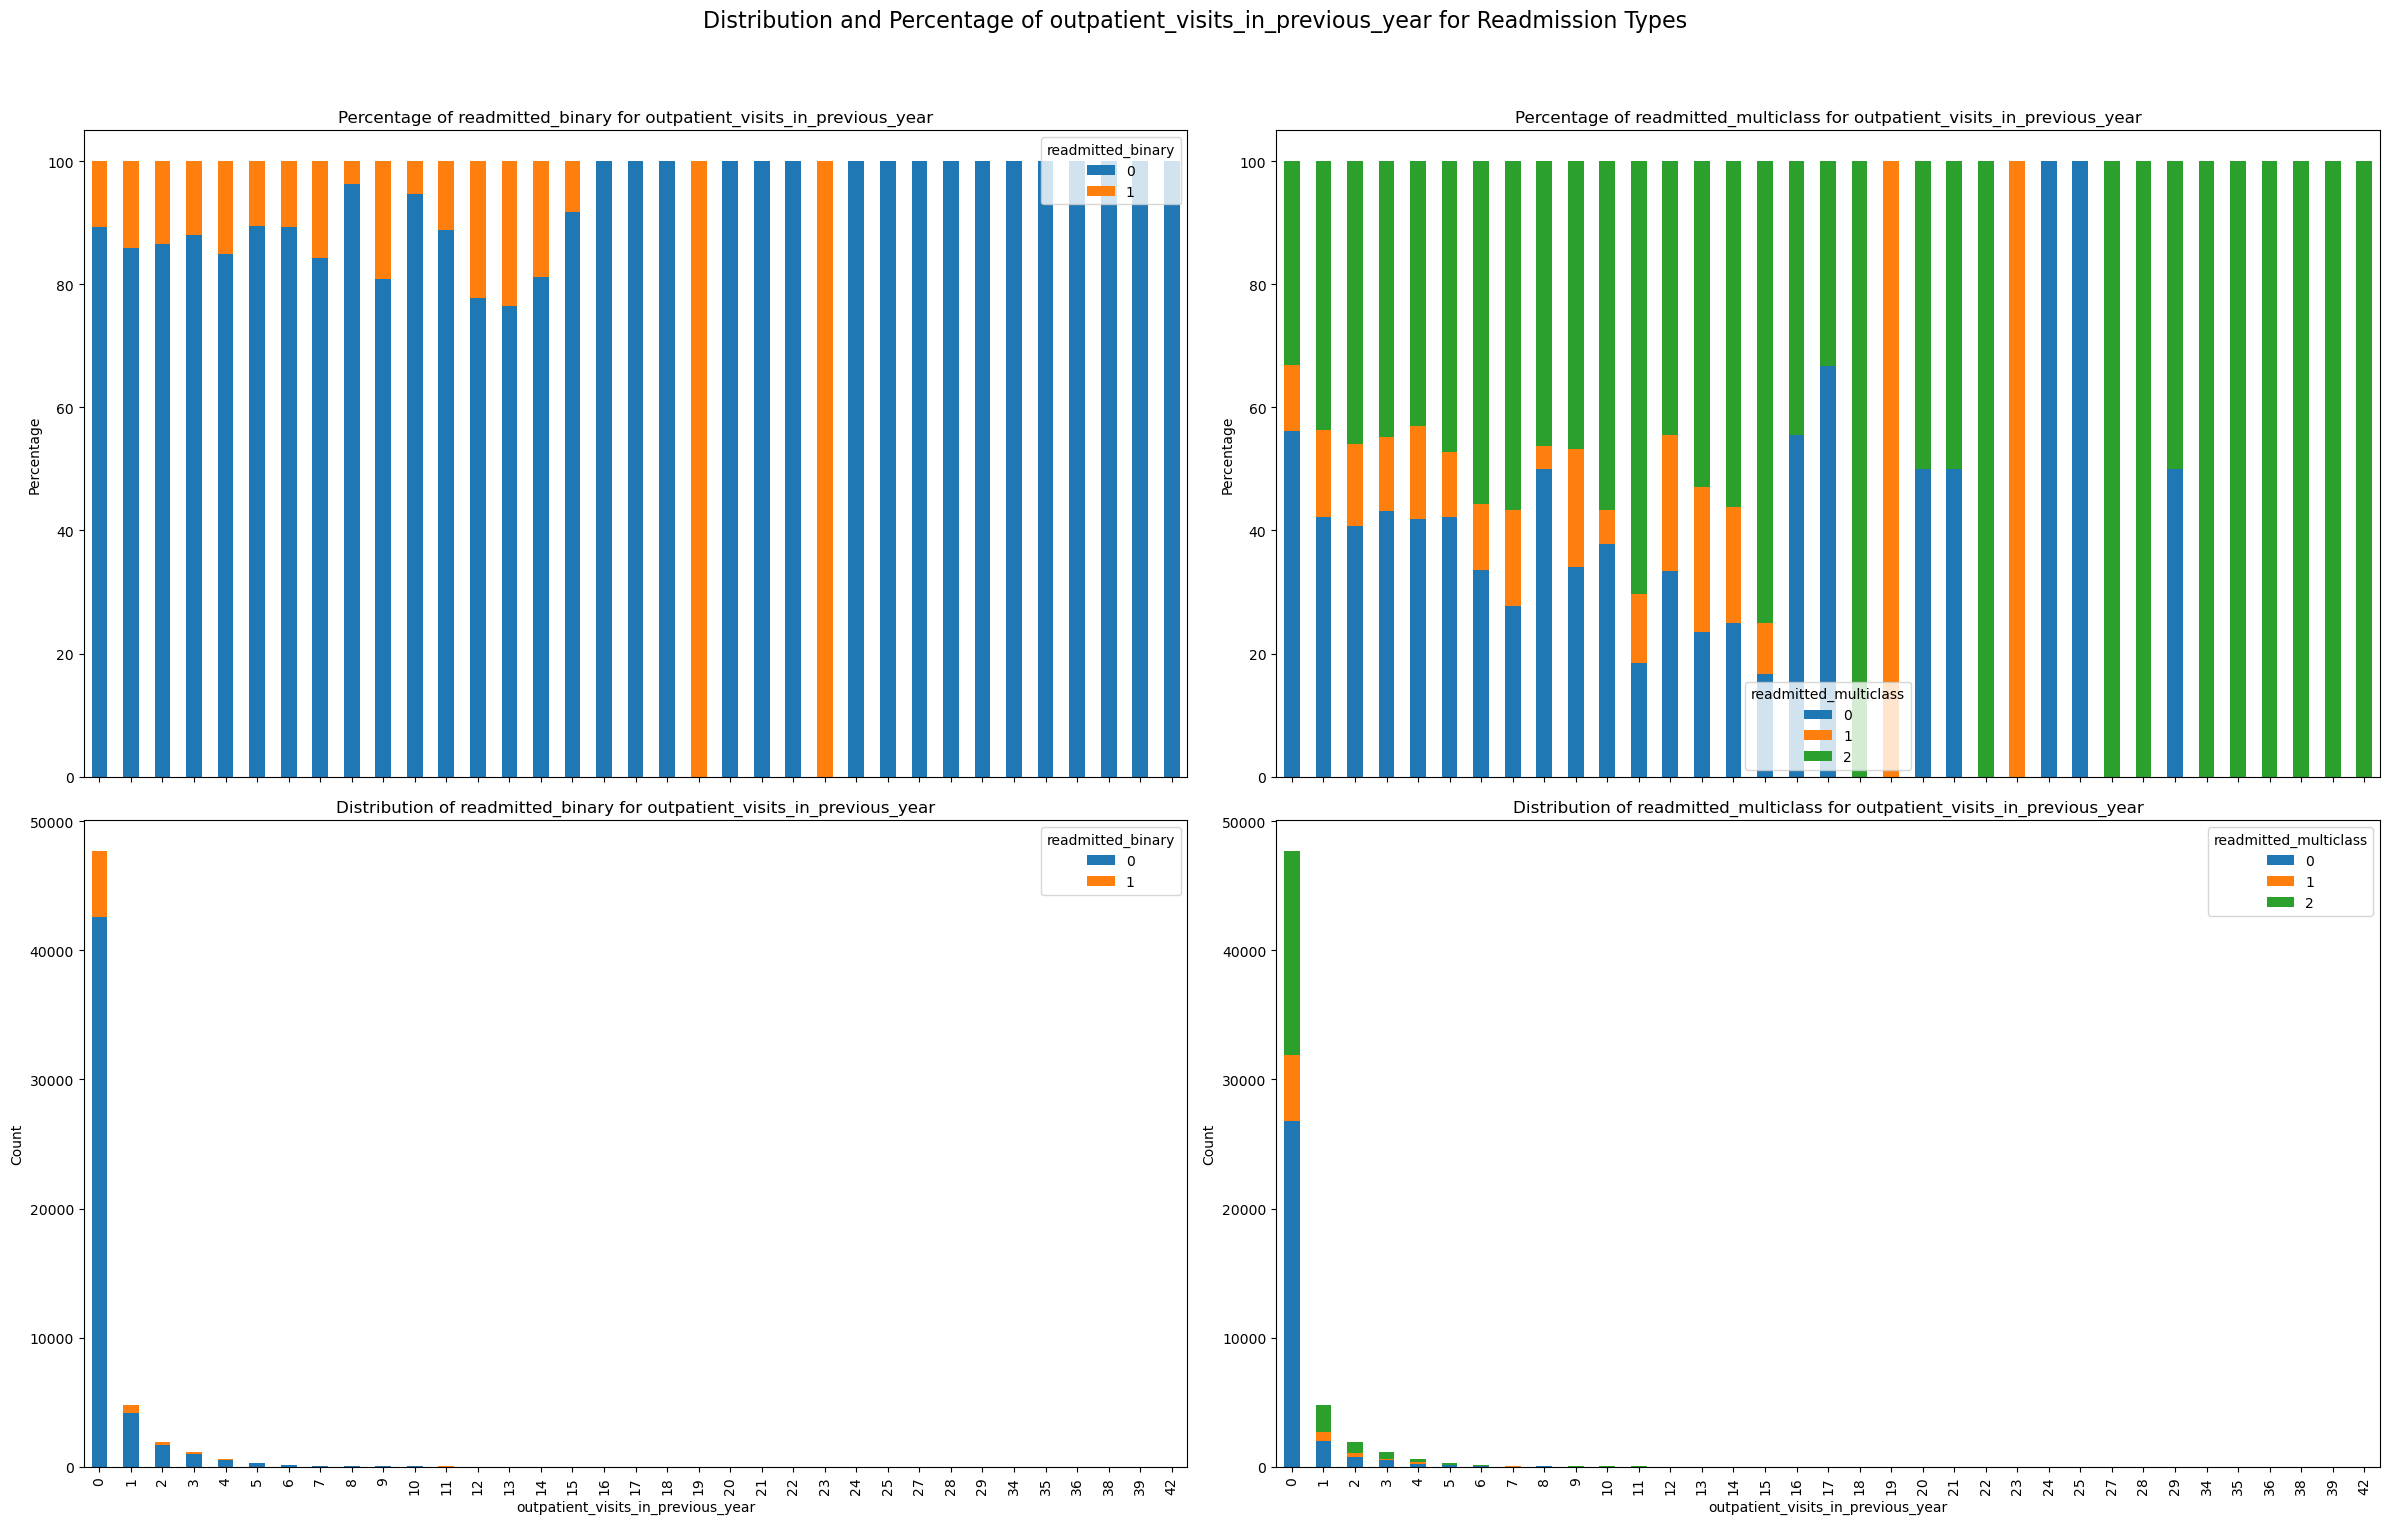

In [42]:
plot_categorical_distribution(data_train, 'outpatient_visits_in_previous_year')

In [43]:
# clip outliers at 23 for outpatient_visits_in_previous_year as we will only have 0 readmission after 23 visits
data_train['outpatient_visits_in_previous_year'] = data_train['outpatient_visits_in_previous_year'].clip(upper=24)
data_val['outpatient_visits_in_previous_year'] = data_val['outpatient_visits_in_previous_year'].clip(upper=24)
data_test['outpatient_visits_in_previous_year'] = data_test['outpatient_visits_in_previous_year'].clip(upper=24)


In [44]:
# clip outliers at 34 for outpatient_visits_in_previous_year
data_train_multi['outpatient_visits_in_previous_year'] = data_train_multi['outpatient_visits_in_previous_year'].clip(upper=34)
data_val_multi['outpatient_visits_in_previous_year'] = data_val_multi['outpatient_visits_in_previous_year'].clip(upper=34)
data_test_multi['outpatient_visits_in_previous_year'] = data_test_multi['outpatient_visits_in_previous_year'].clip(upper=34)

#### inpatient_visits_in_previous_year

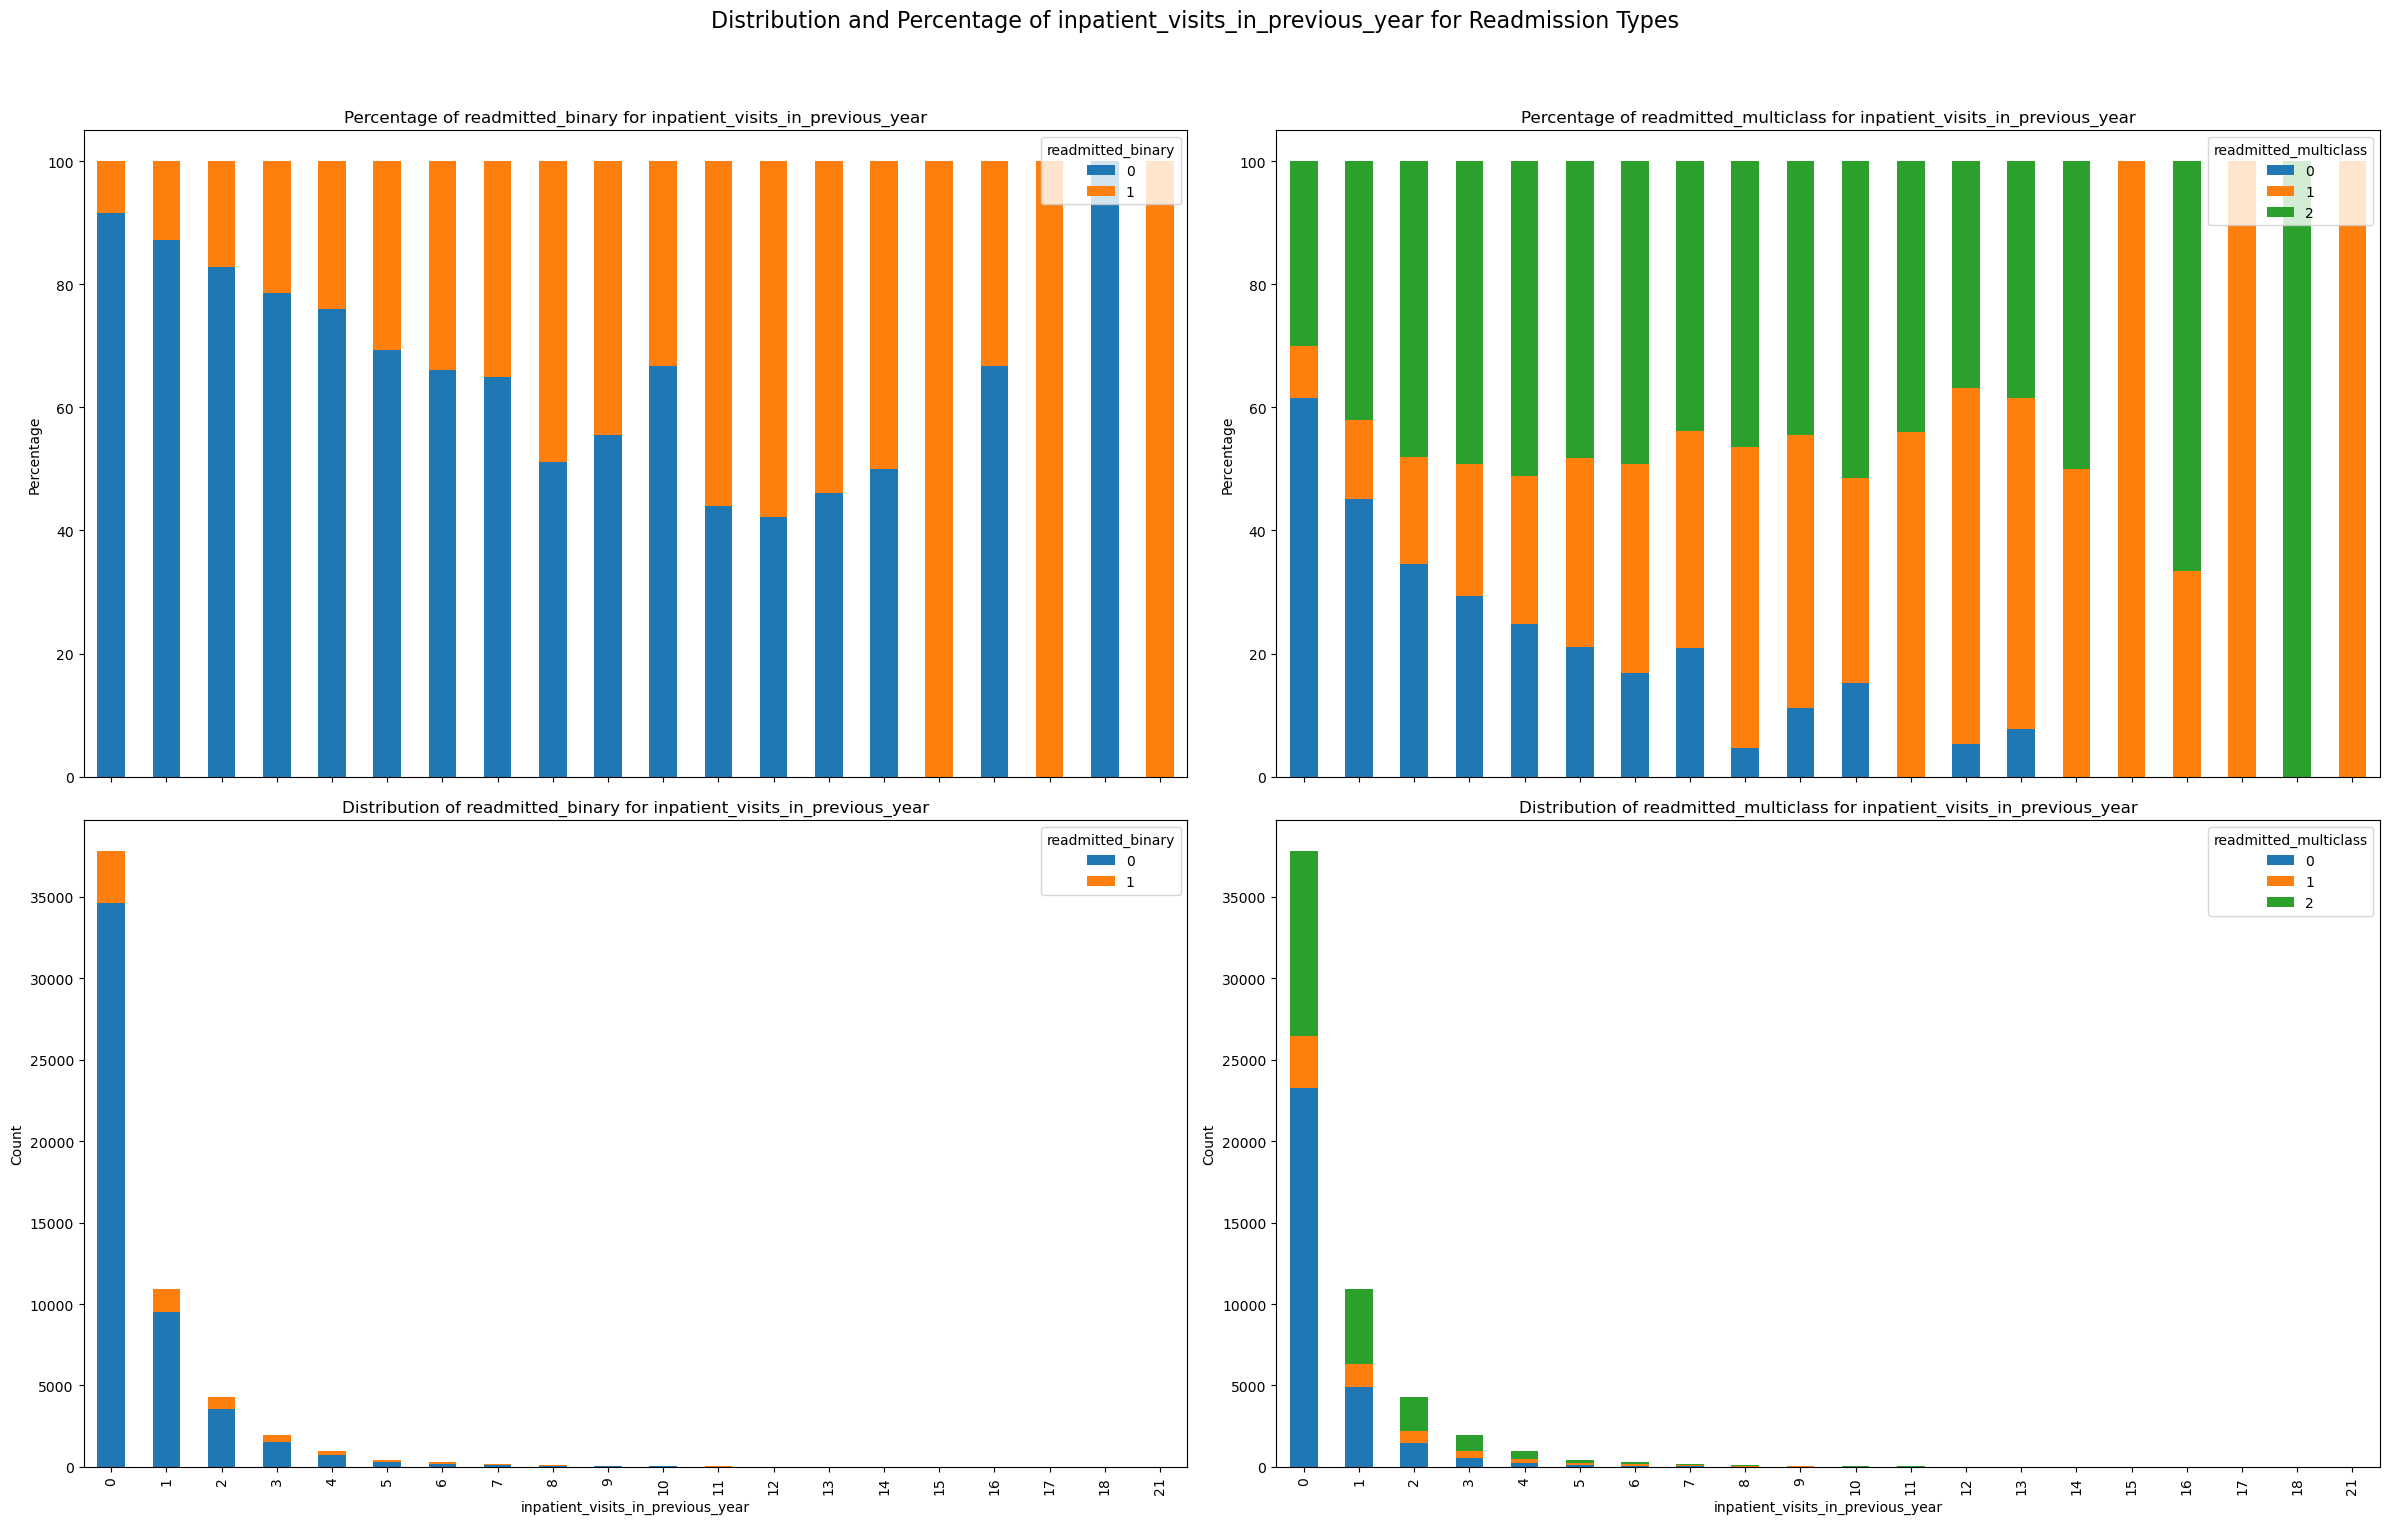

In [45]:
plot_categorical_distribution(data_train, 'inpatient_visits_in_previous_year')

In [46]:
# we are not clipping inpatient_visits_in_previous_year as we will don't see a good value. Too big inequality between 0 and 1 readmission in higher values.

#### emergency_visits_in_previous_year

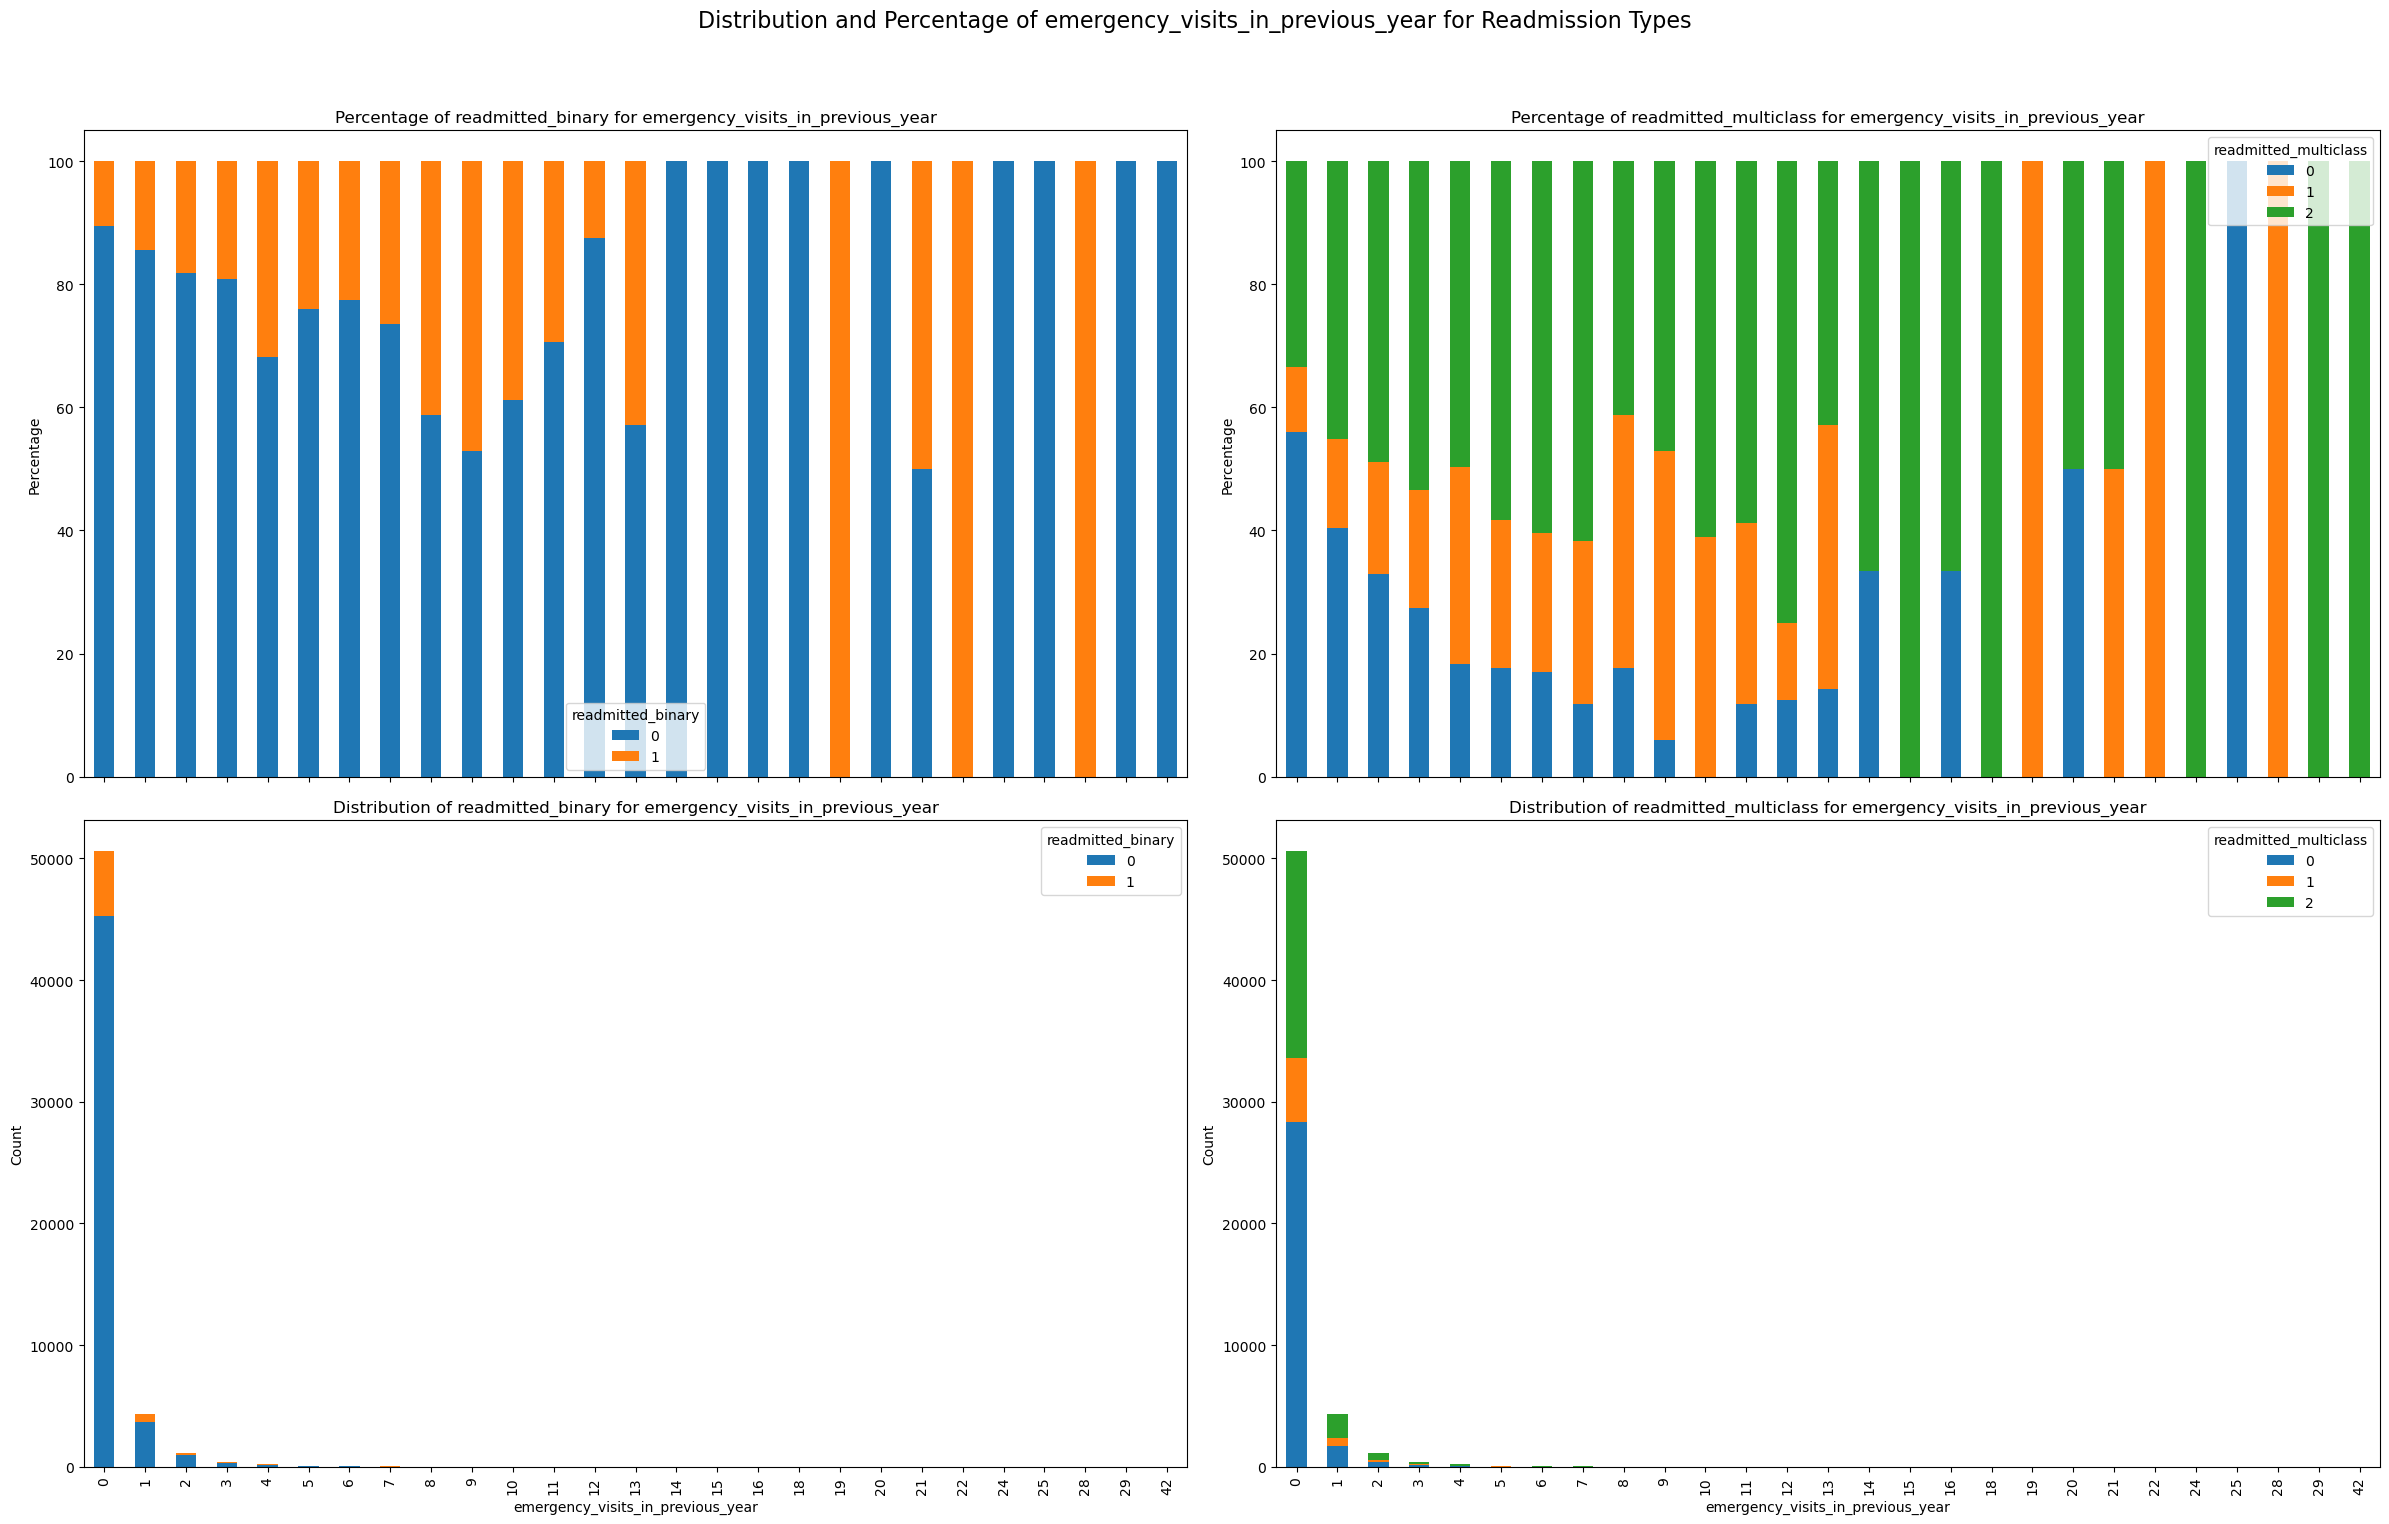

In [47]:
plot_categorical_distribution(data_train, 'emergency_visits_in_previous_year')

In [48]:
# clip at 29 for emergency_visits_in_previous_year as we will only have 0 readmission after 29 visits
data_train['emergency_visits_in_previous_year'] = data_train['emergency_visits_in_previous_year'].clip(upper=29)
data_val['emergency_visits_in_previous_year'] = data_val['emergency_visits_in_previous_year'].clip(upper=29)
data_test['emergency_visits_in_previous_year'] = data_test['emergency_visits_in_previous_year'].clip(upper=29)

In [49]:
data_train_multi['emergency_visits_in_previous_year'] = data_train_multi['emergency_visits_in_previous_year'].clip(upper=29)
data_val_multi['emergency_visits_in_previous_year'] = data_val_multi['emergency_visits_in_previous_year'].clip(upper=29)
data_test_multi['emergency_visits_in_previous_year'] = data_test_multi['emergency_visits_in_previous_year'].clip(upper=29)

#### admission_type

In [50]:
# fill nan with 'Missing' in data_train admission_type
data_train['admission_type'] = data_train['admission_type'].fillna('Missing')

# fill nan with 'Missing' in data_val and data_test admission_type
data_val['admission_type'] = data_val['admission_type'].fillna('Missing')
data_test['admission_type'] = data_test['admission_type'].fillna('Missing')

In [51]:
data_train_multi['admission_type'] = data_train_multi['admission_type'].fillna('Missing')
data_val_multi['admission_type'] = data_val_multi['admission_type'].fillna('Missing')
data_test_multi['admission_type'] = data_test_multi['admission_type'].fillna('Missing')

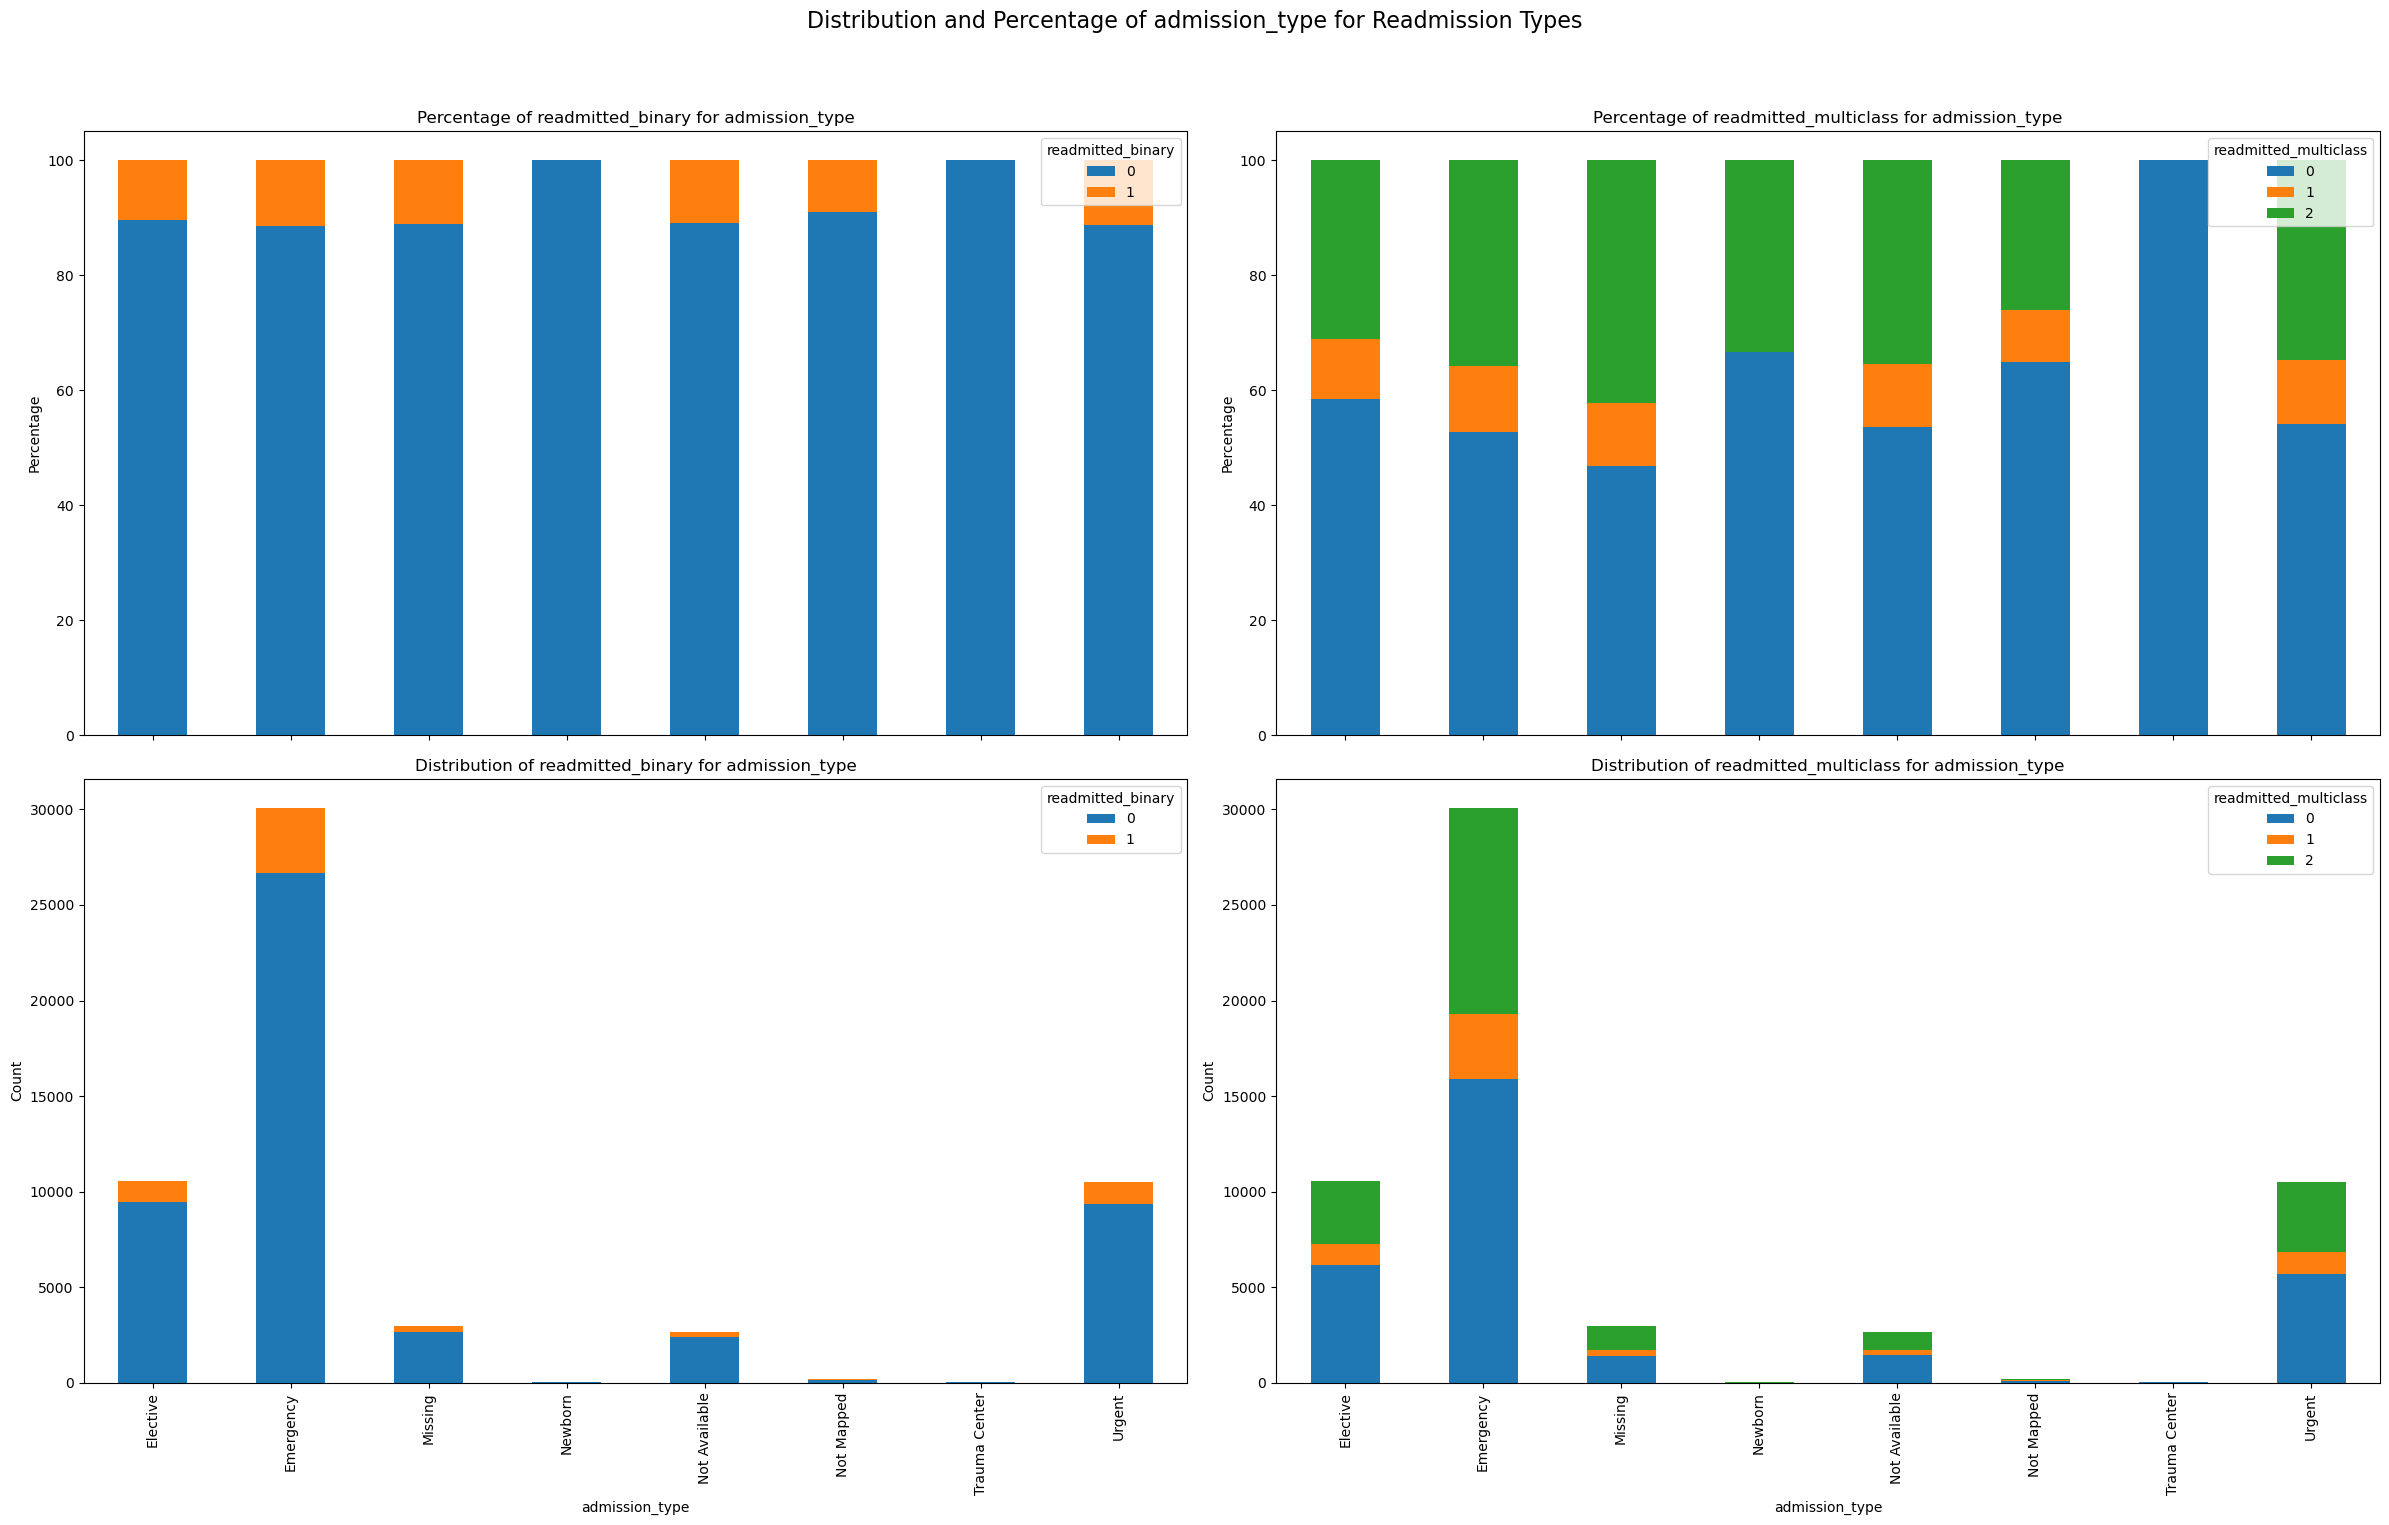

In [52]:
plot_categorical_distribution(data_train, 'admission_type')

In [53]:
data_train.groupby(['admission_type', 'readmitted_binary']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_binary,0,1
admission_type,admission_type,,
Elective,Elective,89.527059,10.472941
Emergency,Emergency,88.570289,11.429711
Missing,Missing,88.933602,11.066398
Newborn,Newborn,100.000000,NaN
Not Available,Not Available,89.075945,10.924055
Not Mapped,Not Mapped,90.909091,9.090909
Trauma Center,Trauma Center,100.000000,NaN
Urgent,Urgent,88.785225,11.214775


In [54]:
# since many categories will do almost the same prediction, we will group them together
data_train['admission_type'] = data_train['admission_type'].replace(['Trauma Center', 'Newborn'], 'No Readmission')
data_val['admission_type'] = data_val['admission_type'].replace(['Trauma Center', 'Newborn'], 'No Readmission')
data_test['admission_type'] = data_test['admission_type'].replace(['Trauma Center', 'Newborn'], 'No Readmission')

# since missing, not mapped and not available have similar readmission rate, we will group them together

data_train['admission_type'] = data_train['admission_type'].replace(['Missing', 'Not Available', 'Not Mapped'], 'Not Available/Not Mapped')
data_val['admission_type'] = data_val['admission_type'].replace(['Missing', 'Not Available', 'Not Mapped'], 'Not Available/Not Mapped')
data_test['admission_type'] = data_test['admission_type'].replace(['Missing', 'Not Available', 'Not Mapped'], 'Not Available/Not Mapped')

In [55]:
# don't combine anything for multiclass

#### medical_specialty

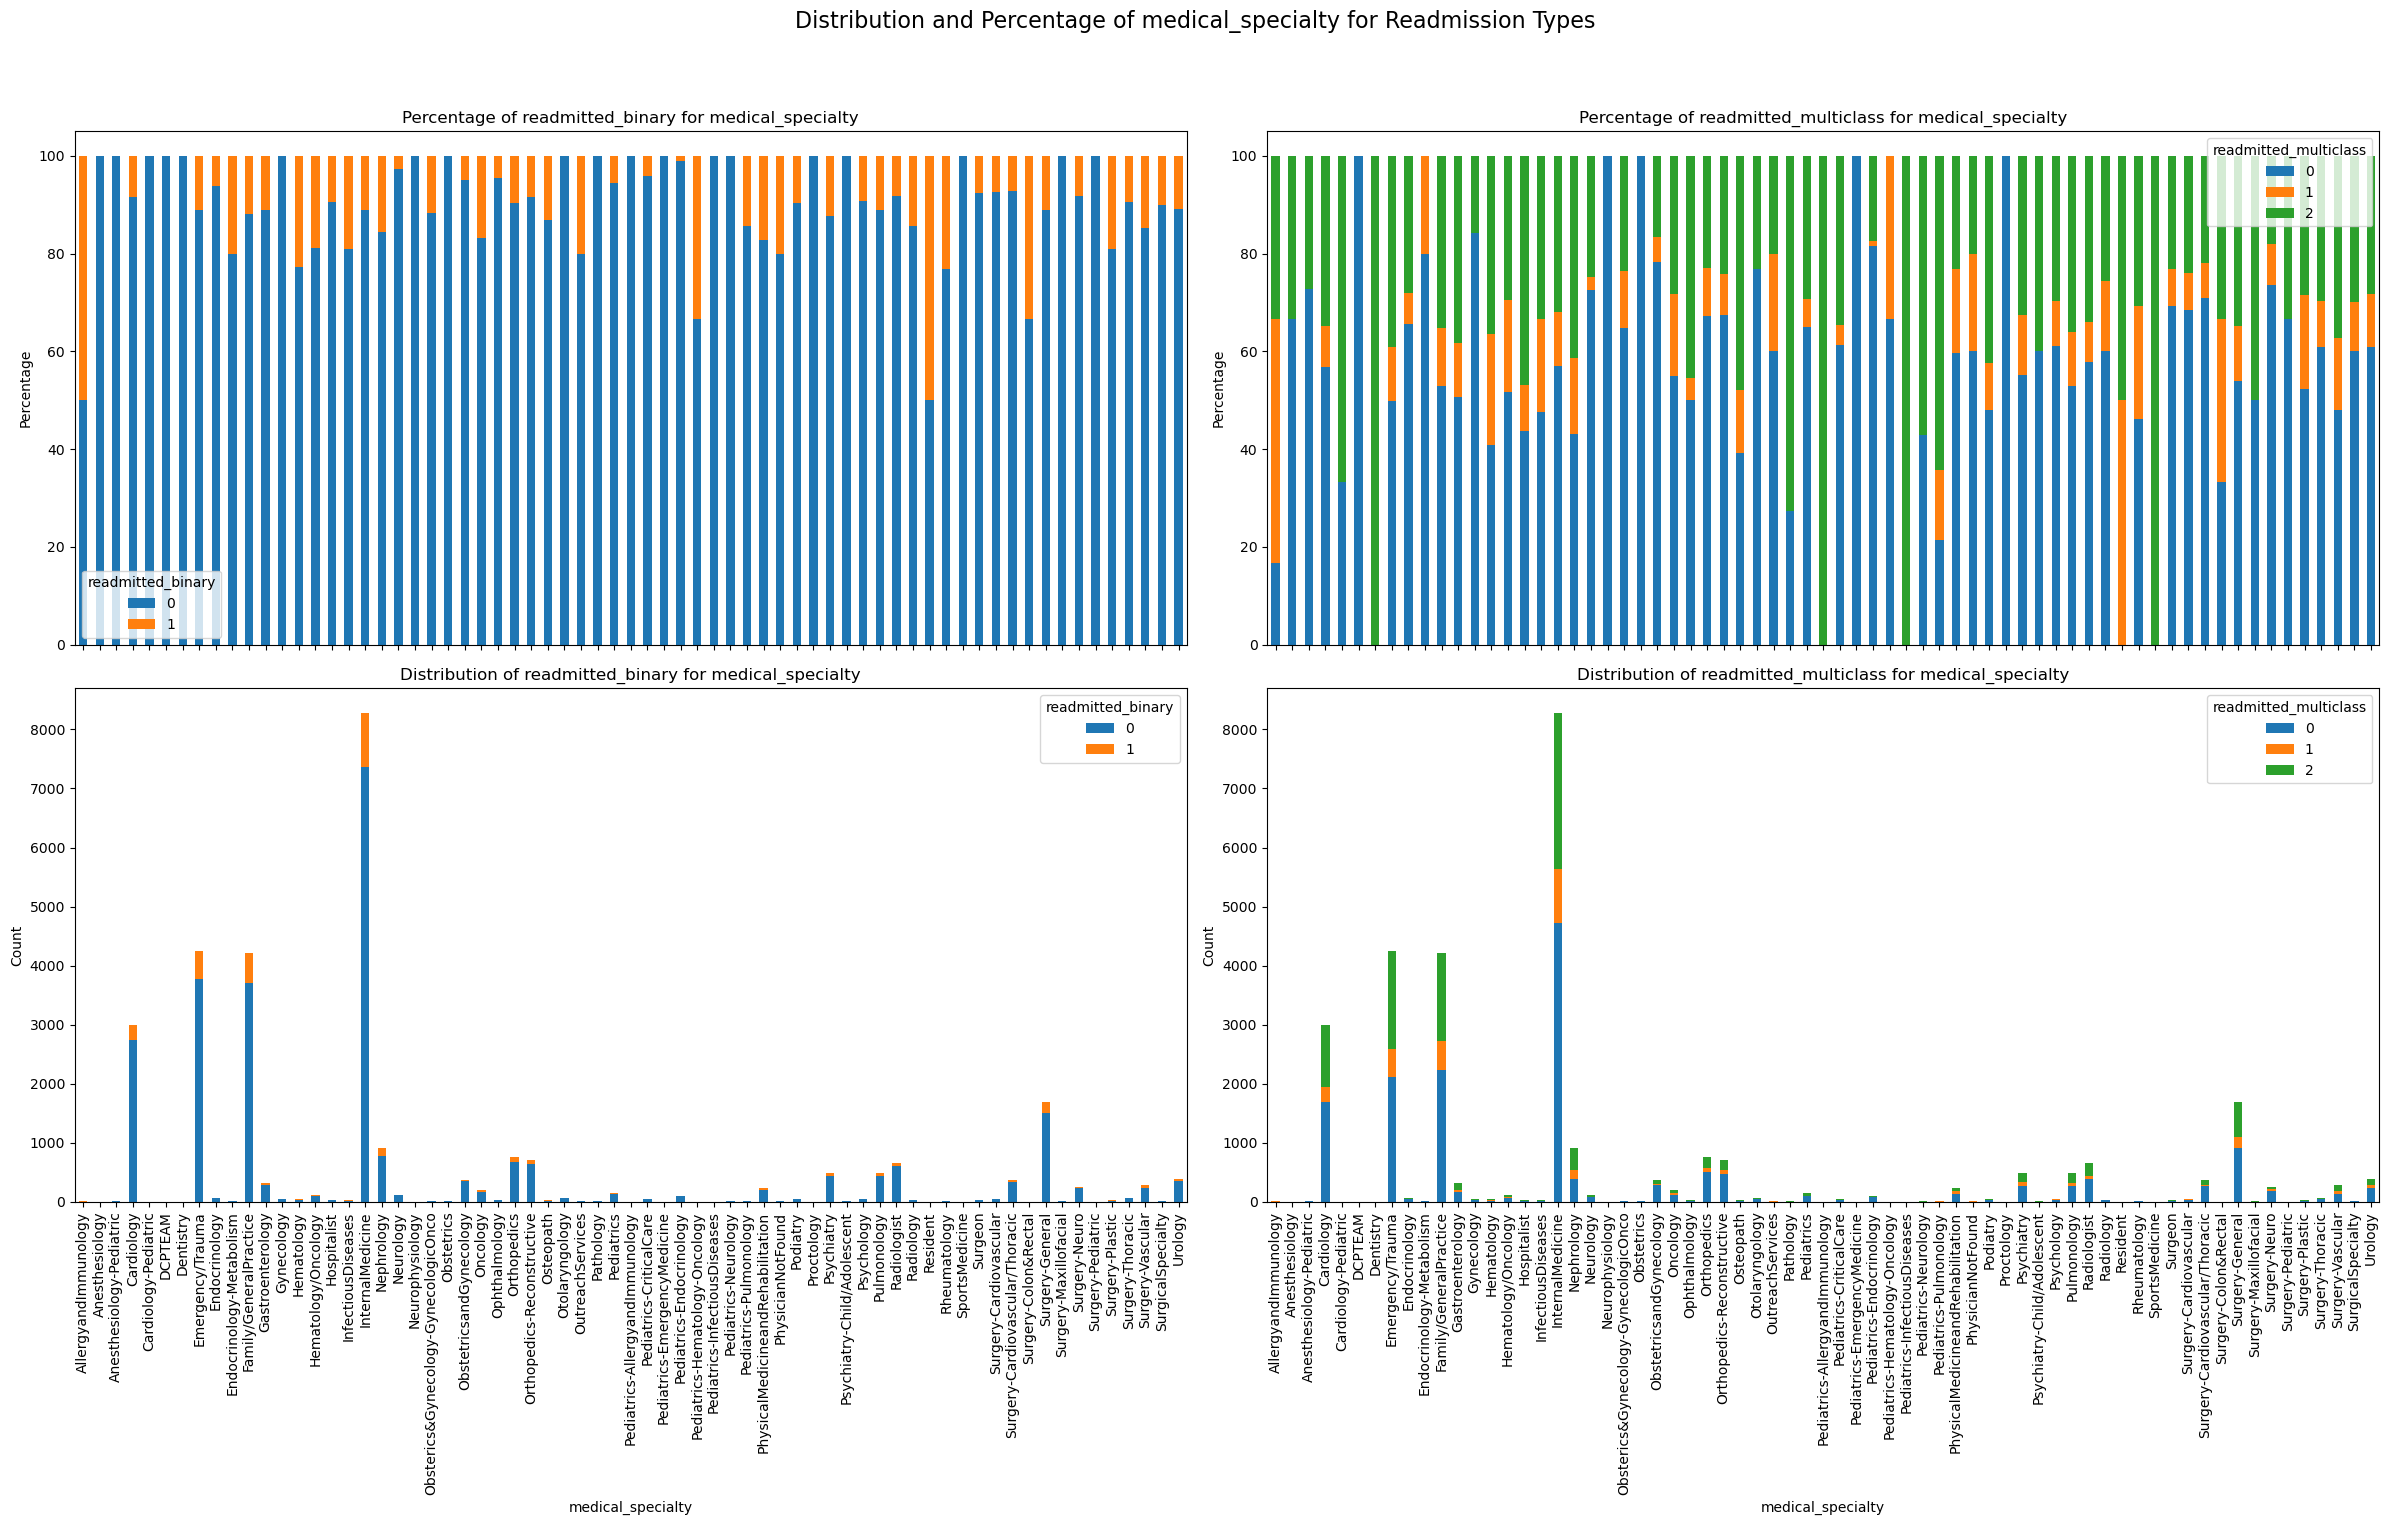

In [56]:
plot_categorical_distribution(data_train, 'medical_specialty')

In [57]:
# drop medical_specialty column since it has too many missing values
data_train.drop(['medical_specialty'], axis=1, inplace=True)
data_val.drop(['medical_specialty'], axis=1, inplace=True)
data_test.drop(['medical_specialty'], axis=1, inplace=True)


In [58]:
data_train_multi.drop(['medical_specialty'], axis=1, inplace=True)
data_val_multi.drop(['medical_specialty'], axis=1, inplace=True)
data_test_multi.drop(['medical_specialty'], axis=1, inplace=True)

In [59]:
# tried and it is better to drop

#### average_pulse_bpm

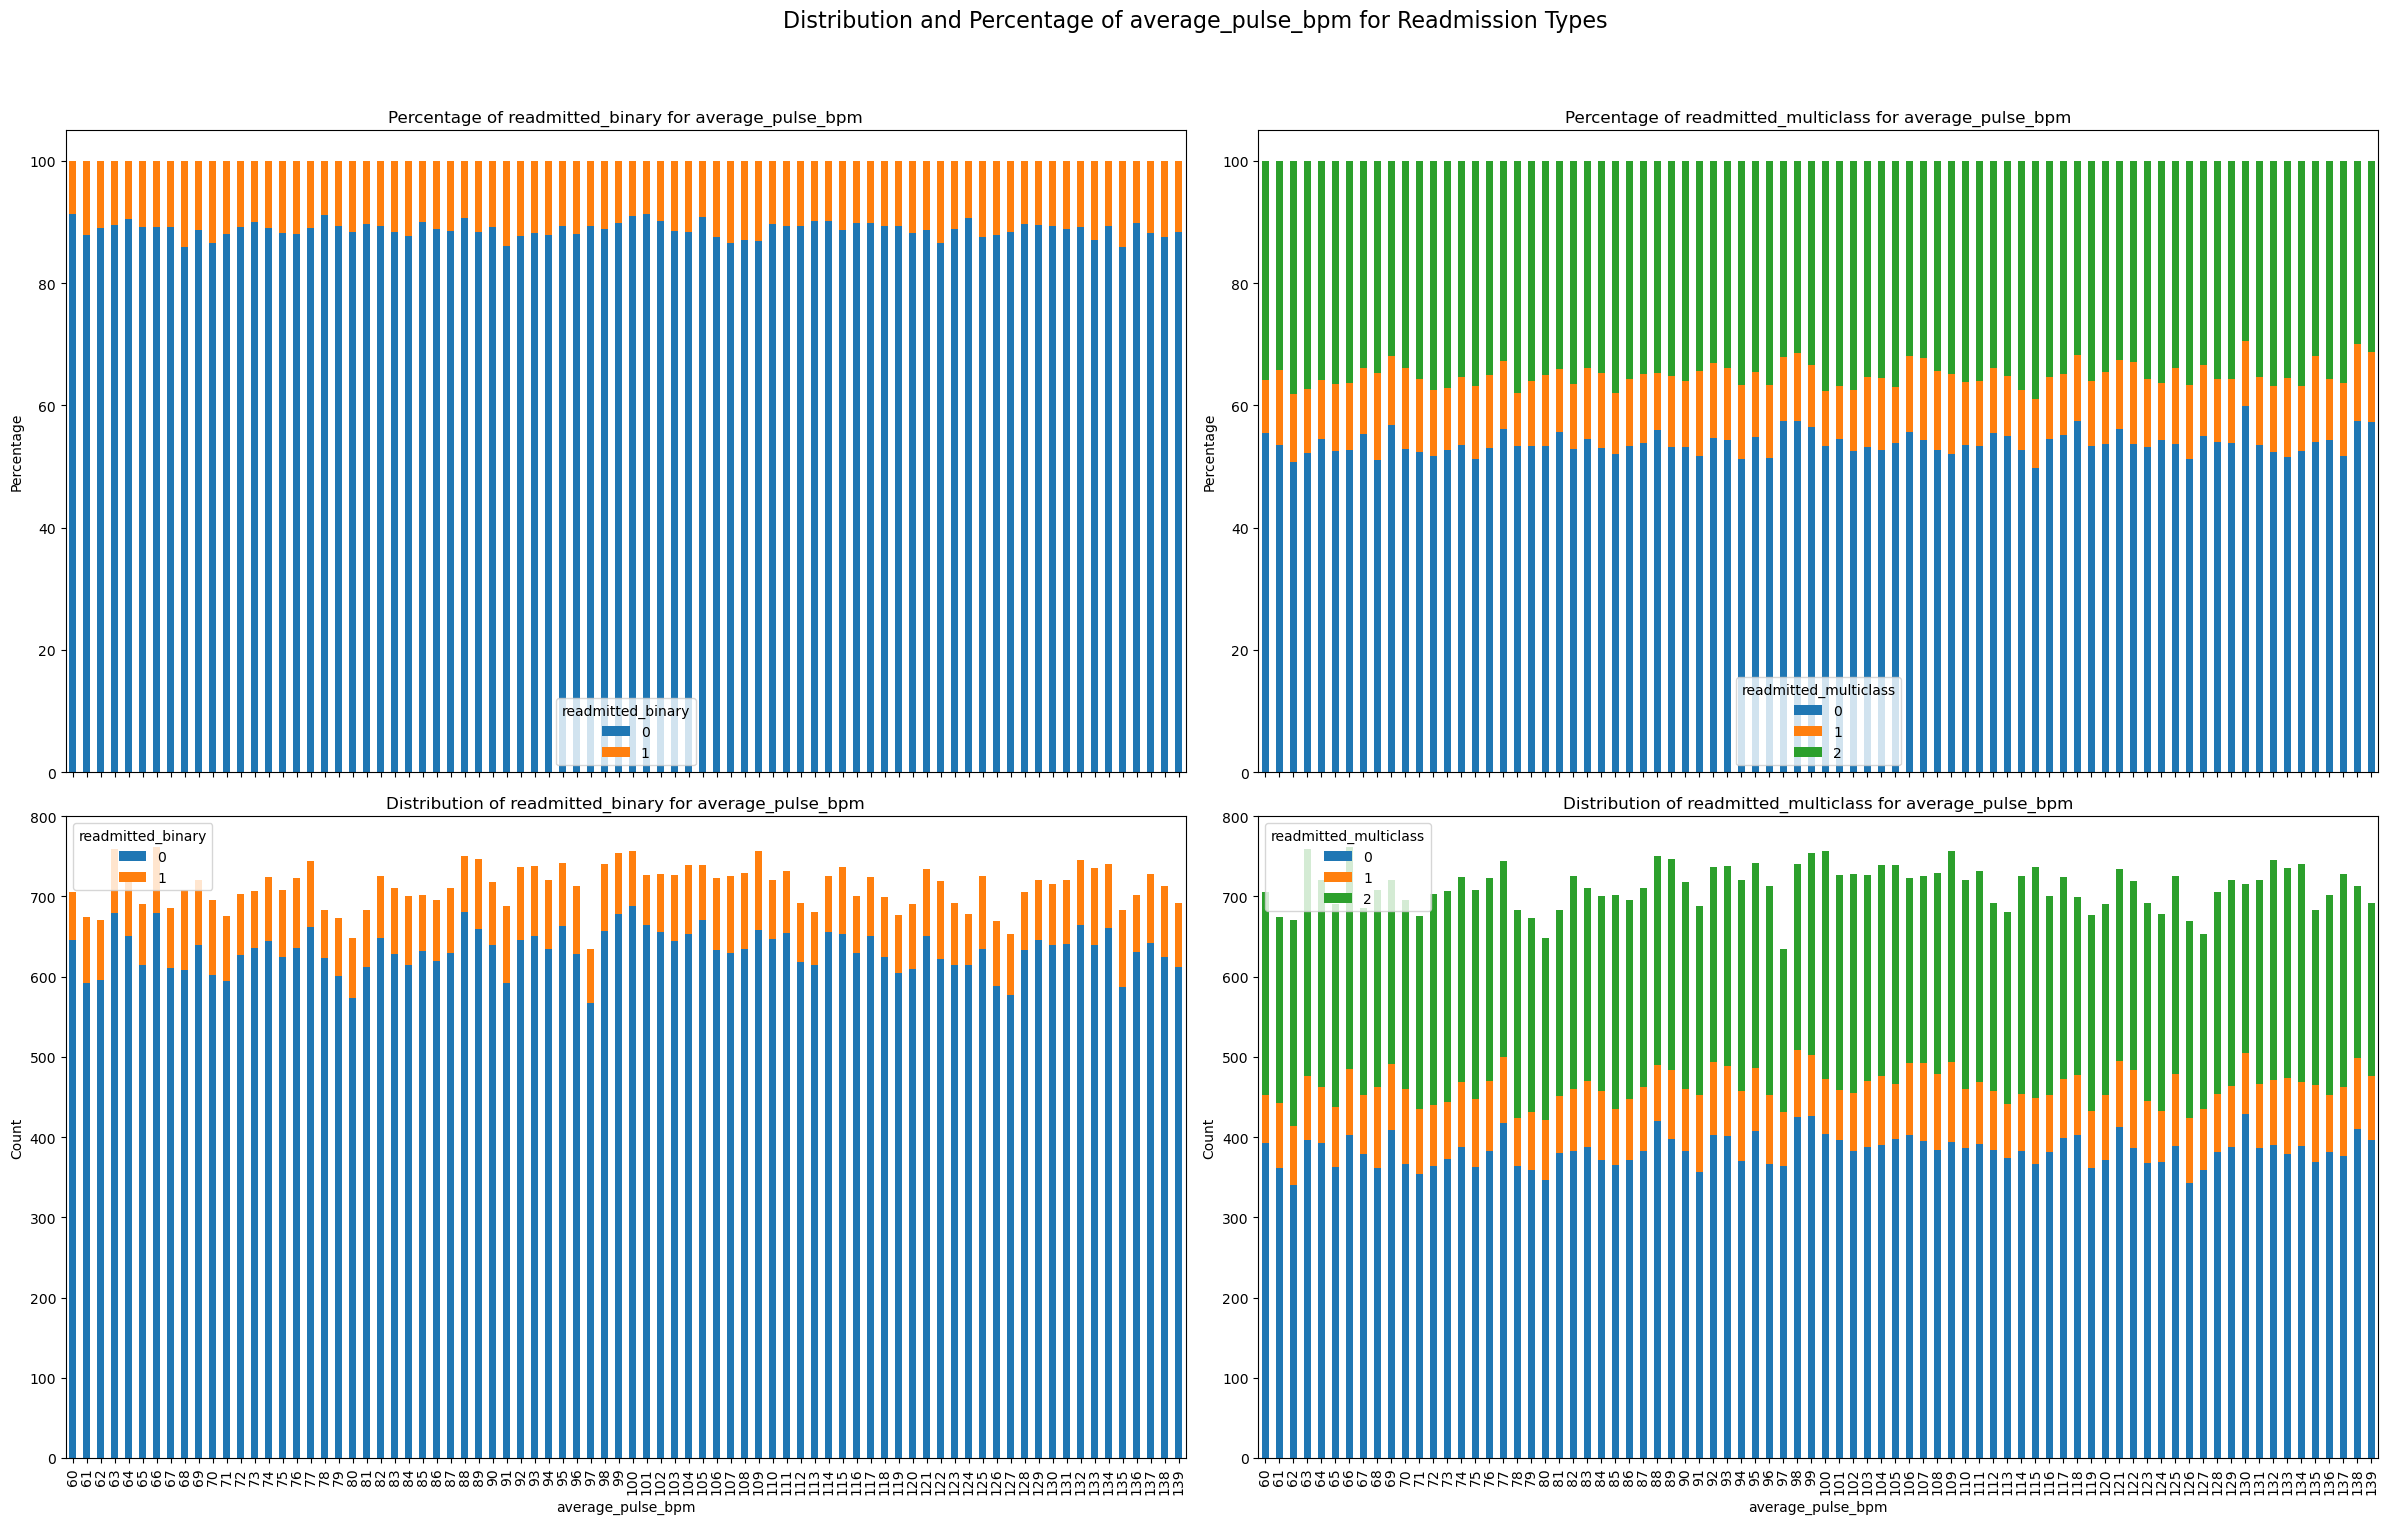

In [60]:
plot_categorical_distribution(data_train, 'average_pulse_bpm')

In [61]:
# as there is almost no variance in the data, we will drop
# data_train.drop(['average_pulse_bpm'], axis=1, inplace=True)
# data_val.drop(['average_pulse_bpm'], axis=1, inplace=True)
# data_test.drop(['average_pulse_bpm'], axis=1, inplace=True)

#### discharge_disposition

In [62]:
data_train['discharge_disposition'].value_counts()

discharge_disposition
Discharged to home                                                                                           33824
Discharged/transferred to SNF                                                                                 7771
Discharged/transferred to home with home health service                                                       7248
Discharged/transferred to another short term hospital                                                         1191
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1112
Expired                                                                                                        904
Discharged/transferred to another type of inpatient care institution                                           656
Not Mapped                                                                                                     549
Discharged/transferred to ICF                             

In [63]:
# fill missing values with 'Missing'
data_train['discharge_disposition'] = data_train['discharge_disposition'].fillna('Missing')
data_val['discharge_disposition'] = data_val['discharge_disposition'].fillna('Missing')
data_test['discharge_disposition'] = data_test['discharge_disposition'].fillna('Missing')

In [64]:
data_train_multi['discharge_disposition'] = data_train_multi['discharge_disposition'].fillna('Missing')
data_val_multi['discharge_disposition'] = data_val_multi['discharge_disposition'].fillna('Missing')
data_test_multi['discharge_disposition'] = data_test_multi['discharge_disposition'].fillna('Missing')

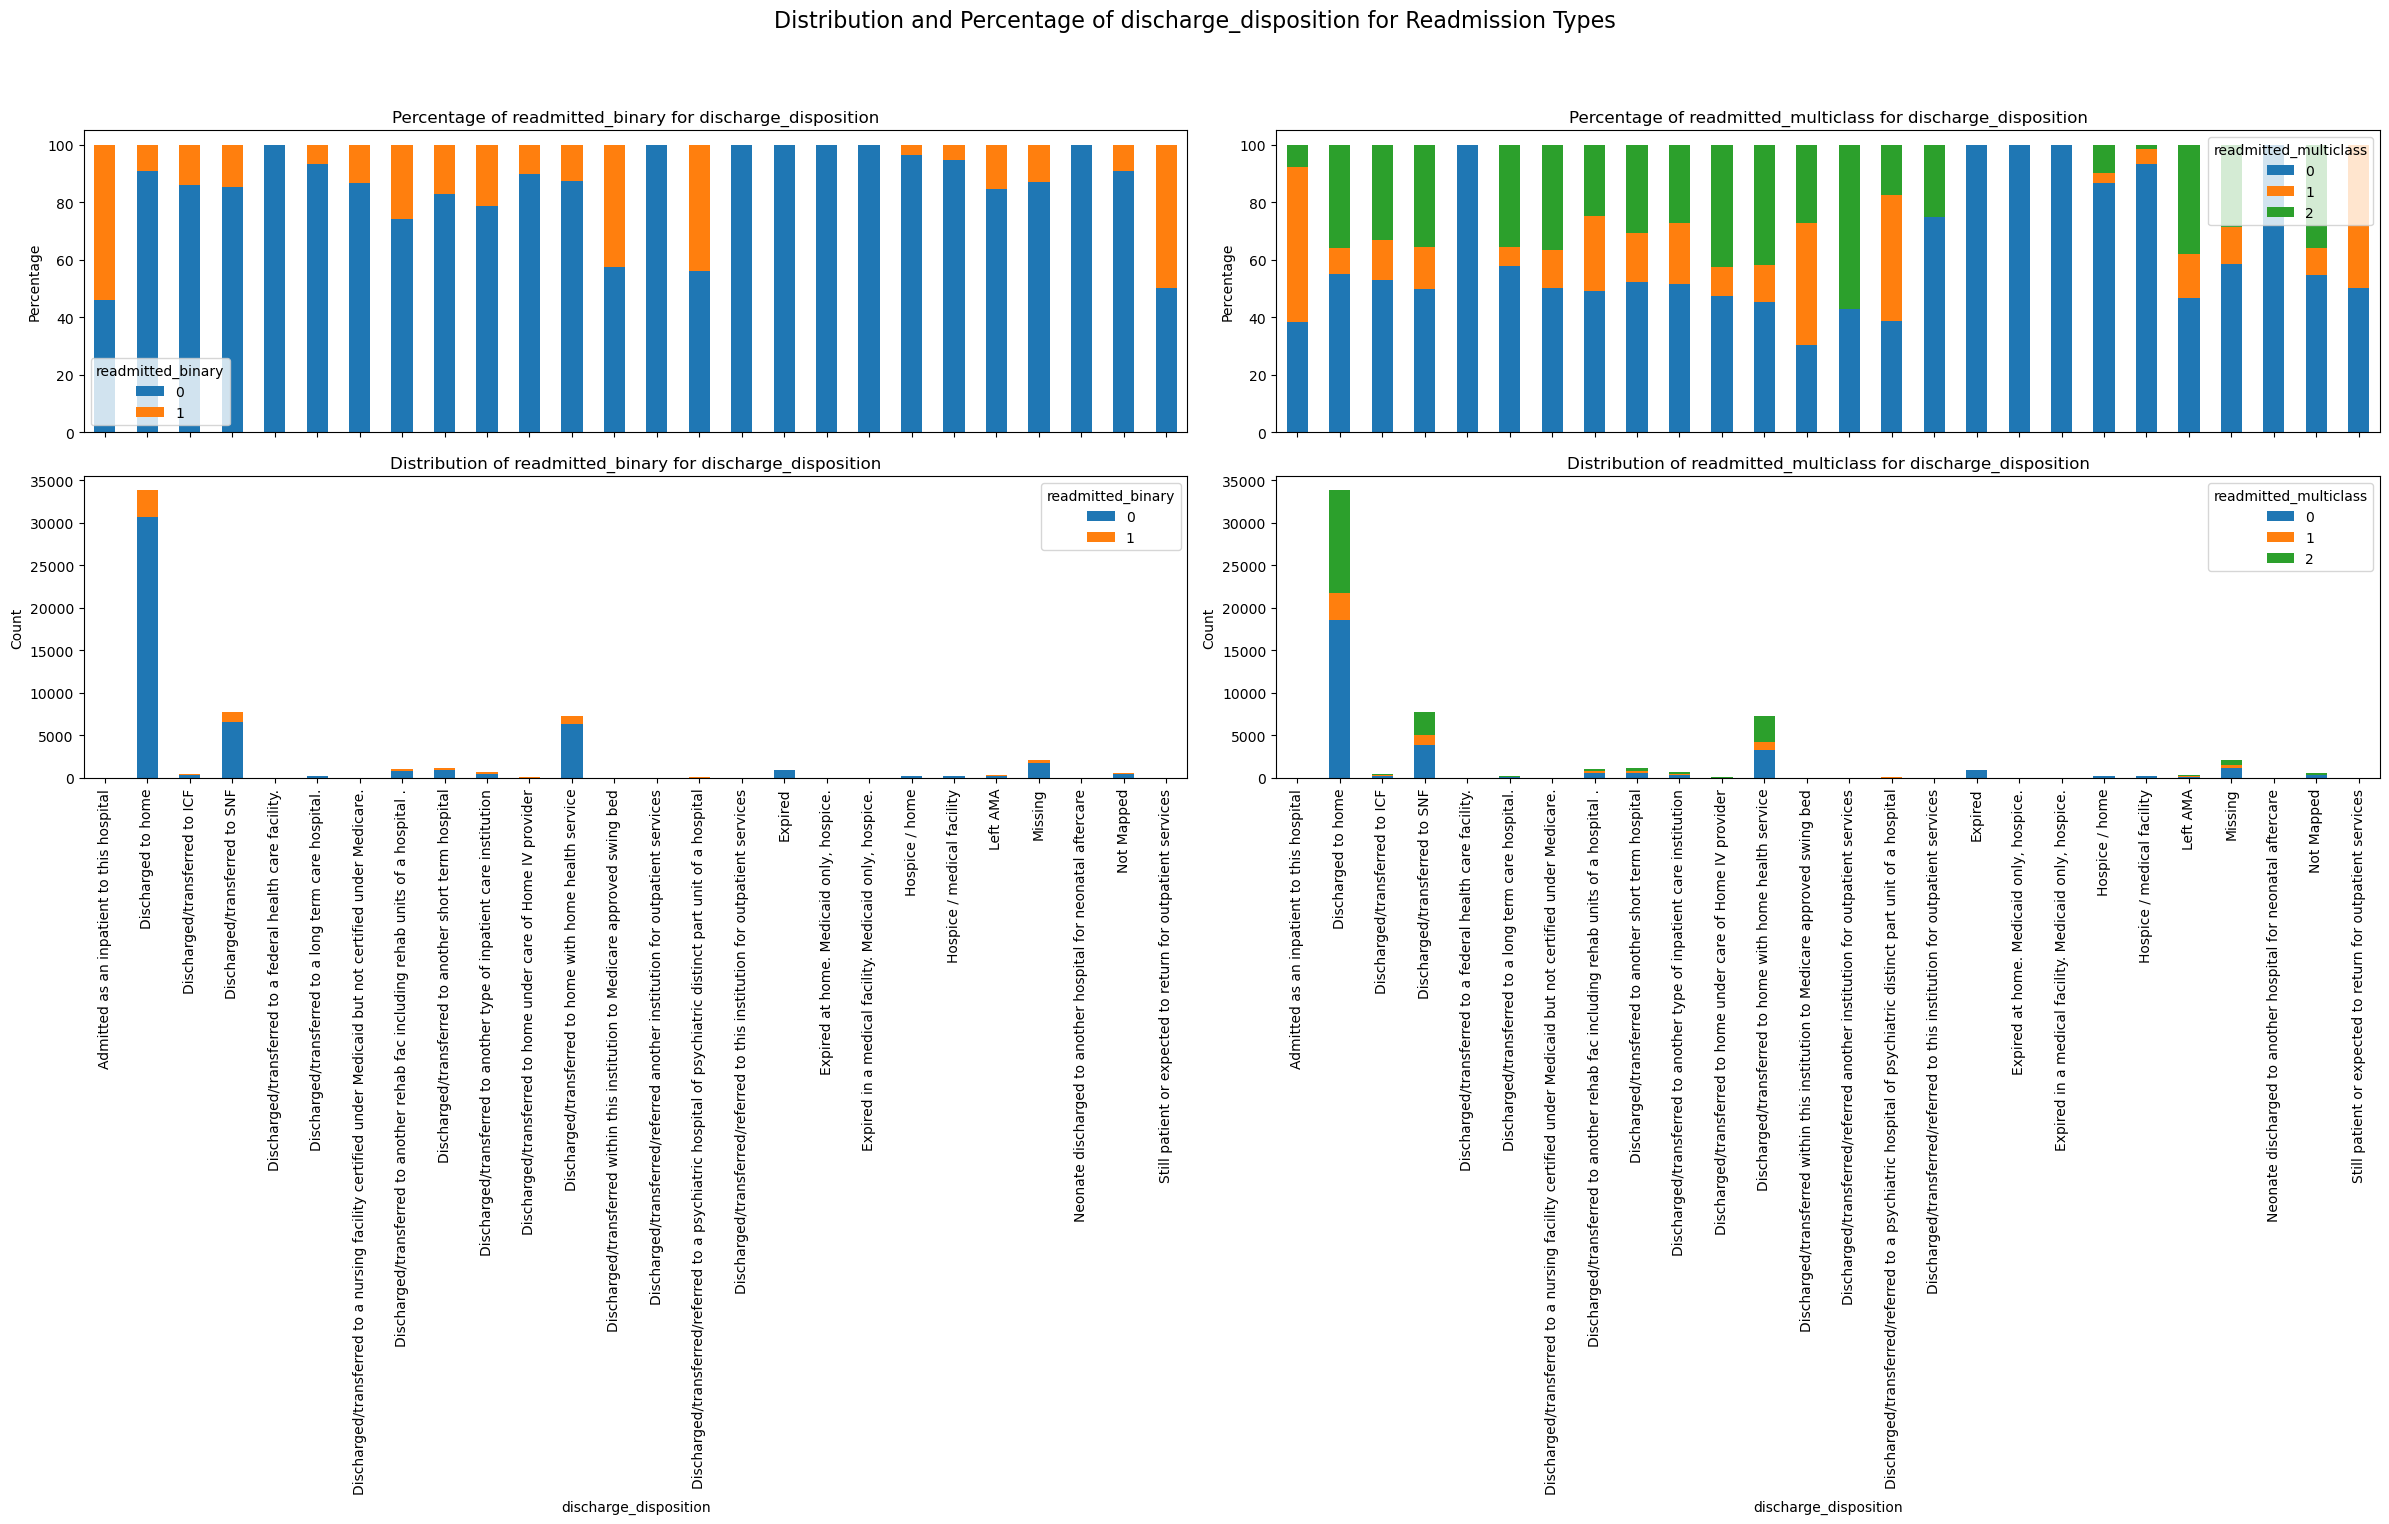

In [65]:
plot_categorical_distribution(data_train, 'discharge_disposition')

In [66]:
# show me difference in categories between data_train and data_test
print(set(data_train['discharge_disposition'].unique()) - set(data_test['discharge_disposition'].unique()))
print(set(data_test['discharge_disposition'].unique()) - set(data_train['discharge_disposition'].unique()))


set()
set()


In [67]:
# show me difference in categories between data_train_multi and data_test_multi
print(set(data_train_multi['discharge_disposition'].unique()) - set(data_test_multi['discharge_disposition'].unique()))
print(set(data_test_multi['discharge_disposition'].unique()) - set(data_train_multi['discharge_disposition'].unique()))

set()
set()


In [68]:
data_train.groupby(['discharge_disposition', 'readmitted_binary']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_binary,0,1
discharge_disposition,discharge_disposition,,
Admitted as an inpatient to this hospital,Admitted as an inpatient to this hospital,46.153846,53.846154
Discharged to home,Discharged to home,90.701868,9.298132
Discharged/transferred to ICF,Discharged/transferred to ICF,85.991379,14.008621
Discharged/transferred to SNF,Discharged/transferred to SNF,85.355810,14.644190
Discharged/transferred to a federal health care facility.,Discharged/transferred to a federal health care facility.,100.000000,NaN
Discharged/transferred to a long term care hospital.,Discharged/transferred to a long term care hospital.,93.273543,6.726457
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,86.666667,13.333333
Discharged/transferred to another rehab fac including rehab units of a hospital .,Discharged/transferred to another rehab fac including rehab units of a hospital .,74.010791,25.989209
Discharged/transferred to another short term hospital,Discharged/transferred to another short term hospital,82.871537,17.128463


In [69]:
# combine categories that have 0% readmission rate or dimensionality reduction as they all would do same predictions anyway

data_train['discharge_disposition'] = data_train['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')


data_val['discharge_disposition'] = data_val['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')


data_test['discharge_disposition'] = data_test['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')



In [70]:
# we used to combine not mapped and missing but since the readmission rates are so different and therefore their predictions will be different, we will keep them seperate.

In [71]:
data_train_multi.groupby(['discharge_disposition', 'readmitted_multiclass']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_multiclass,0,1,2
discharge_disposition,discharge_disposition,,,
Admitted as an inpatient to this hospital,Admitted as an inpatient to this hospital,38.461538,53.846154,7.692308
Discharged to home,Discharged to home,54.884106,9.298132,35.817763
Discharged/transferred to ICF,Discharged/transferred to ICF,52.801724,14.008621,33.189655
Discharged/transferred to SNF,Discharged/transferred to SNF,49.929224,14.644190,35.426586
Discharged/transferred to a federal health care facility.,Discharged/transferred to a federal health care facility.,100.000000,NaN,NaN
Discharged/transferred to a long term care hospital.,Discharged/transferred to a long term care hospital.,57.847534,6.726457,35.426009
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,50.000000,13.333333,36.666667
Discharged/transferred to another rehab fac including rehab units of a hospital .,Discharged/transferred to another rehab fac including rehab units of a hospital .,49.280576,25.989209,24.730216
Discharged/transferred to another short term hospital,Discharged/transferred to another short term hospital,52.225021,17.128463,30.646516


In [72]:
# combine categories that have 0% readmission rate or dimensionality reduction as they all would do same predictions anyway

data_train_multi['discharge_disposition'] = data_train_multi['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Expired at home. Medicaid only, hospice.', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired'], '100% Discharged')

data_val_multi['discharge_disposition'] = data_val_multi['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Expired at home. Medicaid only, hospice.', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired'], '100% Discharged')

data_test_multi['discharge_disposition'] = data_test_multi['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Expired at home. Medicaid only, hospice.', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired'], '100% Discharged')

#### admission_source

In [73]:
data_train['admission_source'].value_counts()

admission_source
 Emergency Room                                               32201
 Physician Referral                                           16554
Transfer from a hospital                                       1816
 Transfer from another health care facility                    1226
Clinic Referral                                                 615
 Transfer from a Skilled Nursing Facility (SNF)                 465
HMO Referral                                                    105
 Not Mapped                                                      85
 Not Available                                                   80
 Court/Law Enforcement                                            9
 Transfer from hospital inpt/same fac reslt in a sep claim        6
 Transfer from critial access hospital                            6
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   1
 Extramural Birth              

In [74]:
# fill missing values with 'Missing'
data_train['admission_source'] = data_train['admission_source'].fillna('Missing')
data_val['admission_source'] = data_val['admission_source'].fillna('Missing')
data_test['admission_source'] = data_test['admission_source'].fillna('Missing')

In [75]:
data_train_multi['admission_source'] = data_train_multi['admission_source'].fillna('Missing')
data_val_multi['admission_source'] = data_val_multi['admission_source'].fillna('Missing')
data_test_multi['admission_source'] = data_test_multi['admission_source'].fillna('Missing')

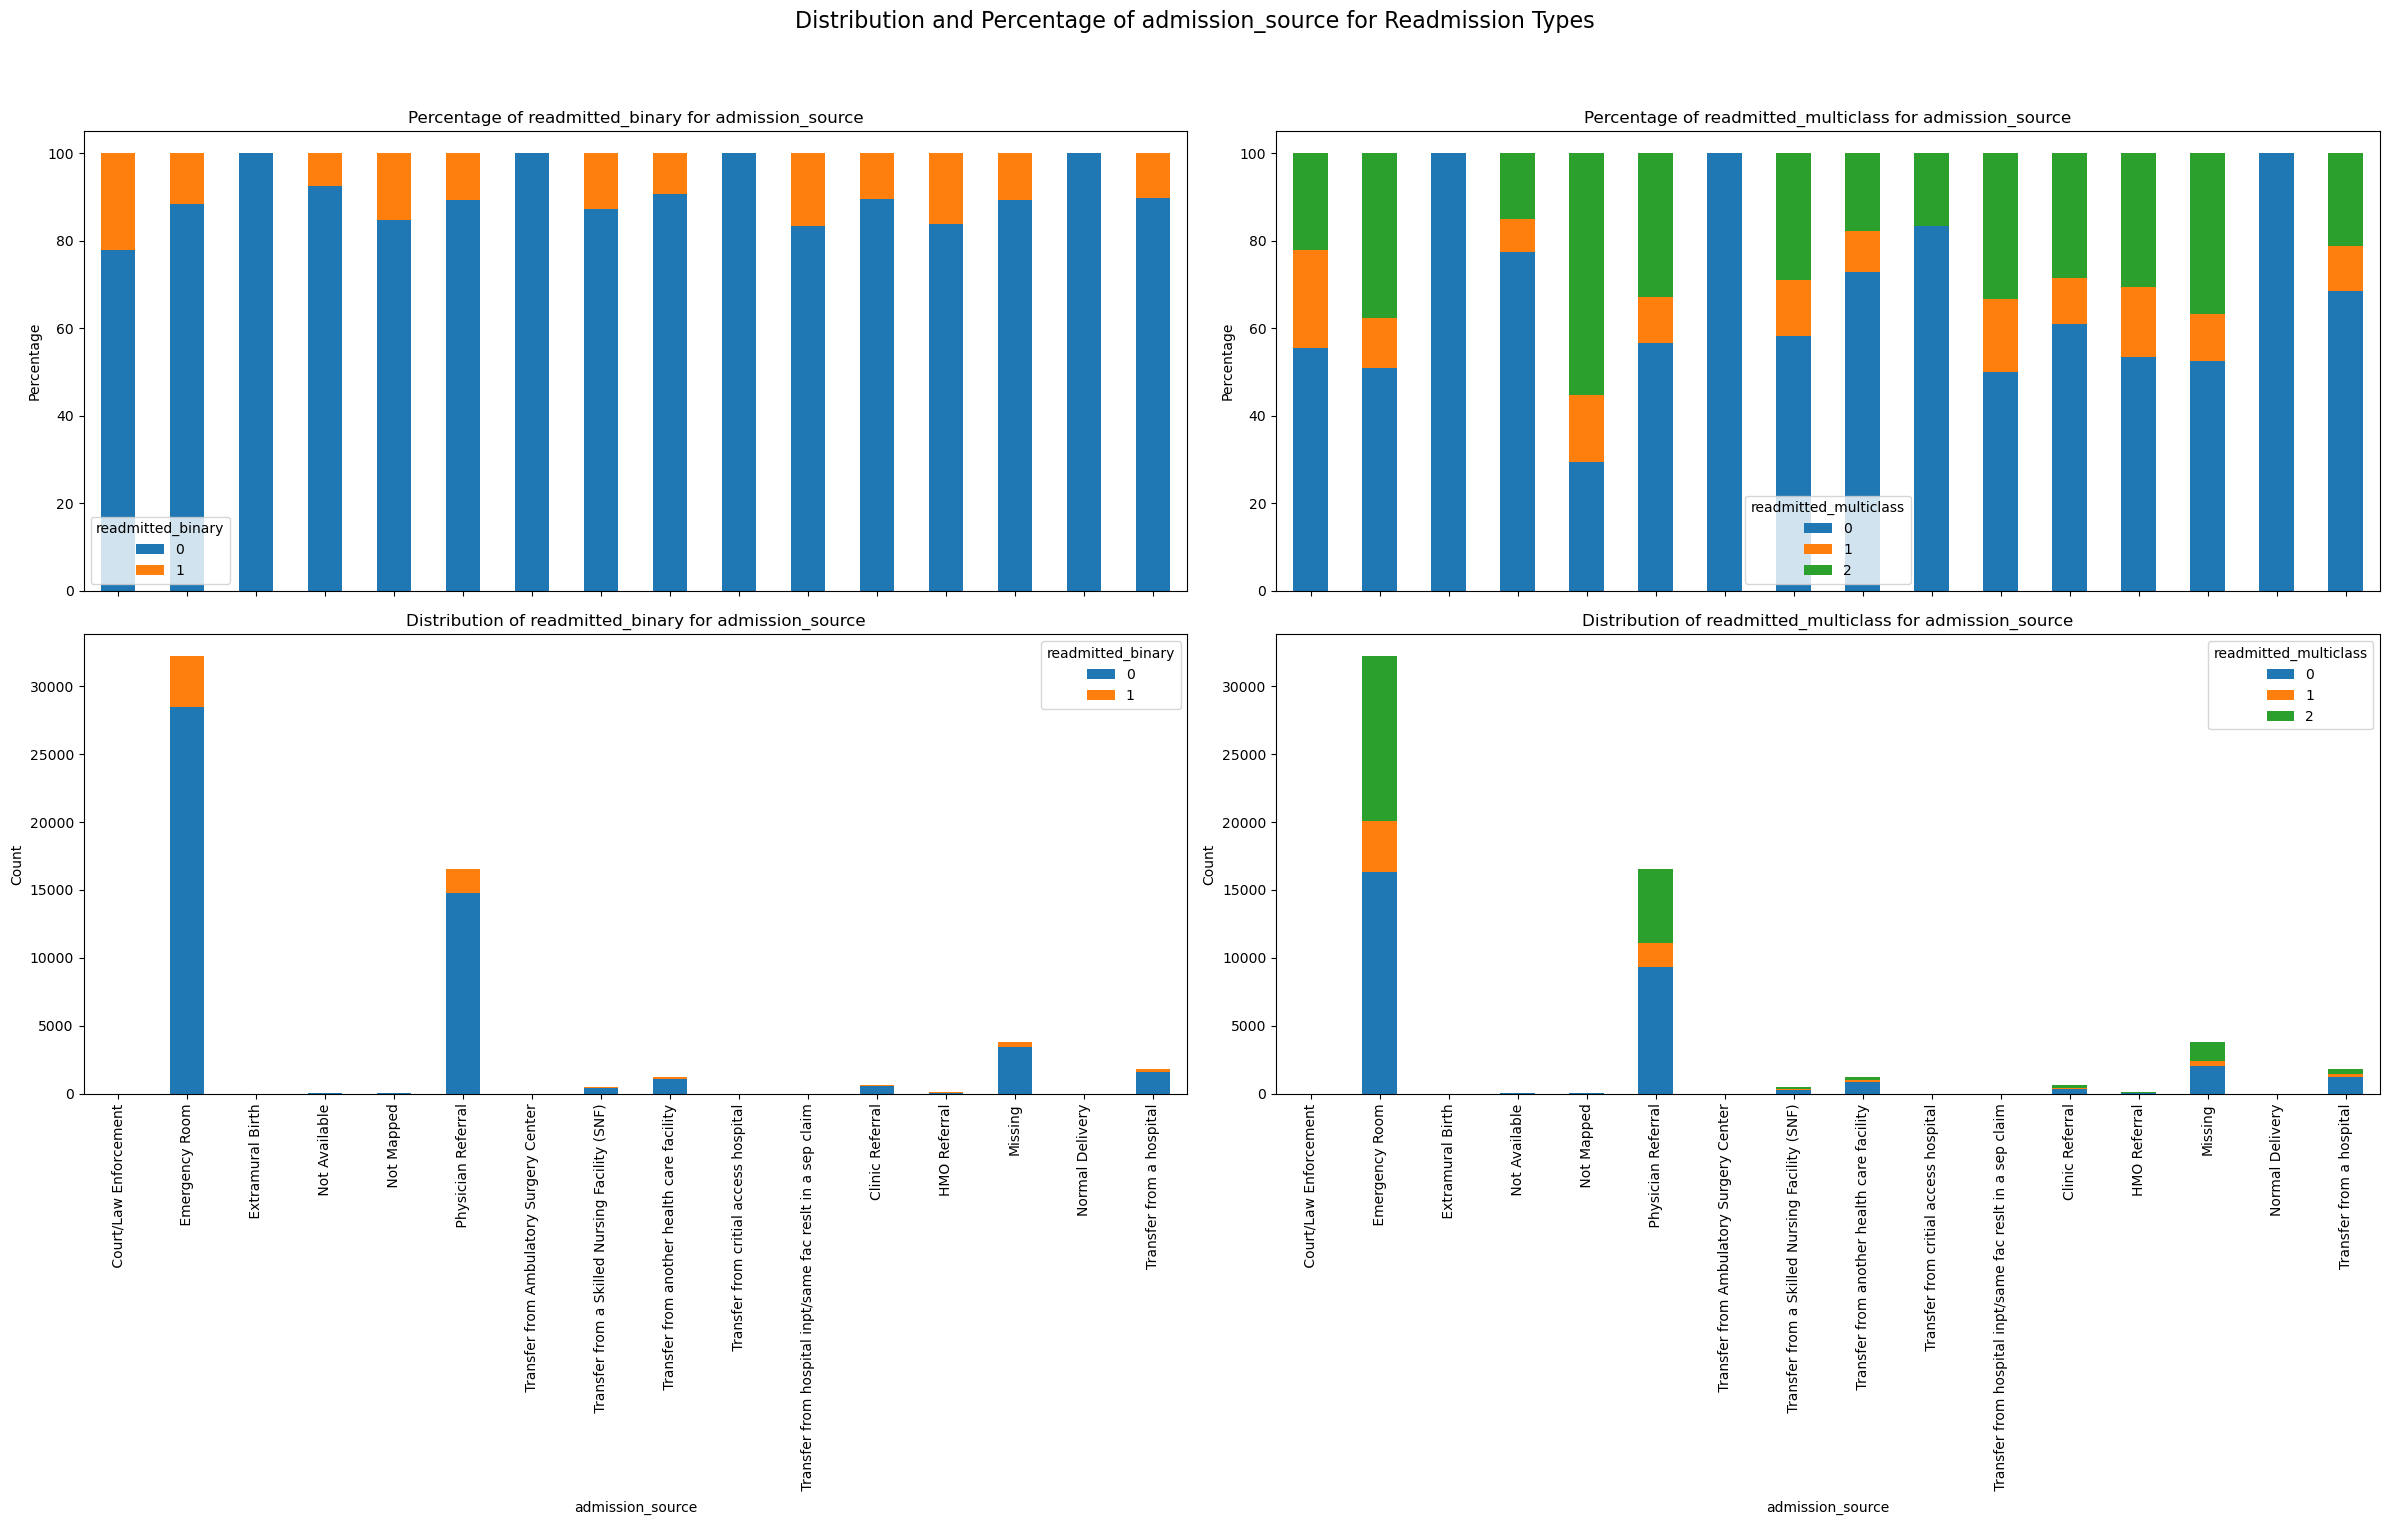

In [76]:
plot_categorical_distribution(data_train, 'admission_source')

In [77]:
data_train.groupby(['admission_source', 'readmitted_binary']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_binary,0,1
admission_source,admission_source,,
Court/Law Enforcement,Court/Law Enforcement,77.777778,22.222222
Emergency Room,Emergency Room,88.404087,11.595913
Extramural Birth,Extramural Birth,100.000000,NaN
Not Available,Not Available,92.500000,7.500000
Not Mapped,Not Mapped,84.705882,15.294118
Physician Referral,Physician Referral,89.392292,10.607708
Transfer from Ambulatory Surgery Center,Transfer from Ambulatory Surgery Center,100.000000,NaN
Transfer from a Skilled Nursing Facility (SNF),Transfer from a Skilled Nursing Facility (SNF),87.311828,12.688172
Transfer from another health care facility,Transfer from another health care facility,90.701468,9.298532


In [78]:
# we used to combine not mapped, not available and missing but since the readmission rates are so different and therefore their predictions will be different, we will keep them seperate.
# What we will do though is to combine the categories that have 0% readmission rate or dimensionality reduction as they all would do same predictions anyway

In [79]:
# combine similar values based on training data
replace_dict = {' Extramural Birth': 'Categories with no readmission', ' Transfer from critial access hospital': 'Categories with no readmission', ' Transfer from Ambulatory Surgery Center': 'Categories with no readmission', 'Normal Delivery': 'Categories with no readmission'}

data_train['admission_source'].replace(replace_dict, inplace=True)
data_val['admission_source'].replace(replace_dict, inplace=True)
data_test['admission_source'].replace(replace_dict, inplace=True)

In [80]:
replace_dict_multi = {' Extramural Birth': 'Categories with no readmission', ' Transfer from Ambulatory Surgery Center': 'Categories with no readmission', 'Normal Delivery': 'Categories with no readmission'}

data_train_multi['admission_source'].replace(replace_dict_multi, inplace=True)
data_val_multi['admission_source'].replace(replace_dict_multi, inplace=True)
data_test_multi['admission_source'].replace(replace_dict_multi, inplace=True)

#### length_of_stay_in_hospital

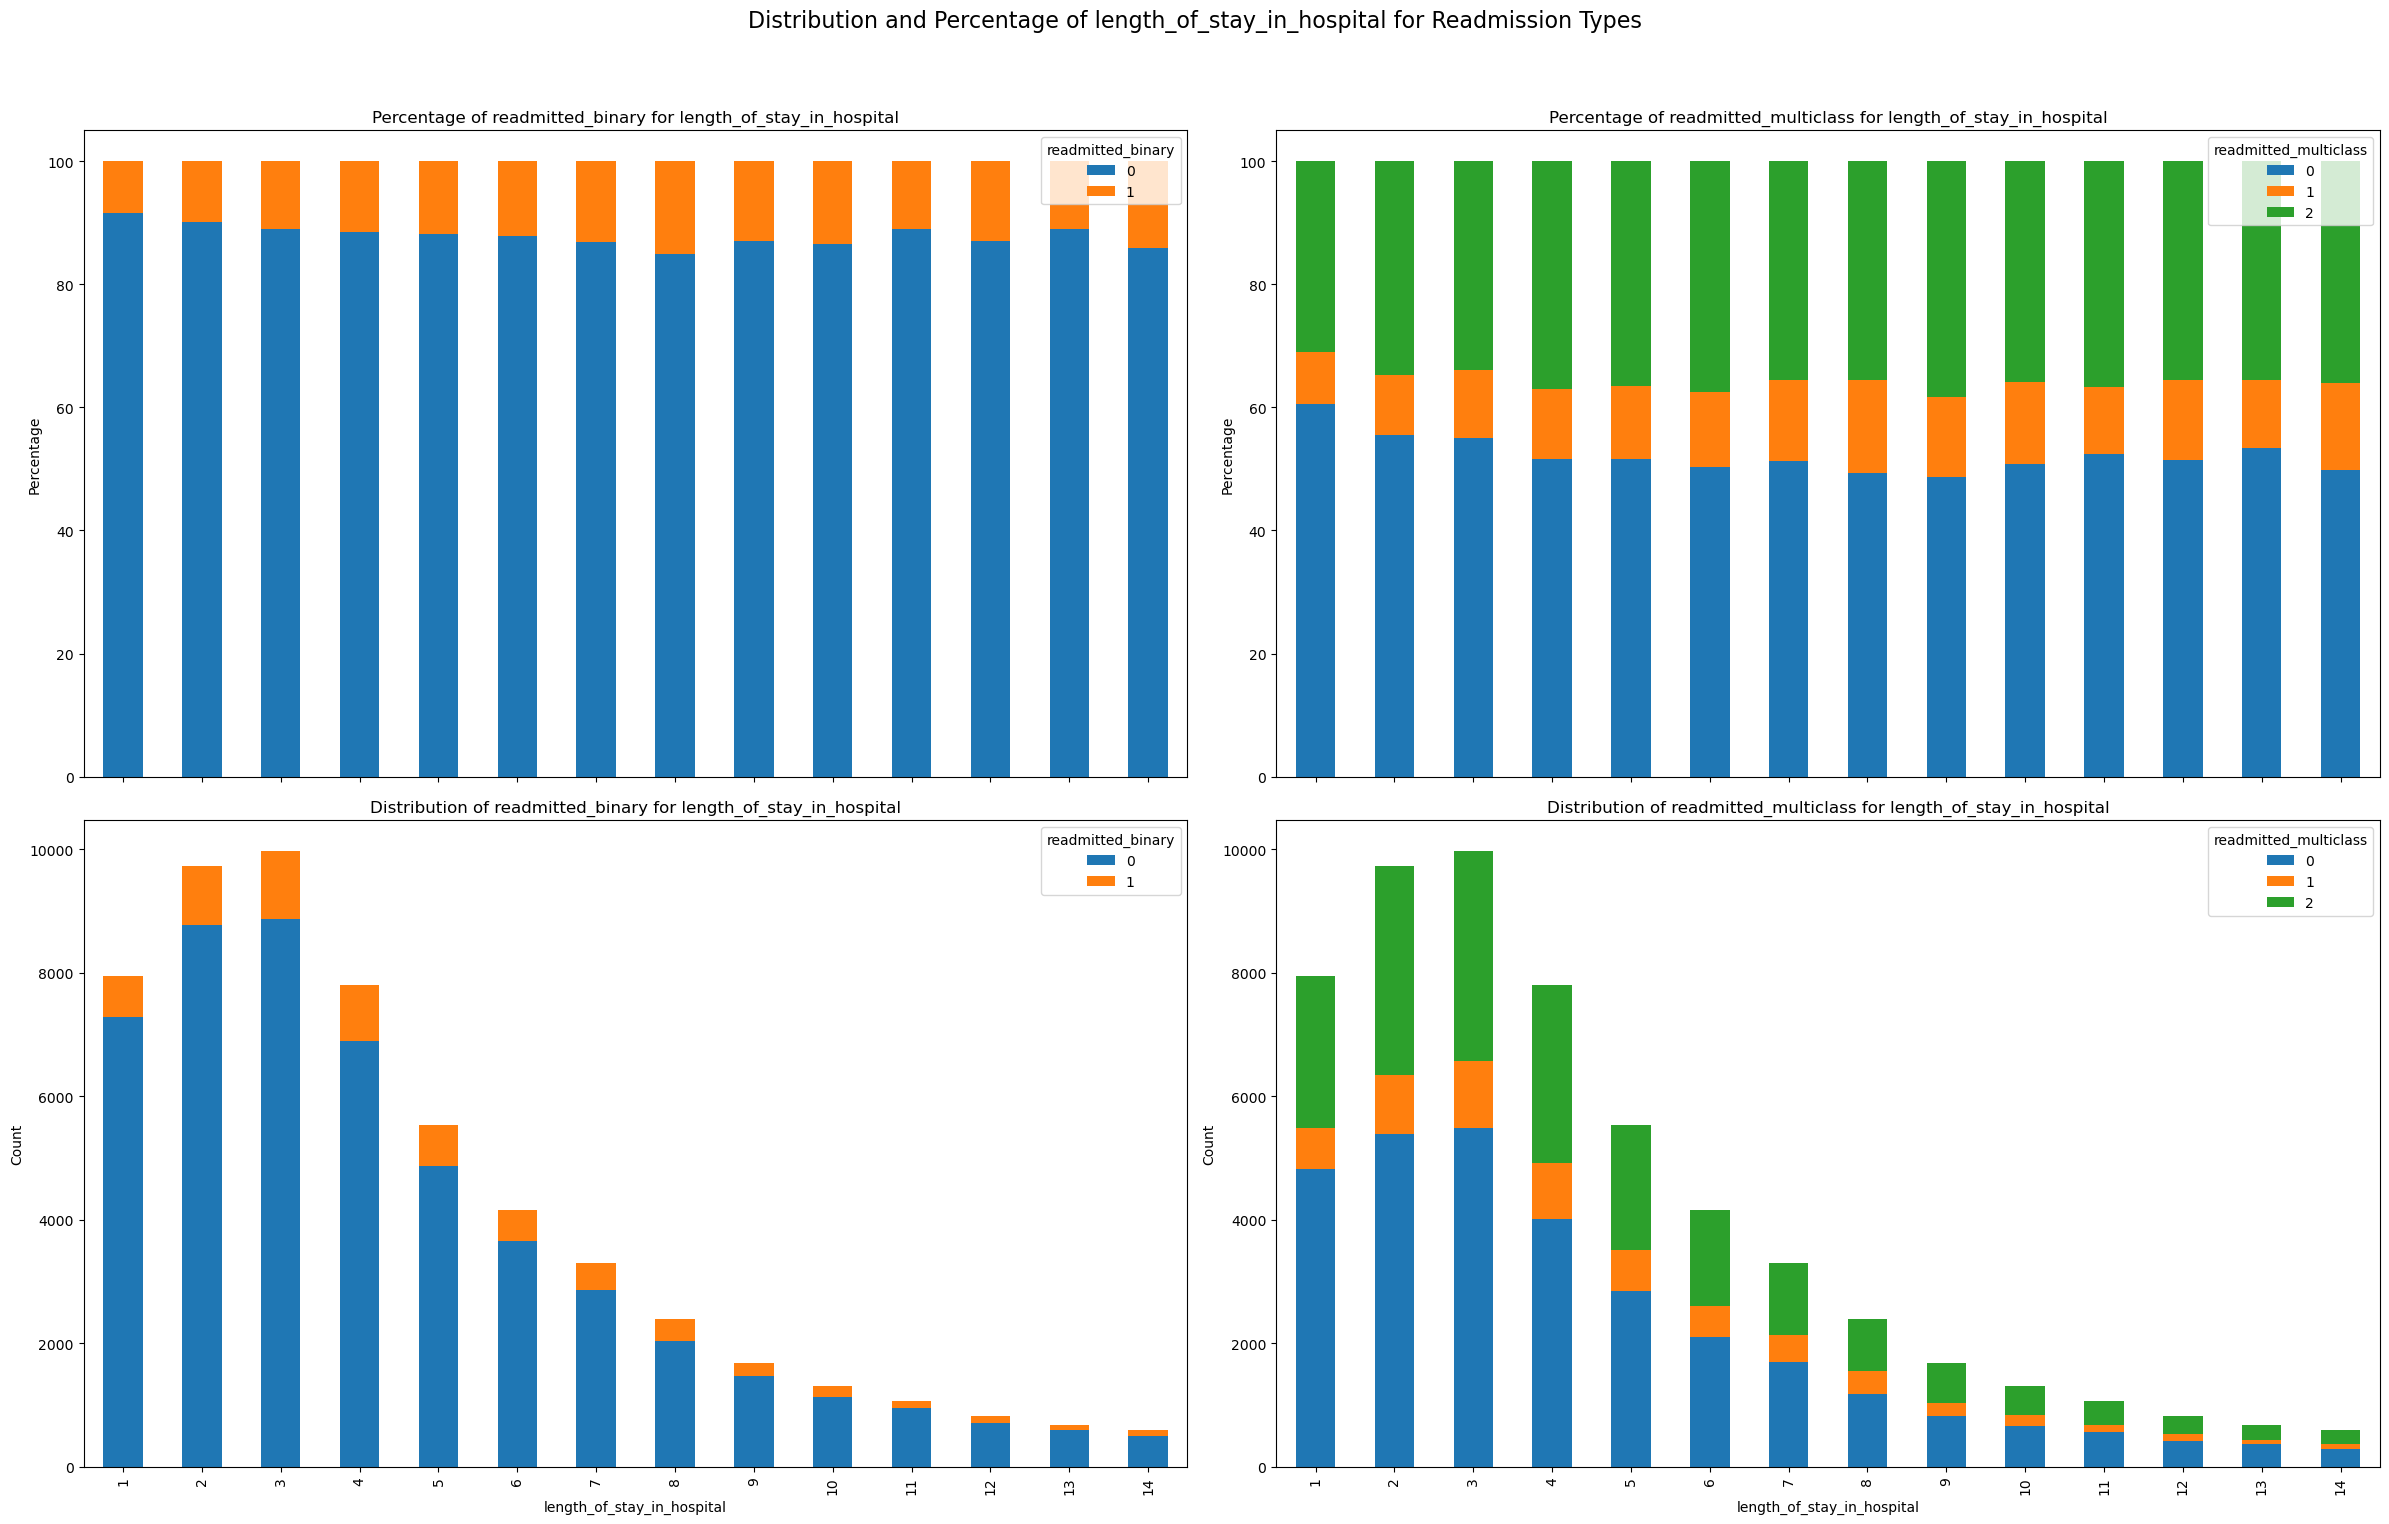

In [81]:
plot_categorical_distribution(data_train, 'length_of_stay_in_hospital')

In [82]:
# we keep as it is, no real outliers

#### number_lab_tests

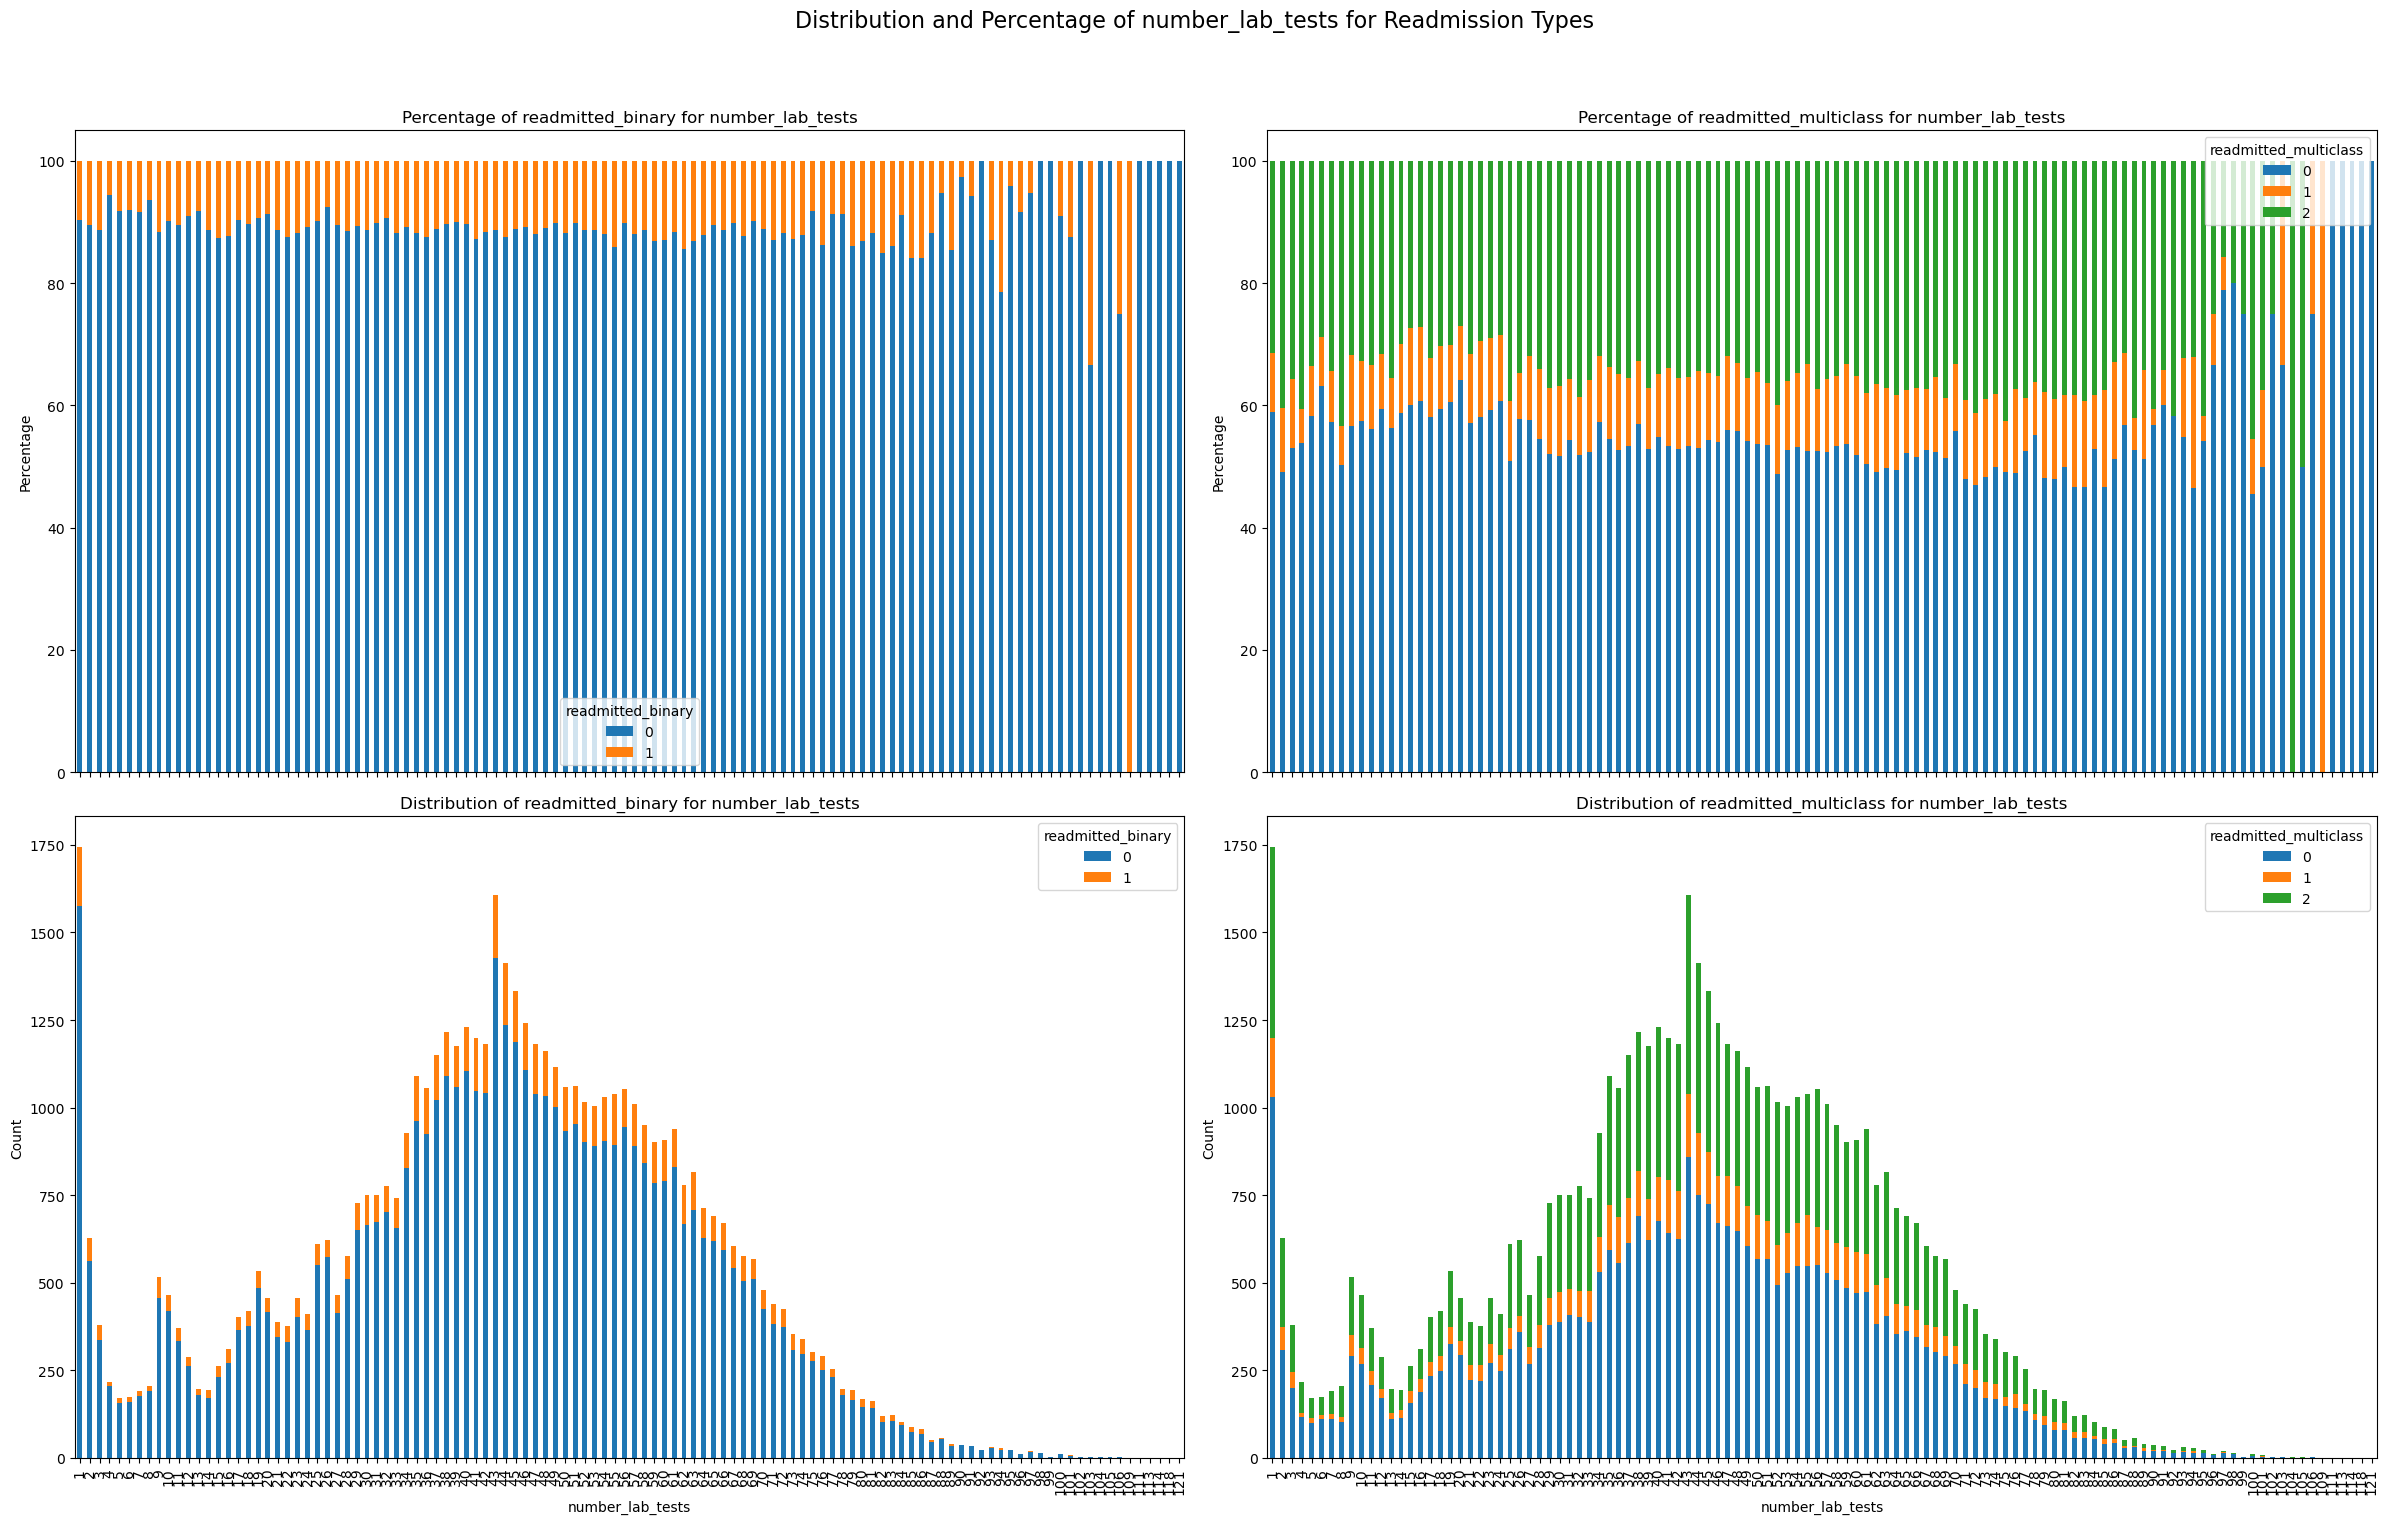

In [83]:
plot_categorical_distribution(data_train, 'number_lab_tests')

In [84]:
# give me only the column number_lab_tests and readmission_binary
data_train[['number_lab_tests', 'readmitted_binary']]
# show me only the 10 highest number_lab_tests
data_train[['number_lab_tests', 'readmitted_binary']].sort_values(by='number_lab_tests', ascending=False).head(10)


,number_lab_tests,readmitted_binary
encounter_id,,
741458,121,0
766865,118,0
932353,114,0
676089,113,0
297812,111,0
198036,109,1
855657,106,0
866705,106,1
647726,106,0


In [85]:
# clip outliers at 111 for number_lab_tests as we will only have 0 readmission after 111 tests
data_train['number_lab_tests'] = data_train['number_lab_tests'].clip(upper=111)
data_val['number_lab_tests'] = data_val['number_lab_tests'].clip(upper=111)
data_test['number_lab_tests'] = data_test['number_lab_tests'].clip(upper=111)

In [86]:
# data_train_multi['number_lab_tests'] = data_train_multi['number_lab_tests'].clip(upper=111)
data_val_multi['number_lab_tests'] = data_val_multi['number_lab_tests'].clip(upper=111)
data_test_multi['number_lab_tests'] = data_test_multi['number_lab_tests'].clip(upper=111)

#### non_lab_procedures

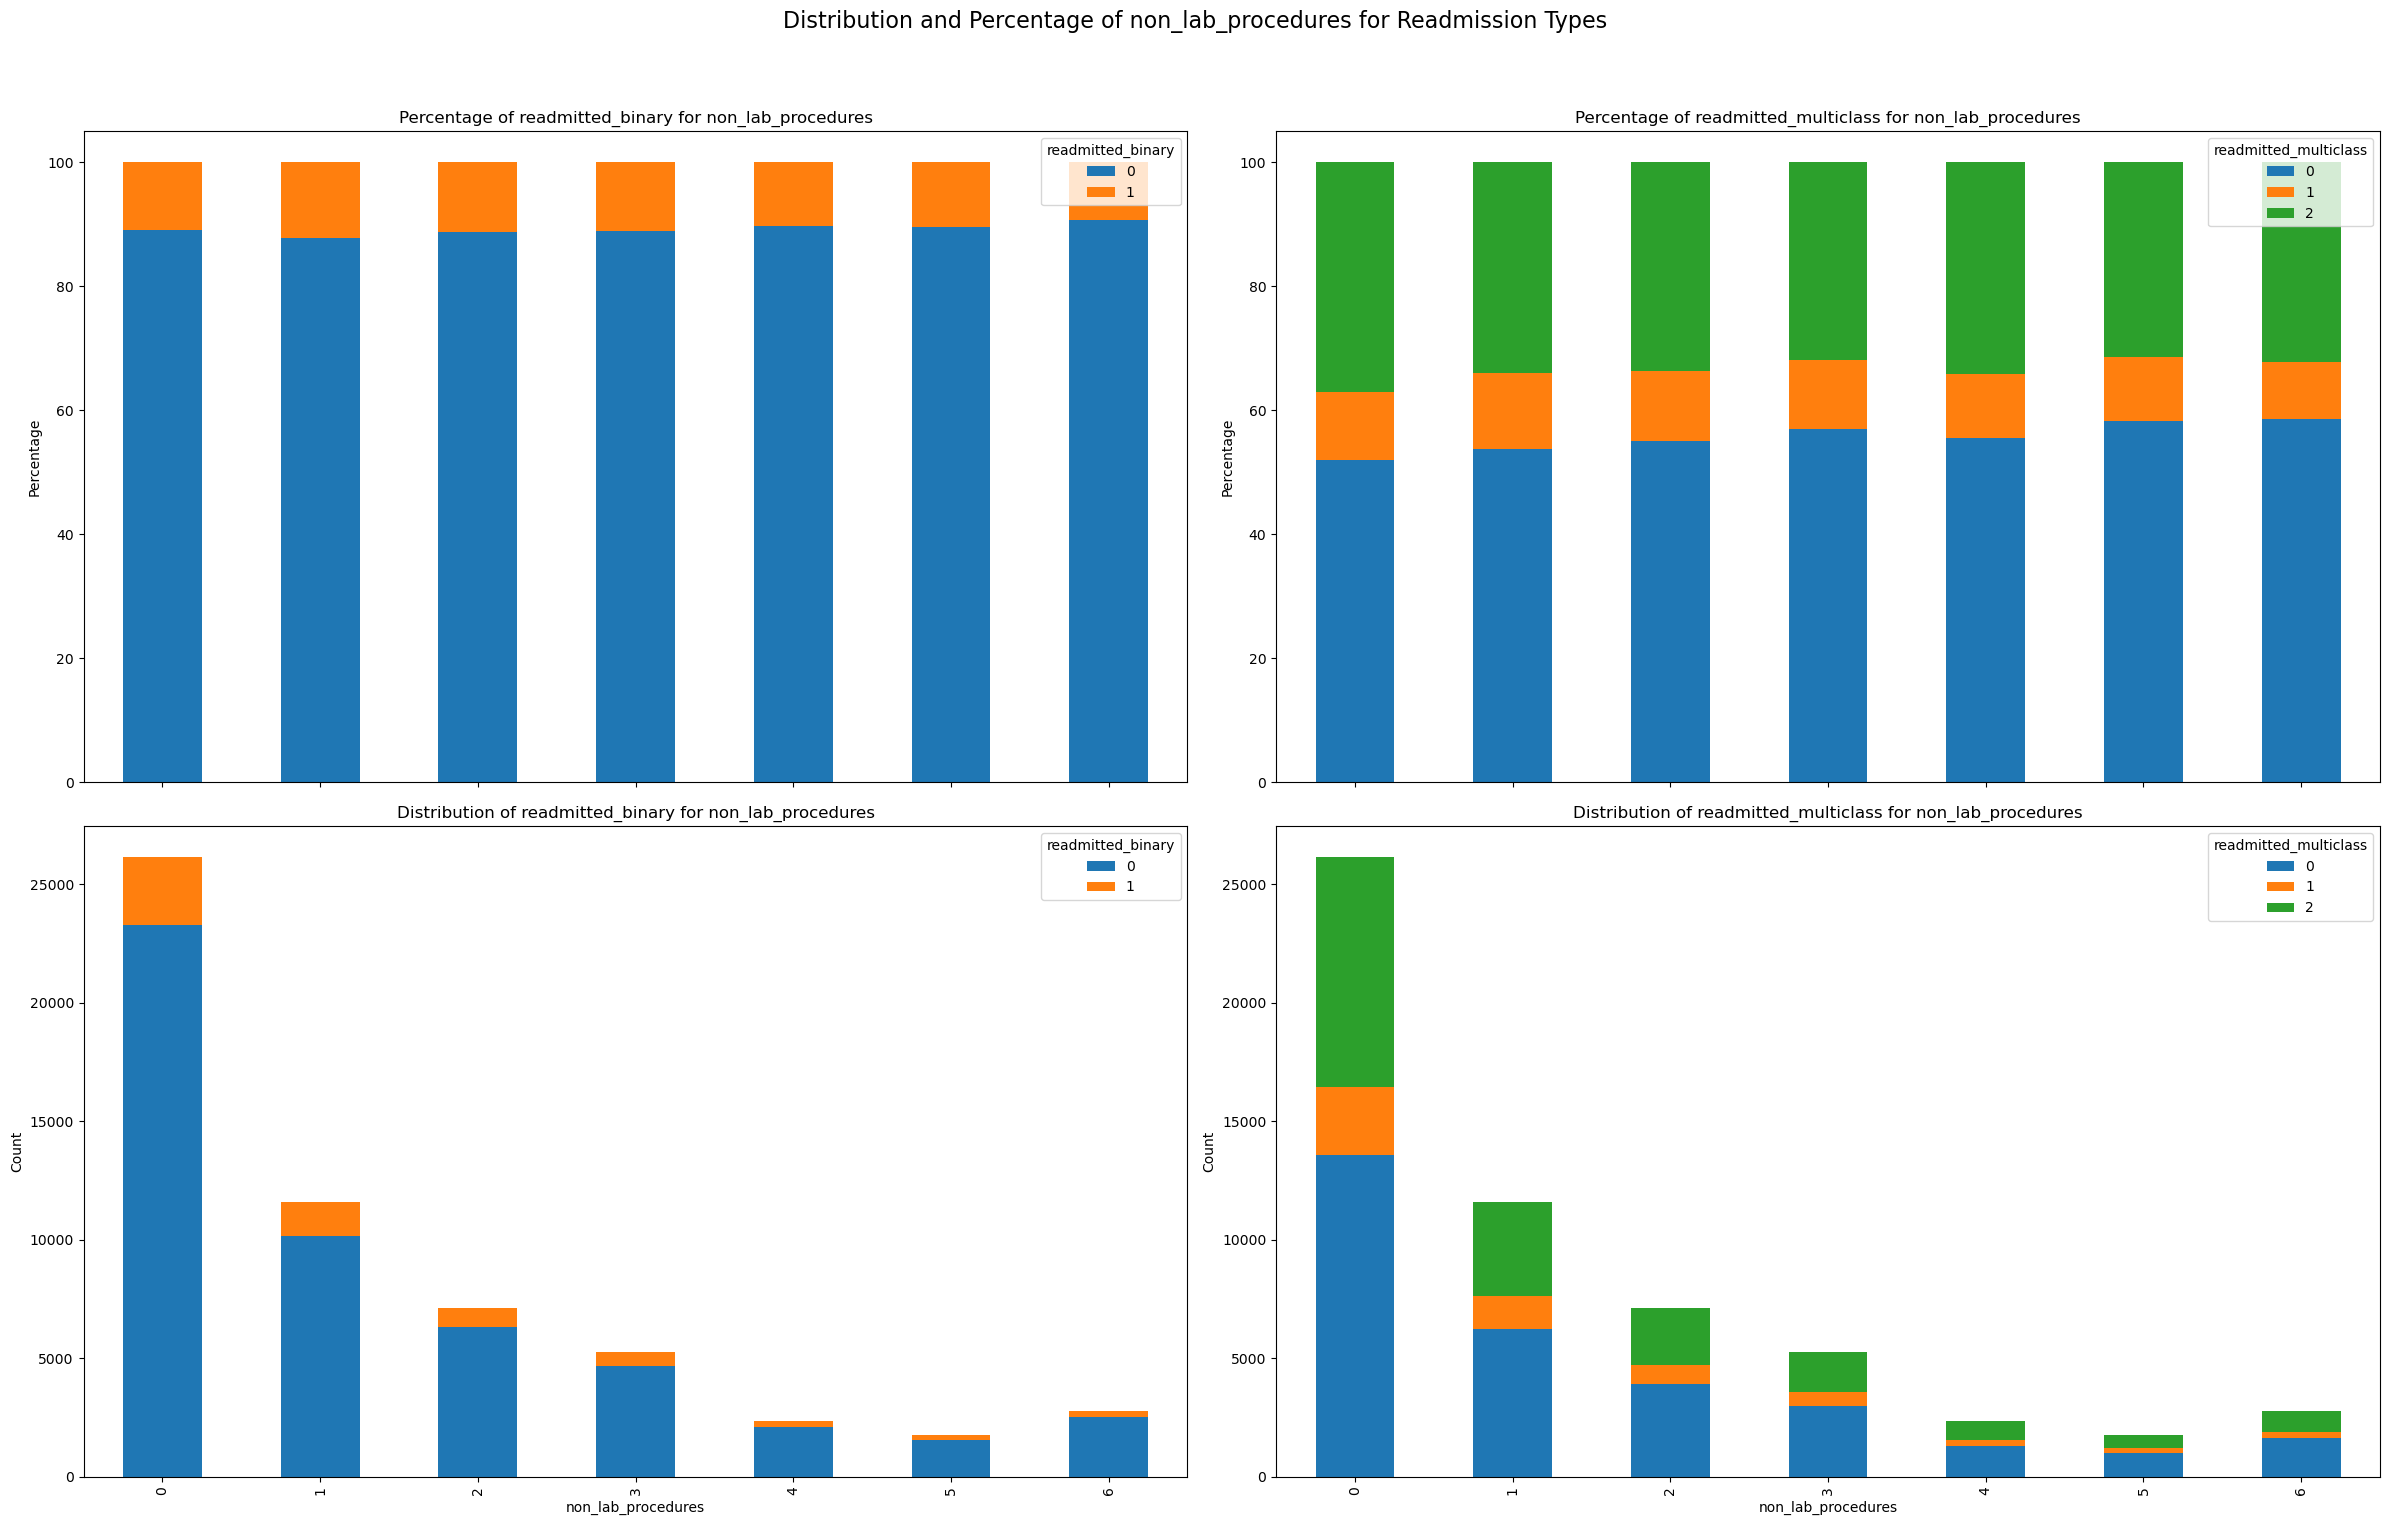

In [87]:
plot_categorical_distribution(data_train, 'non_lab_procedures')

In [88]:
# keep as it is for now

#### number_of_medications

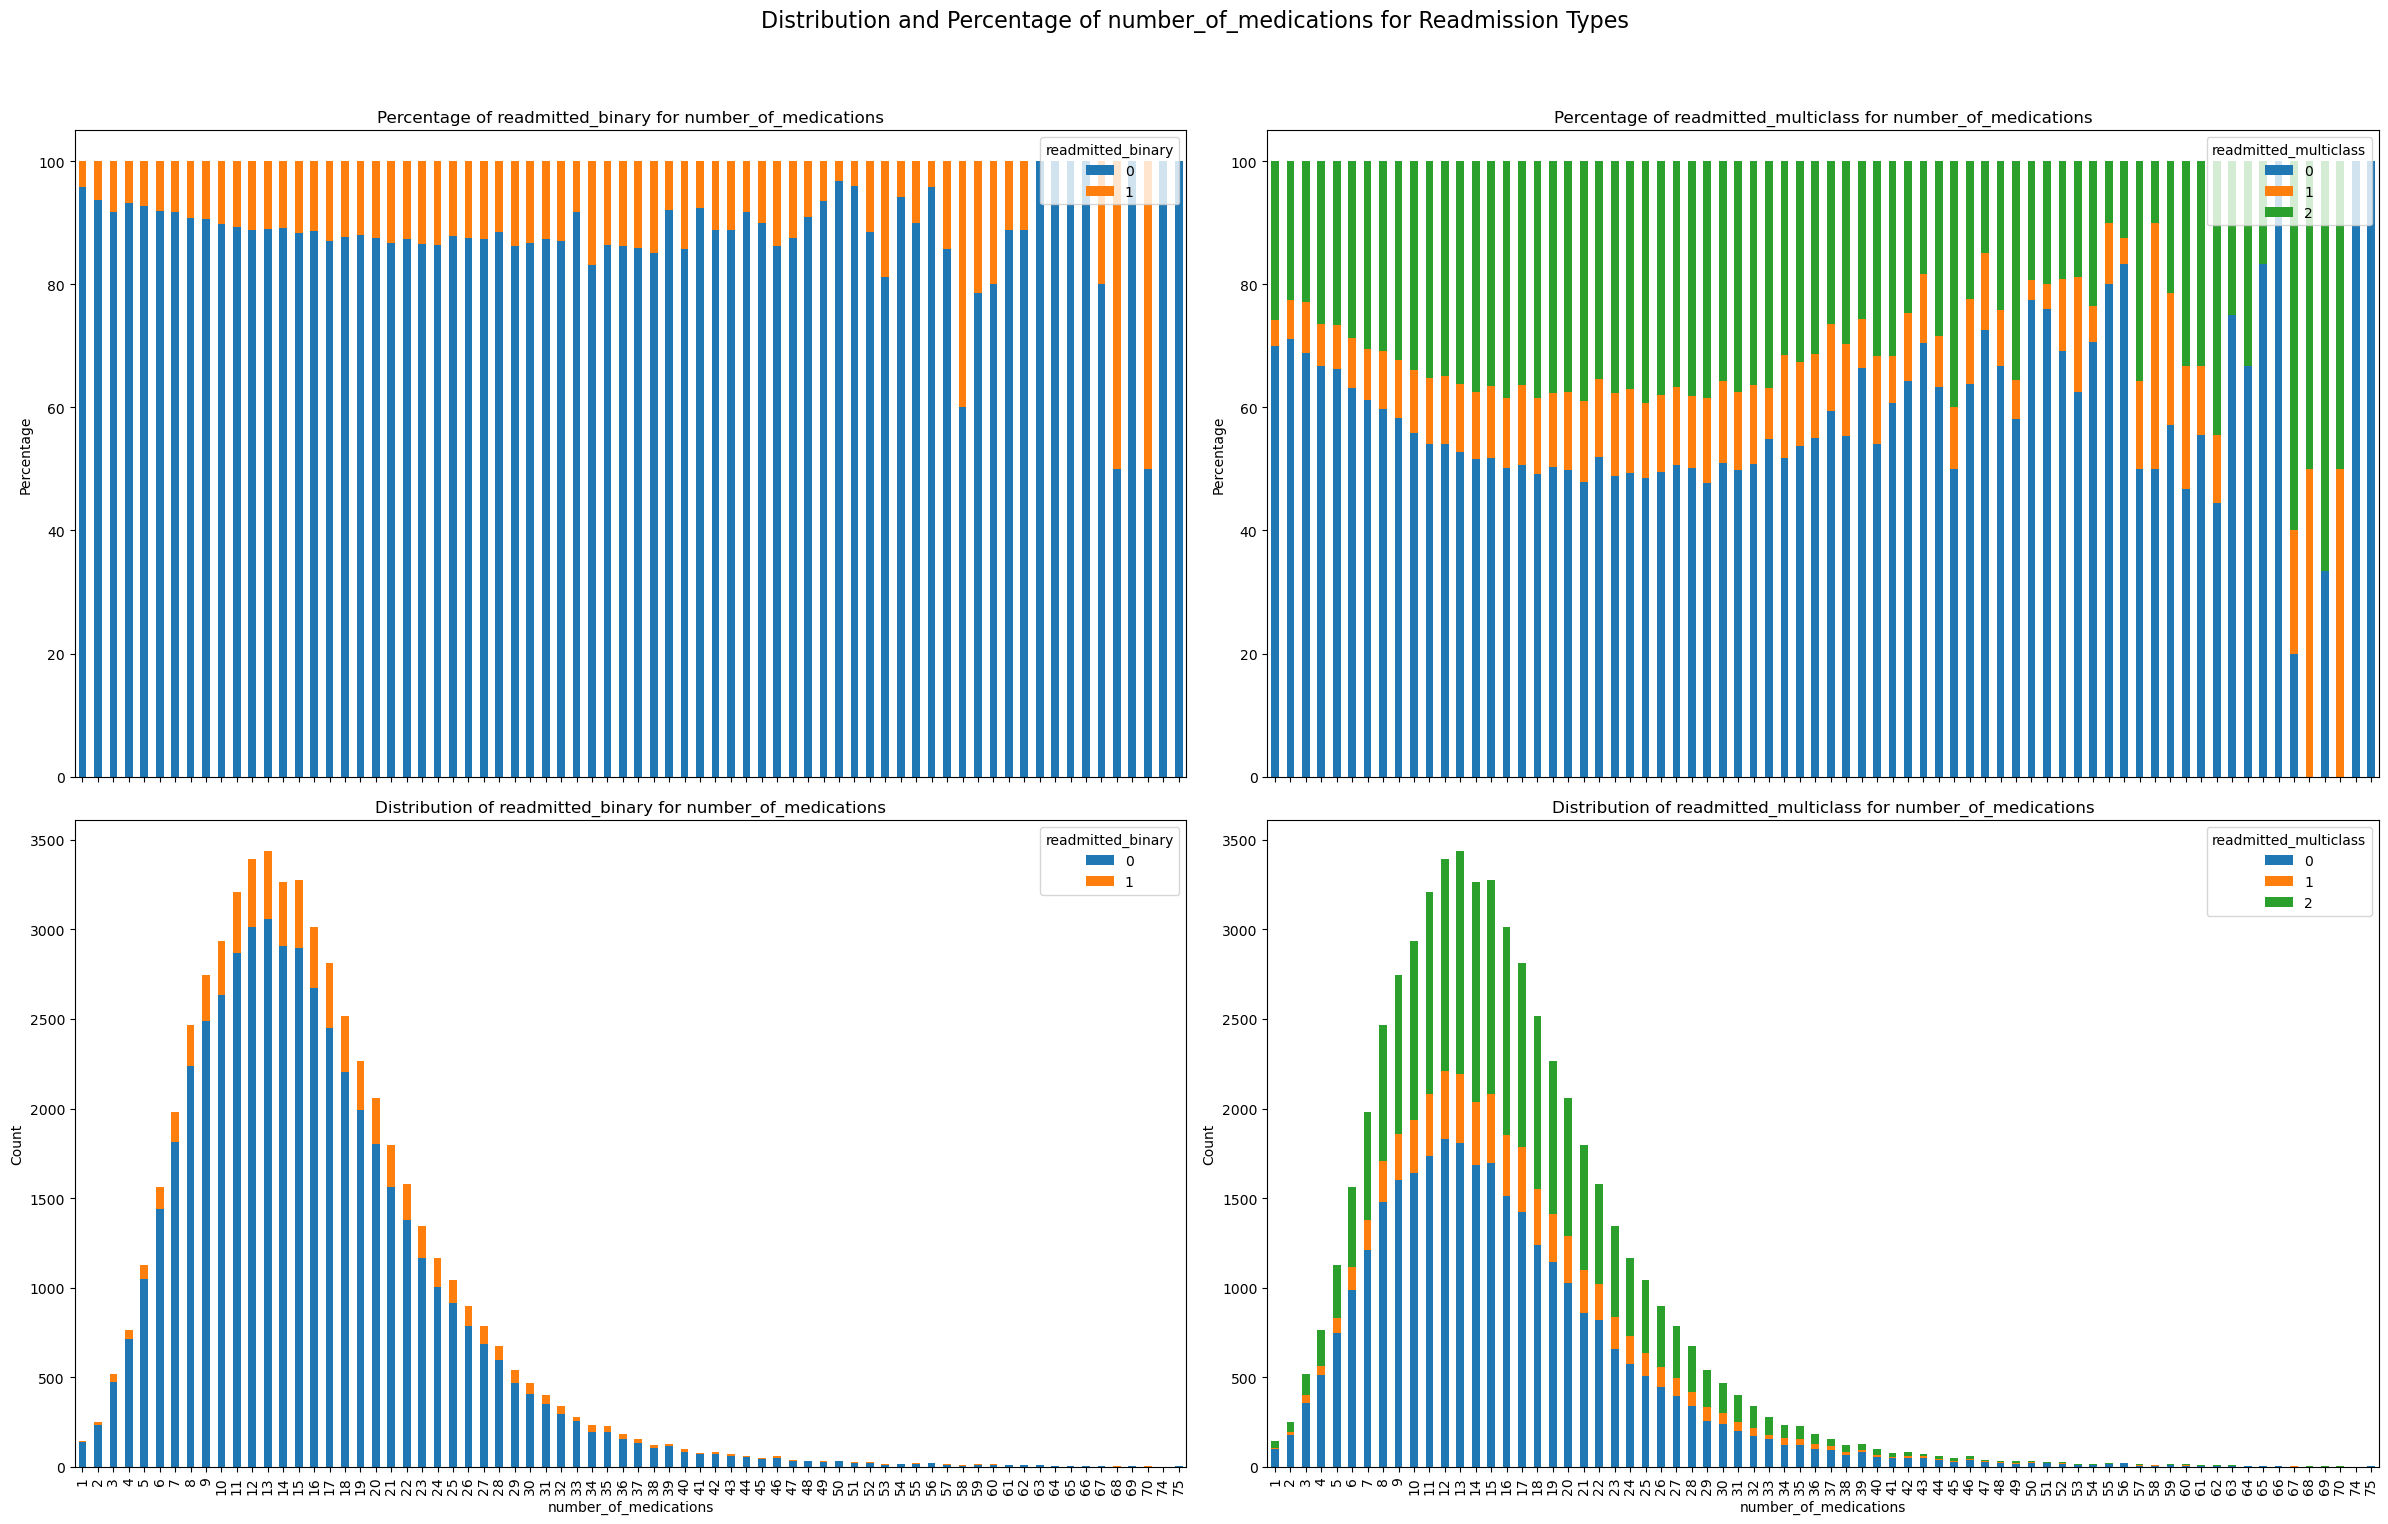

In [89]:
plot_categorical_distribution(data_train, 'number_of_medications')

In [90]:
# clip at 62 for number_of_medications as we will only have 0 readmission after 62 medications
data_train['number_of_medications'] = data_train['number_of_medications'].clip(upper=74)
data_val['number_of_medications'] = data_val['number_of_medications'].clip(upper=74)
data_test['number_of_medications'] = data_test['number_of_medications'].clip(upper=74)

In [91]:
data_train_multi['number_of_medications'] = data_train_multi['number_of_medications'].clip(upper=74)
data_val_multi['number_of_medications'] = data_val_multi['number_of_medications'].clip(upper=74)
data_test_multi['number_of_medications'] = data_test_multi['number_of_medications'].clip(upper=74)

#### primary_diagnosis, secondary_diagnosis, additional_diagnosis

In [92]:
# Mapping function
def map_icd9_code(code):
    code_str = str(code)  # Convert code to string

    try:
        code_int = int(float(code_str))  # Convert to integer if possible
    except ValueError:
        code_int = None  # Keep the code as None if it's not a number

    if code_int is not None:
        if 1 <= code_int <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= code_int <= 239:
            return 'Neoplasms'
        elif 240 <= code_int <= 279:
            return 'Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders'
        elif 280 <= code_int <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= code_int <= 319:
            return 'Mental Disorders'
        elif 320 <= code_int <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= code_int <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= code_int <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= code_int <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= code_int <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= code_int <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= code_int <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= code_int <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= code_int <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code_int <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= code_int <= 799:
            return 'Symptoms, Signs, and Ill-Defined Conditions'
        elif 800 <= code_int <= 999:
            return 'Injury and Poisoning'
    else:
        if code_str.startswith('E') or code_str.startswith('V'):
            return 'external causes of injury and supplemental classification'
        # Handle other alphanumeric codes if necessary

    return 'Unknown Category'  # Default category for anything else

In [93]:
data_train['primary_diagnosis'] = data_train['primary_diagnosis'].apply(map_icd9_code)
data_val['primary_diagnosis'] = data_val['primary_diagnosis'].apply(map_icd9_code)
data_test['primary_diagnosis'] = data_test['primary_diagnosis'].apply(map_icd9_code)

In [94]:
data_train['secondary_diagnosis'] = data_train['secondary_diagnosis'].apply(map_icd9_code)
data_val['secondary_diagnosis'] = data_val['secondary_diagnosis'].apply(map_icd9_code)
data_test['secondary_diagnosis'] = data_test['secondary_diagnosis'].apply(map_icd9_code)

In [95]:
data_train['additional_diagnosis'] = data_train['additional_diagnosis'].apply(map_icd9_code)
data_val['additional_diagnosis'] = data_val['additional_diagnosis'].apply(map_icd9_code)
data_test['additional_diagnosis'] = data_test['additional_diagnosis'].apply(map_icd9_code)

In [96]:
data_train_multi['primary_diagnosis'] = data_train_multi['primary_diagnosis'].apply(map_icd9_code)
data_val_multi['primary_diagnosis'] = data_val_multi['primary_diagnosis'].apply(map_icd9_code)
data_test_multi['primary_diagnosis'] = data_test_multi['primary_diagnosis'].apply(map_icd9_code)

data_train_multi['secondary_diagnosis'] = data_train_multi['secondary_diagnosis'].apply(map_icd9_code)
data_val_multi['secondary_diagnosis'] = data_val_multi['secondary_diagnosis'].apply(map_icd9_code)
data_test_multi['secondary_diagnosis'] = data_test_multi['secondary_diagnosis'].apply(map_icd9_code)

data_train_multi['additional_diagnosis'] = data_train_multi['additional_diagnosis'].apply(map_icd9_code)
data_val_multi['additional_diagnosis'] = data_val_multi['additional_diagnosis'].apply(map_icd9_code)
data_test_multi['additional_diagnosis'] = data_test_multi['additional_diagnosis'].apply(map_icd9_code)

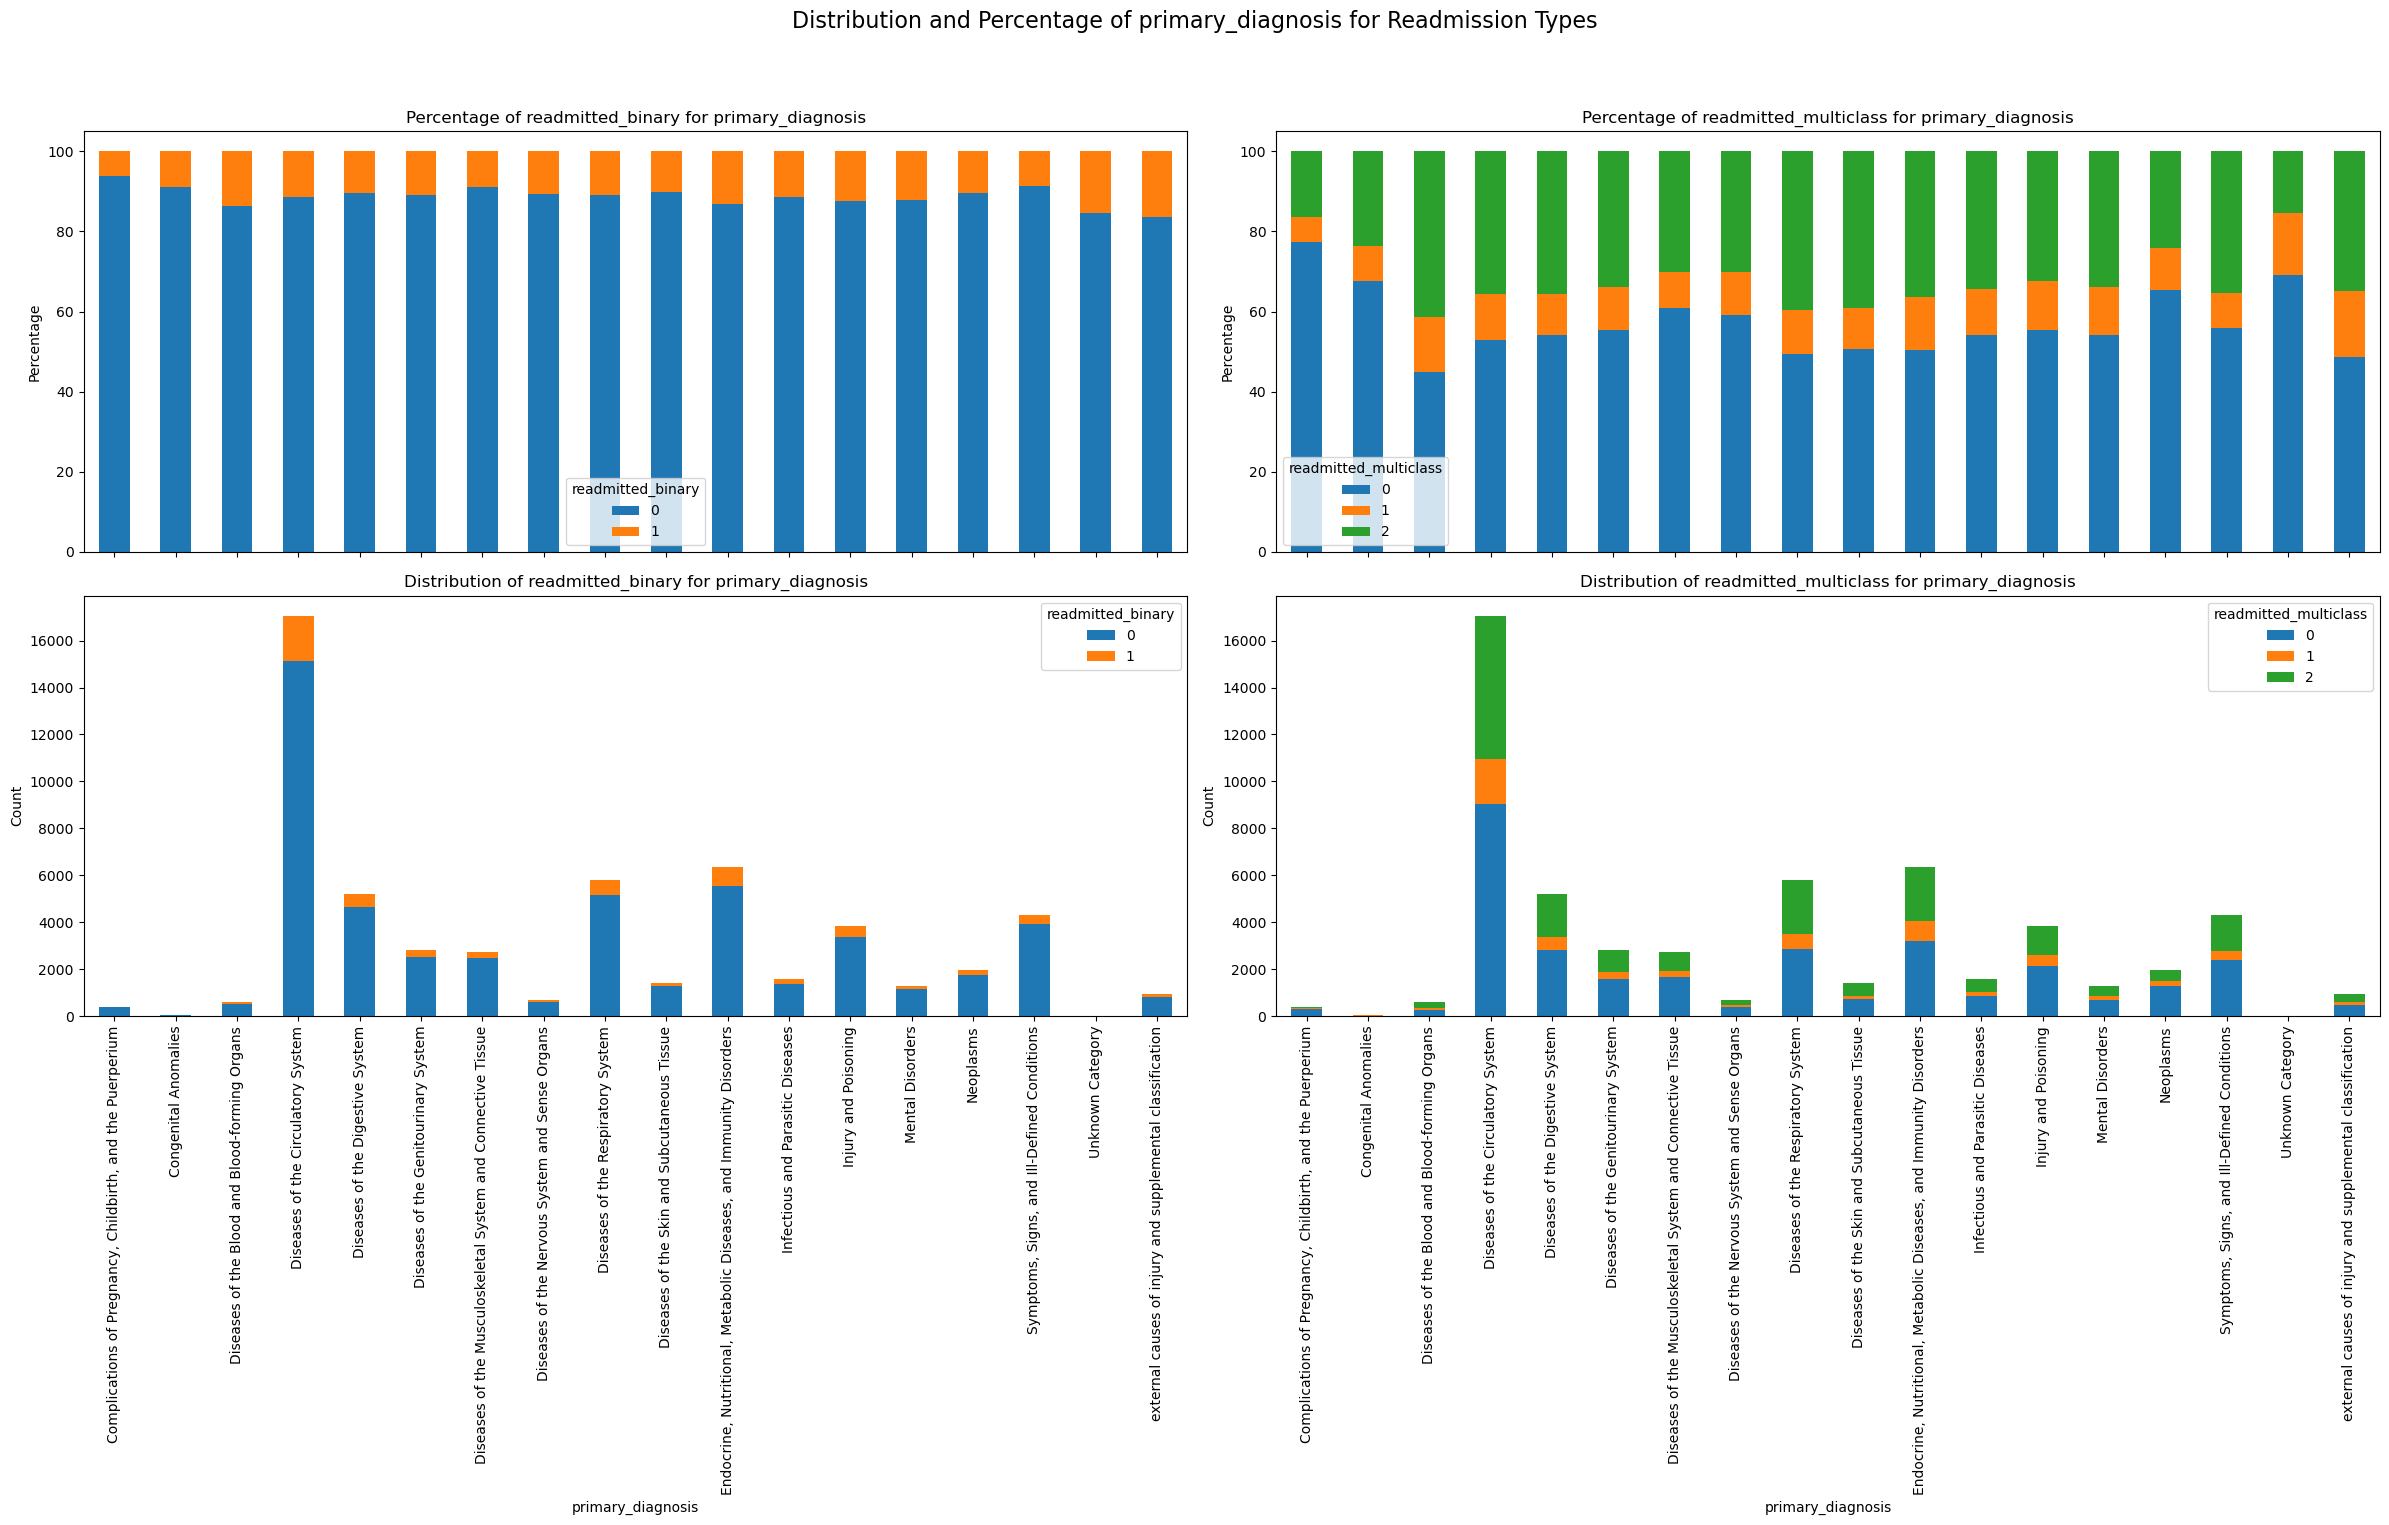

In [97]:
plot_categorical_distribution(data_train, 'primary_diagnosis')

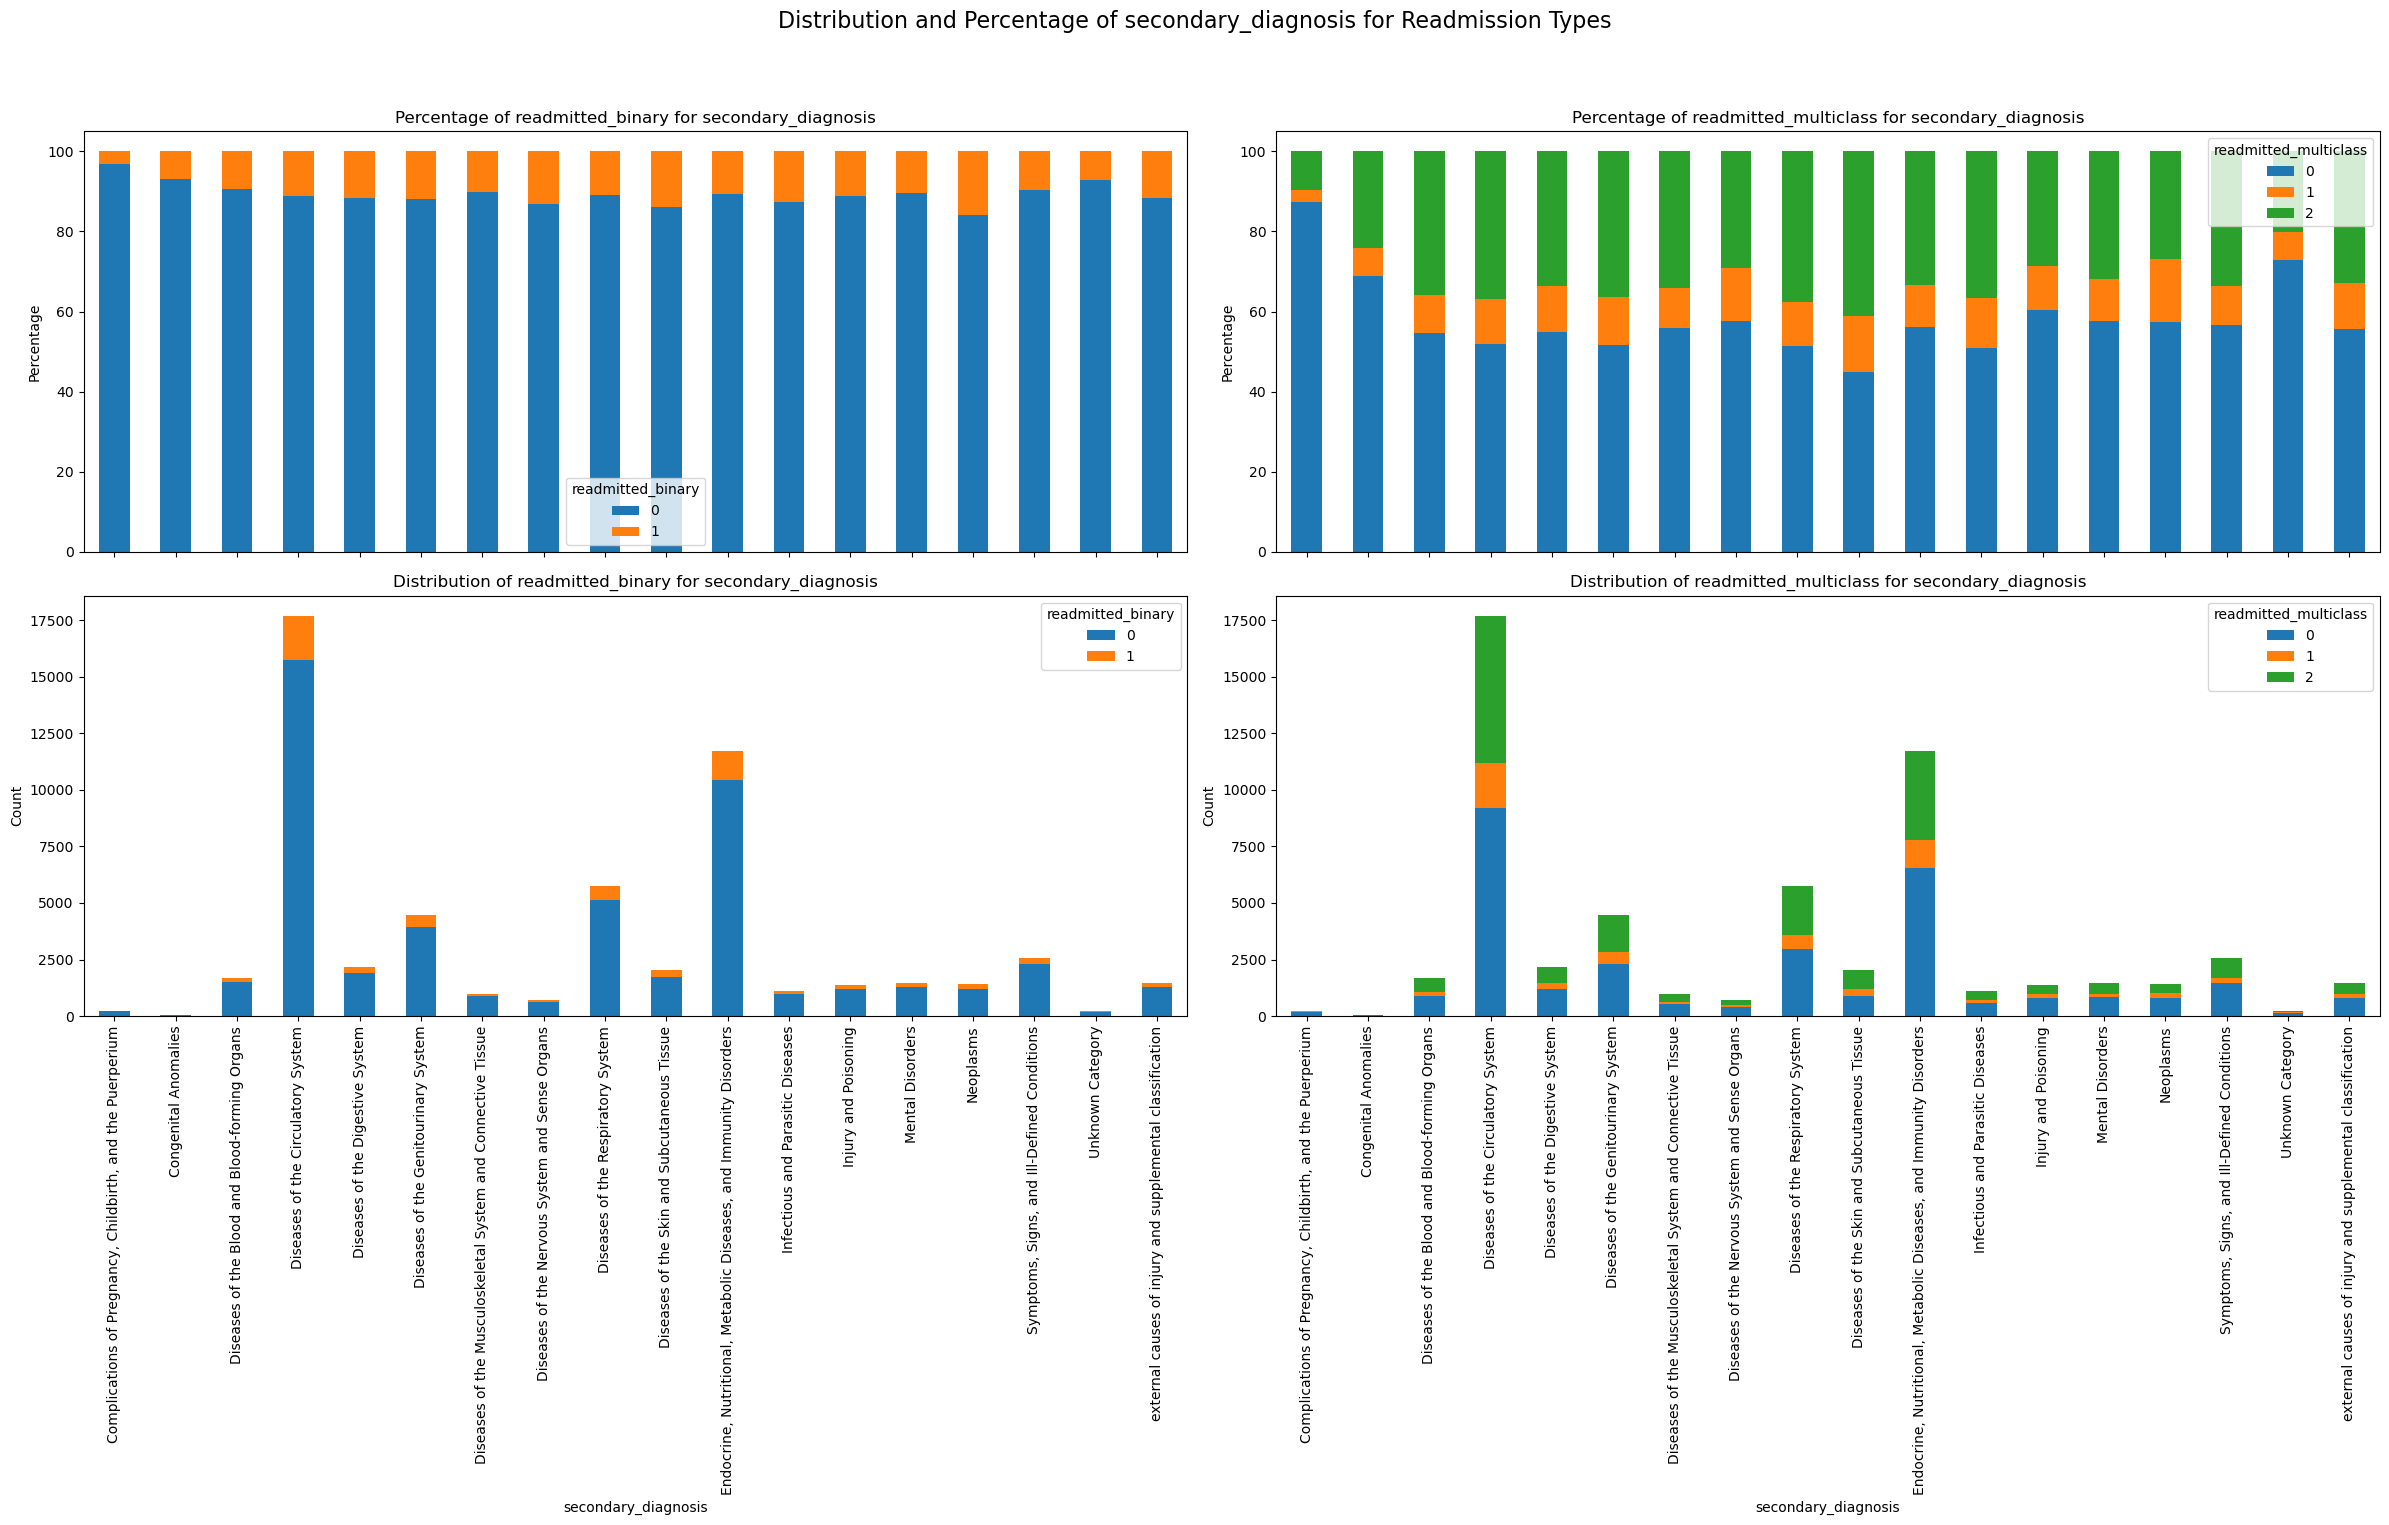

In [98]:
plot_categorical_distribution(data_train, 'secondary_diagnosis')

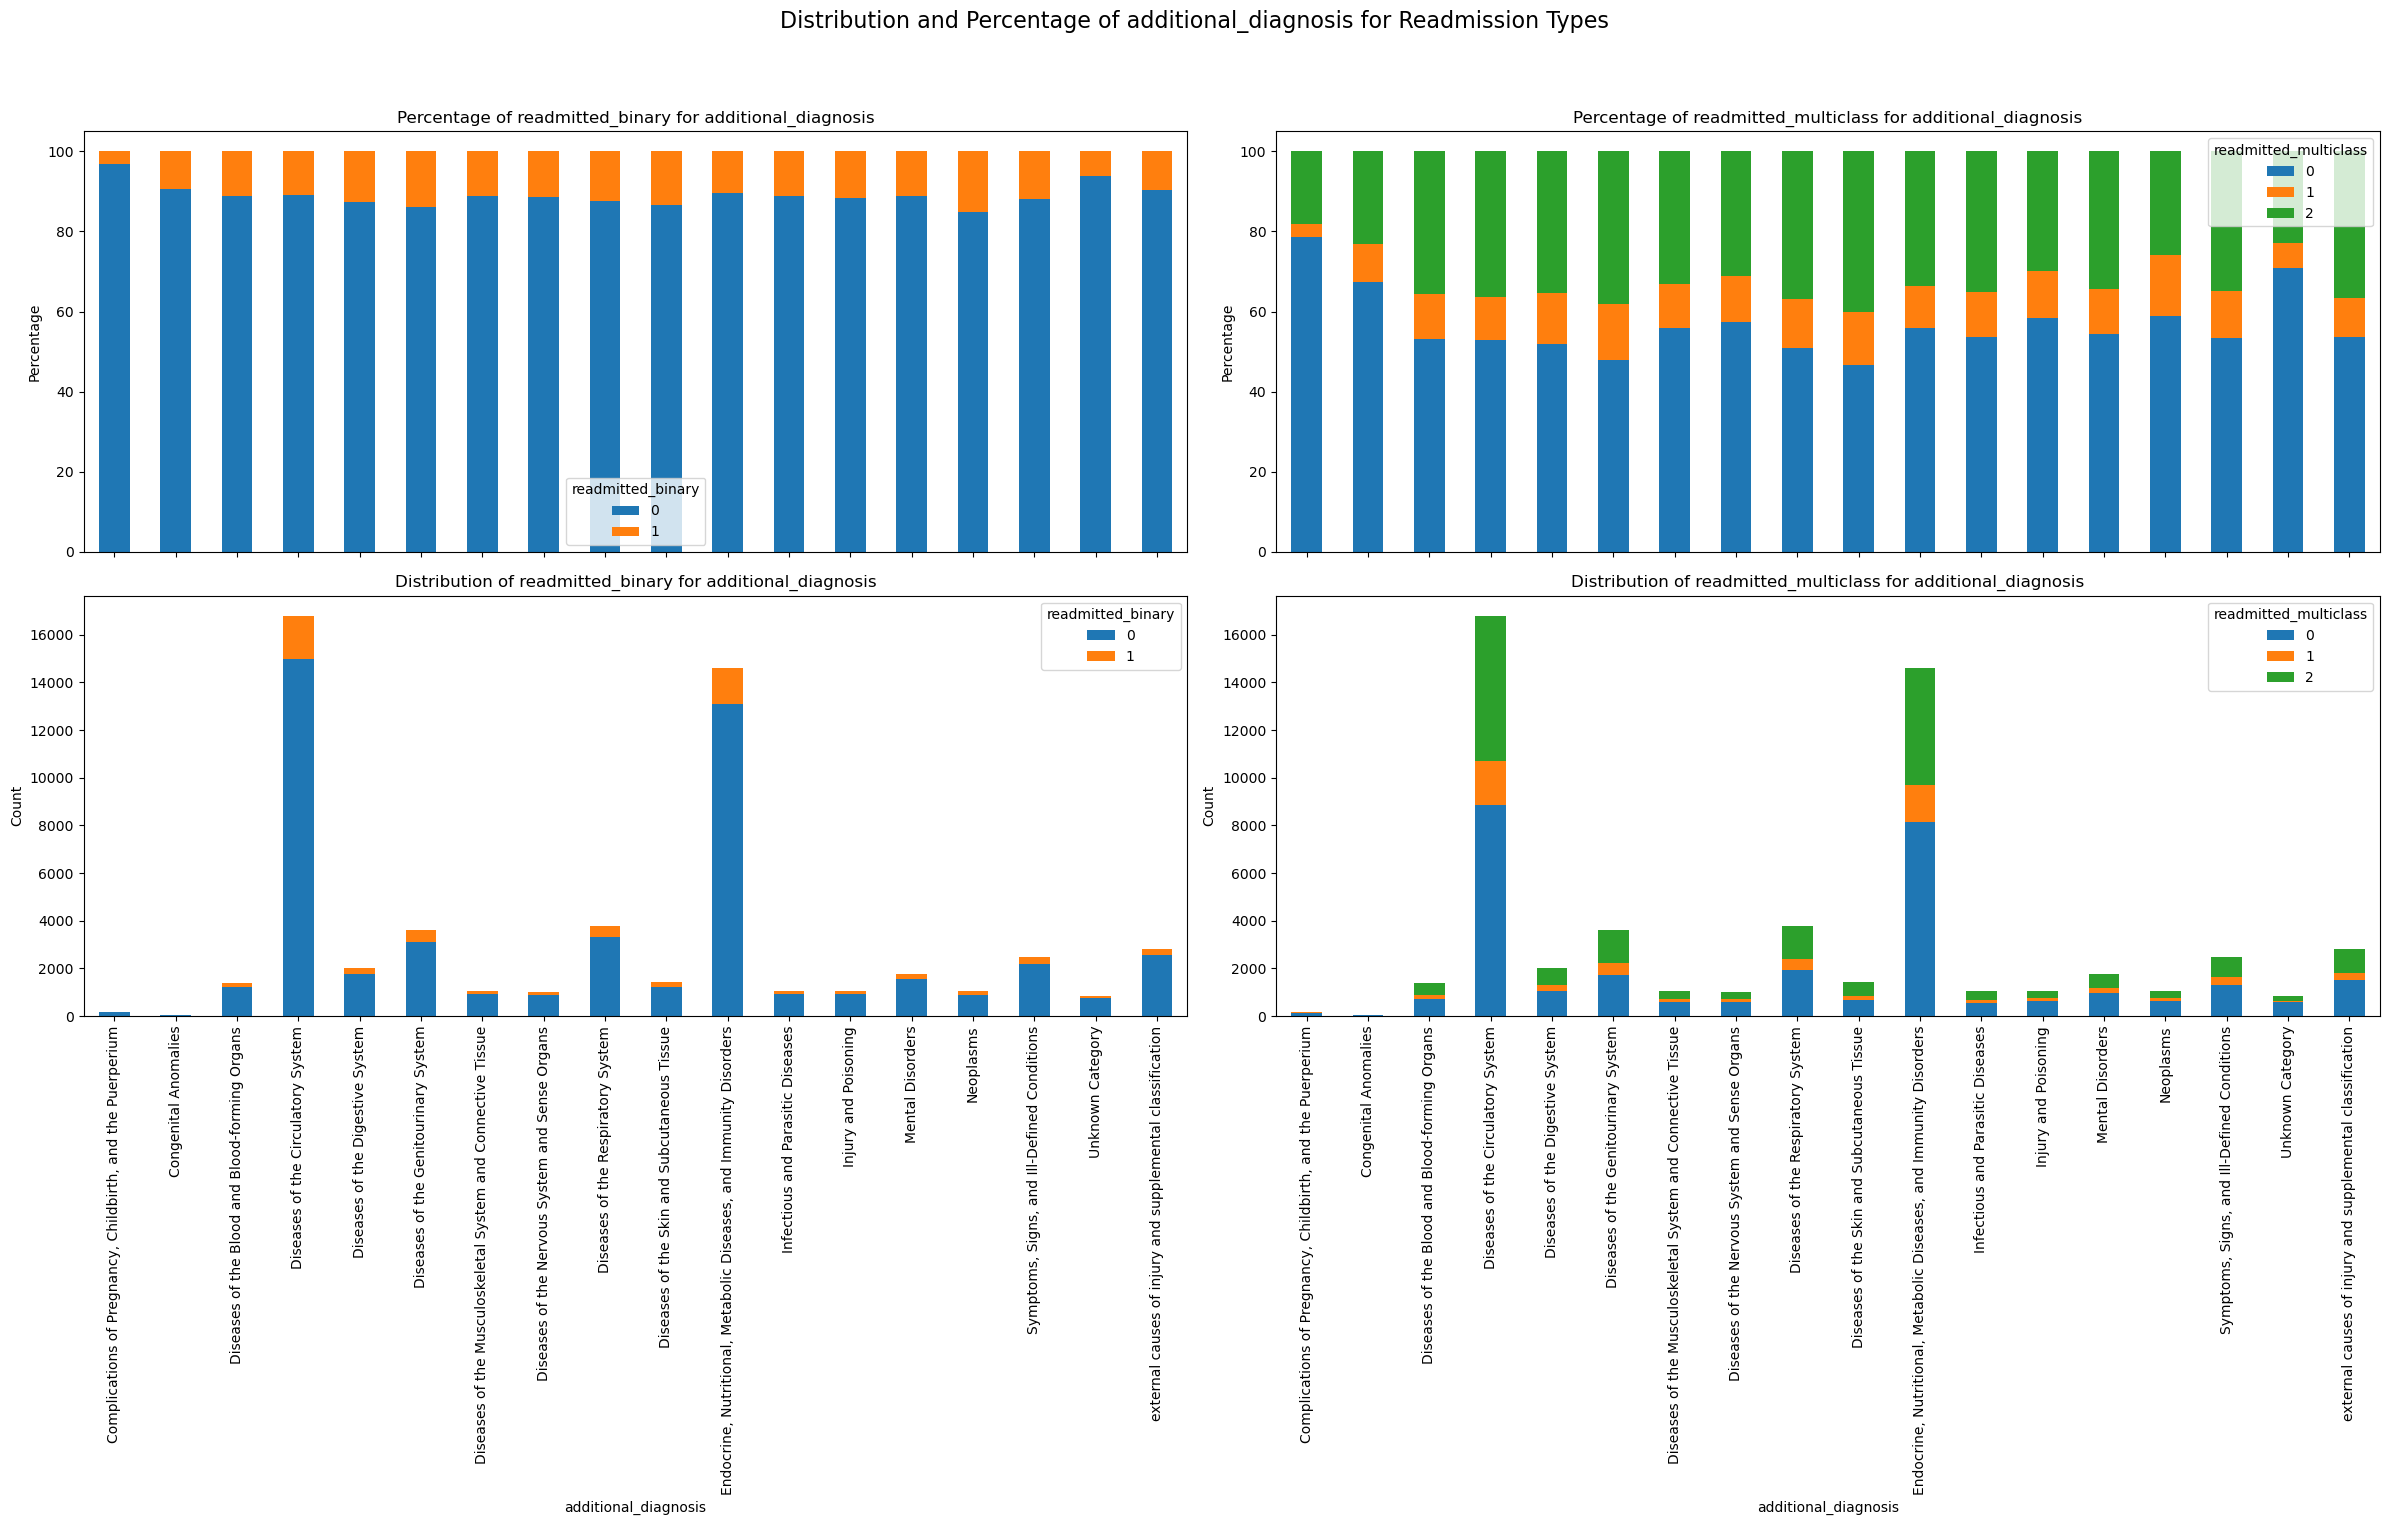

In [99]:
plot_categorical_distribution(data_train, 'additional_diagnosis')

In [100]:
# secondary_diagnosis and additional_diagnosis have very similar distributions, so we will drop additional_diagnosis for dimensionality reduction
data_train.drop(['additional_diagnosis'], axis=1, inplace=True)
data_val.drop(['additional_diagnosis'], axis=1, inplace=True)
data_test.drop(['additional_diagnosis'], axis=1, inplace=True)

In [101]:
# same for multi
data_train_multi.drop(['additional_diagnosis'], axis=1, inplace=True)
data_val_multi.drop(['additional_diagnosis'], axis=1, inplace=True)
data_test_multi.drop(['additional_diagnosis'], axis=1, inplace=True)

#### number_diagnoses

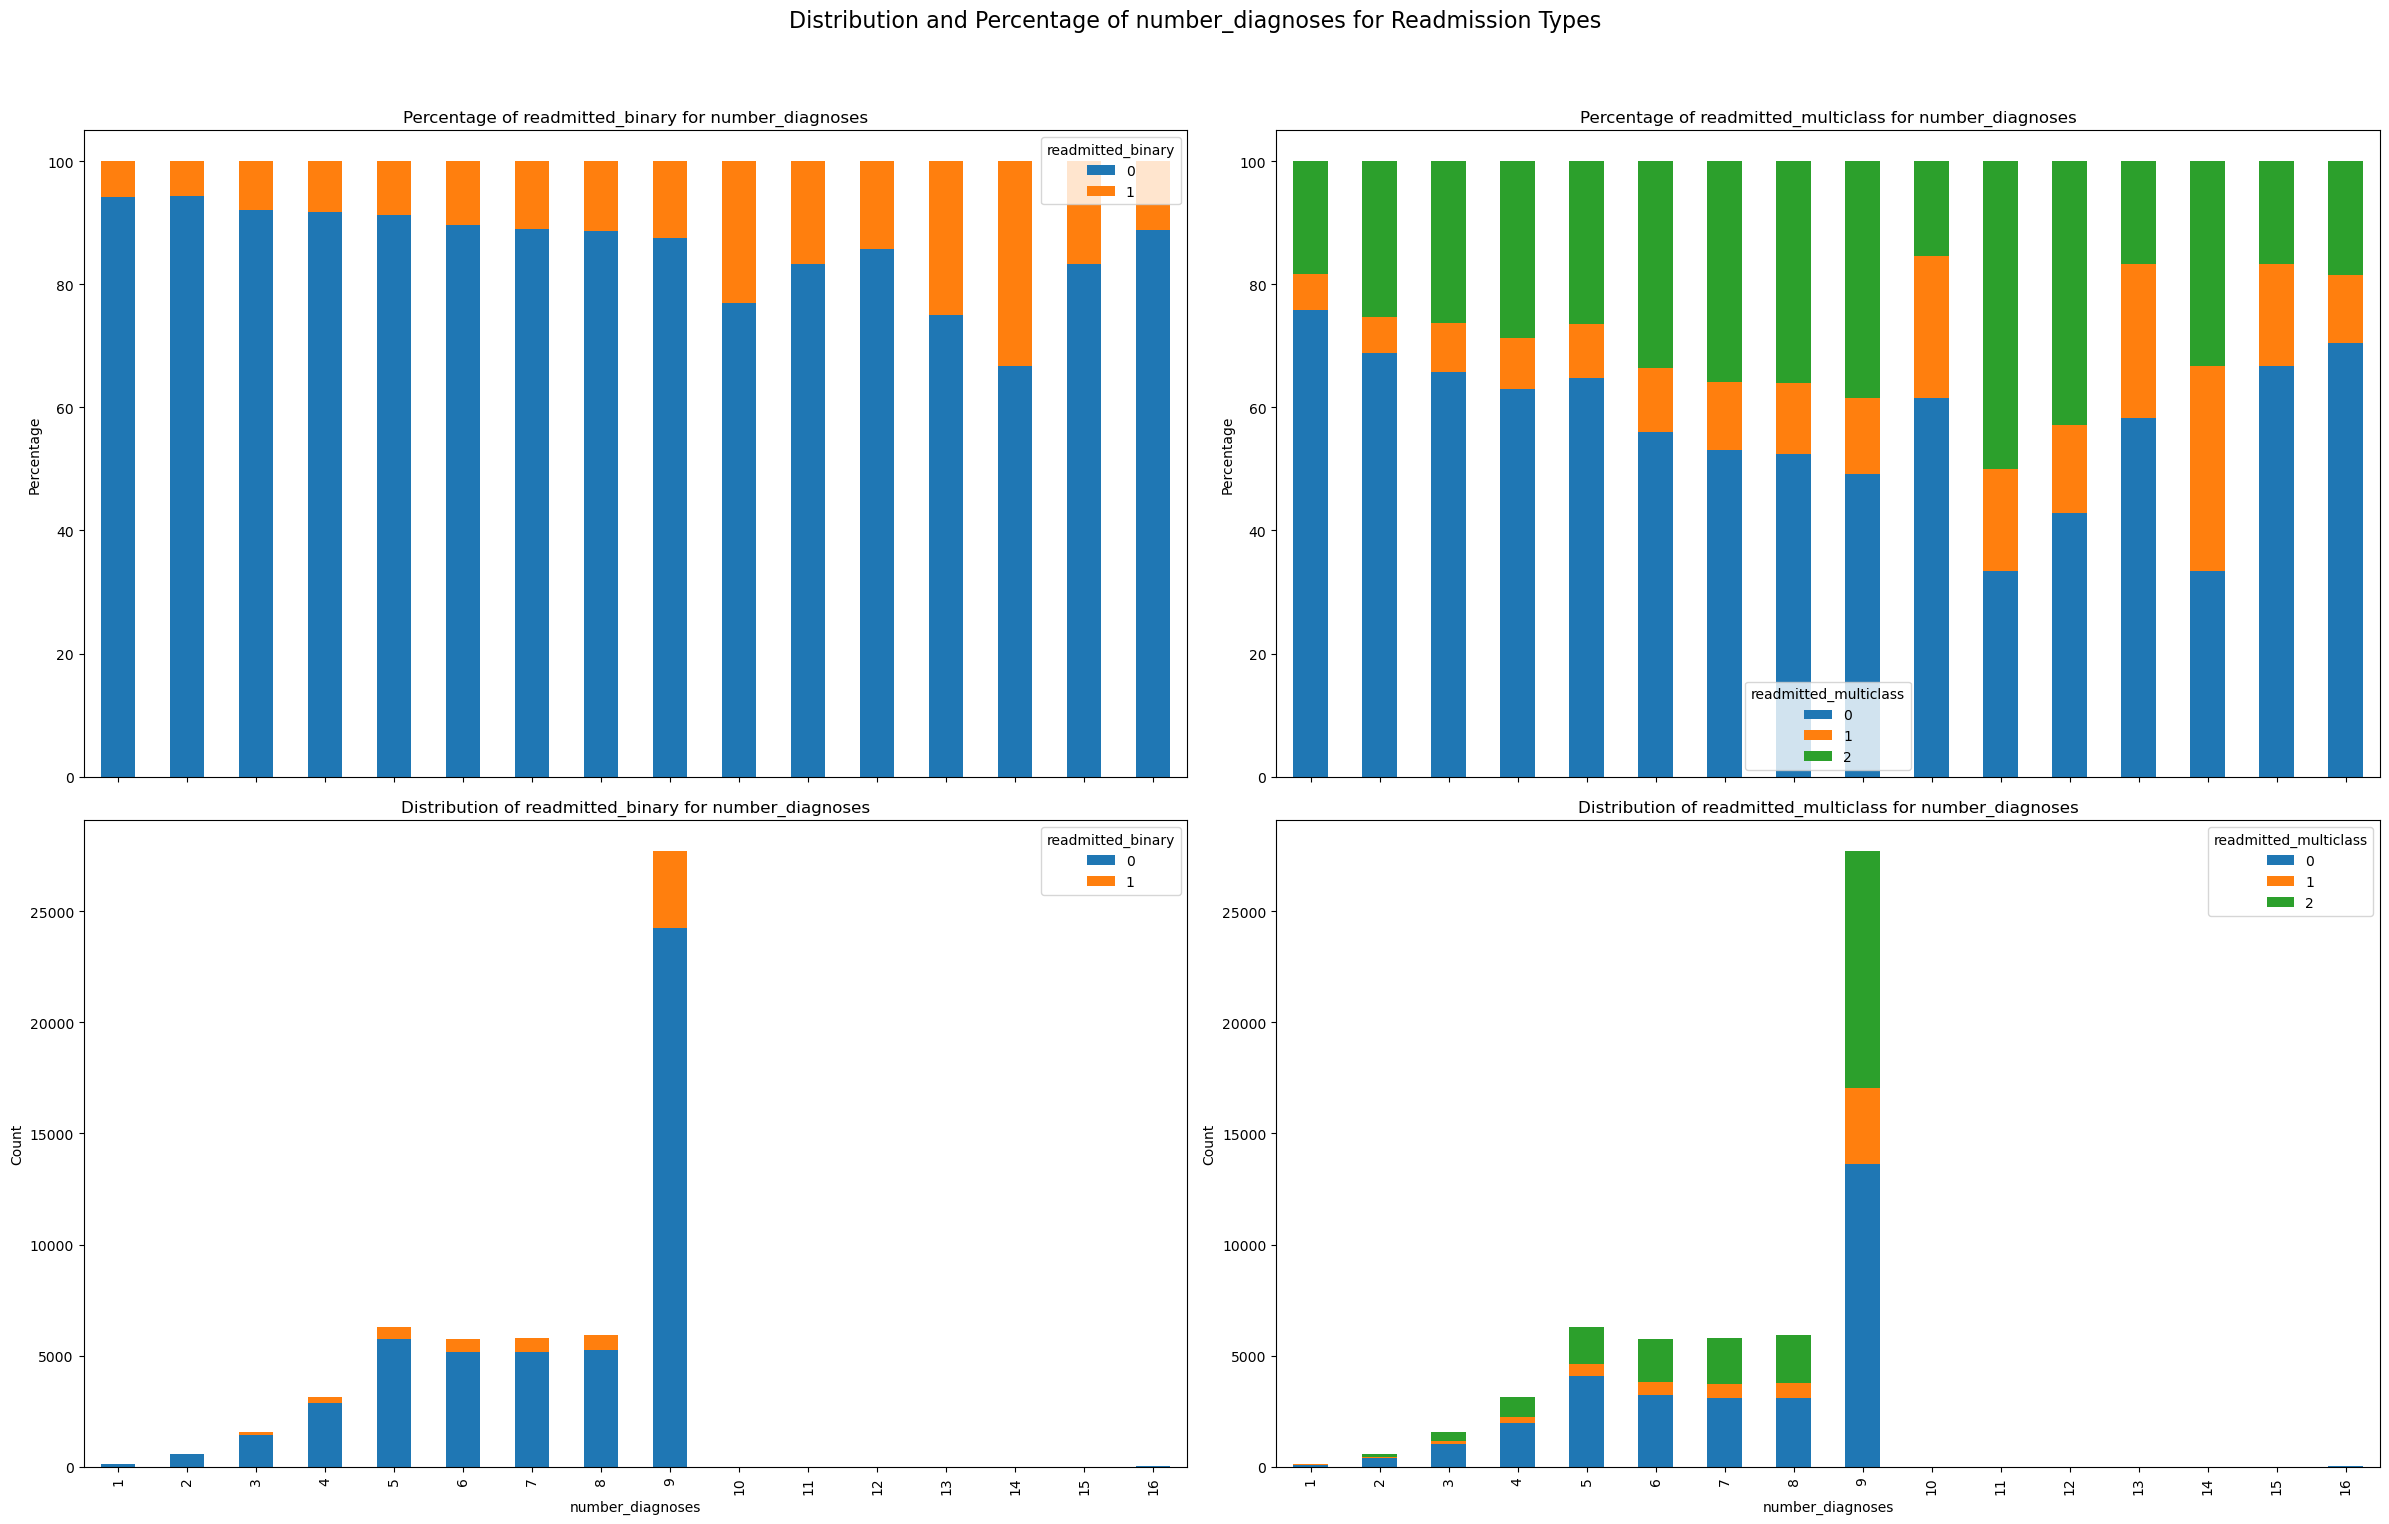

In [102]:
plot_categorical_distribution(data_train, 'number_diagnoses')

In [103]:
# keep as it is, no real outliers in both cases

#### glucose_test_result

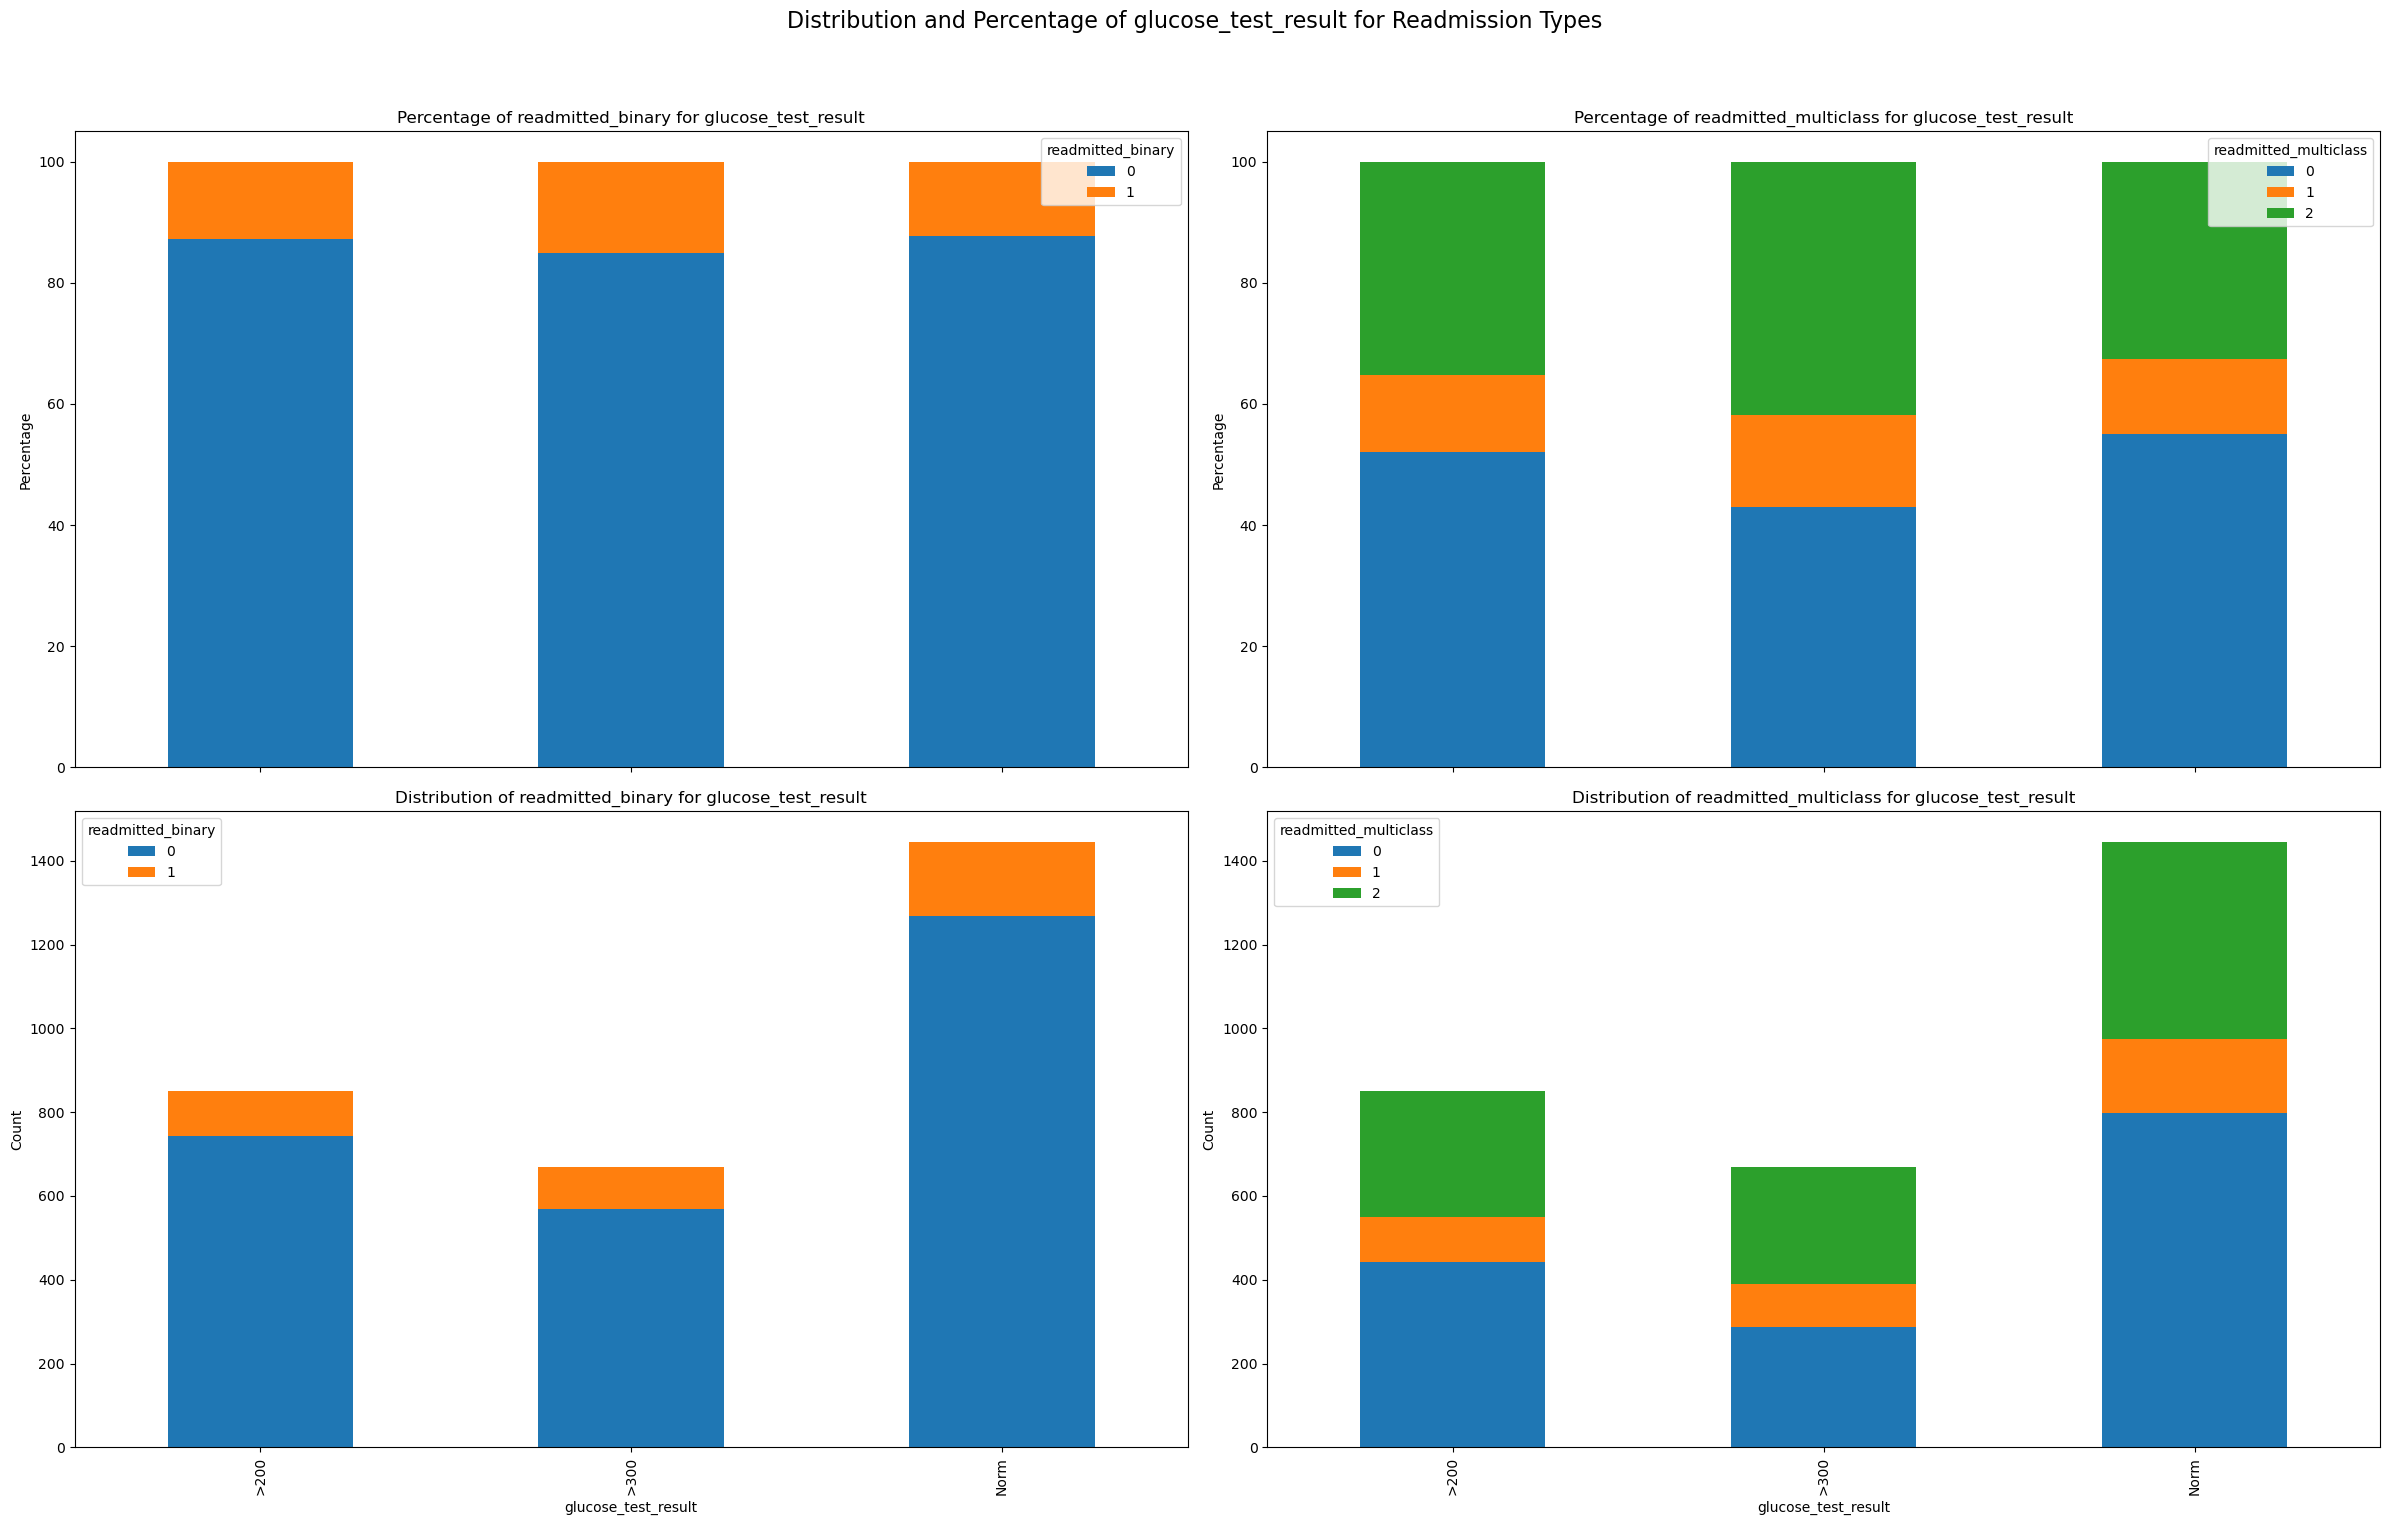

In [104]:
plot_categorical_distribution(data_train, 'glucose_test_result')

In [105]:
# fill missing values with 'Not Performed'
data_train['glucose_test_result'] = data_train['glucose_test_result'].fillna('Not Performed')
data_val['glucose_test_result'] = data_val['glucose_test_result'].fillna('Not Performed')
data_test['glucose_test_result'] = data_test['glucose_test_result'].fillna('Not Performed')

In [106]:
data_train_multi['glucose_test_result'] = data_train_multi['glucose_test_result'].fillna('Not Performed')
data_val_multi['glucose_test_result'] = data_val_multi['glucose_test_result'].fillna('Not Performed')
data_test_multi['glucose_test_result'] = data_test_multi['glucose_test_result'].fillna('Not Performed')

#### a1c_test_result

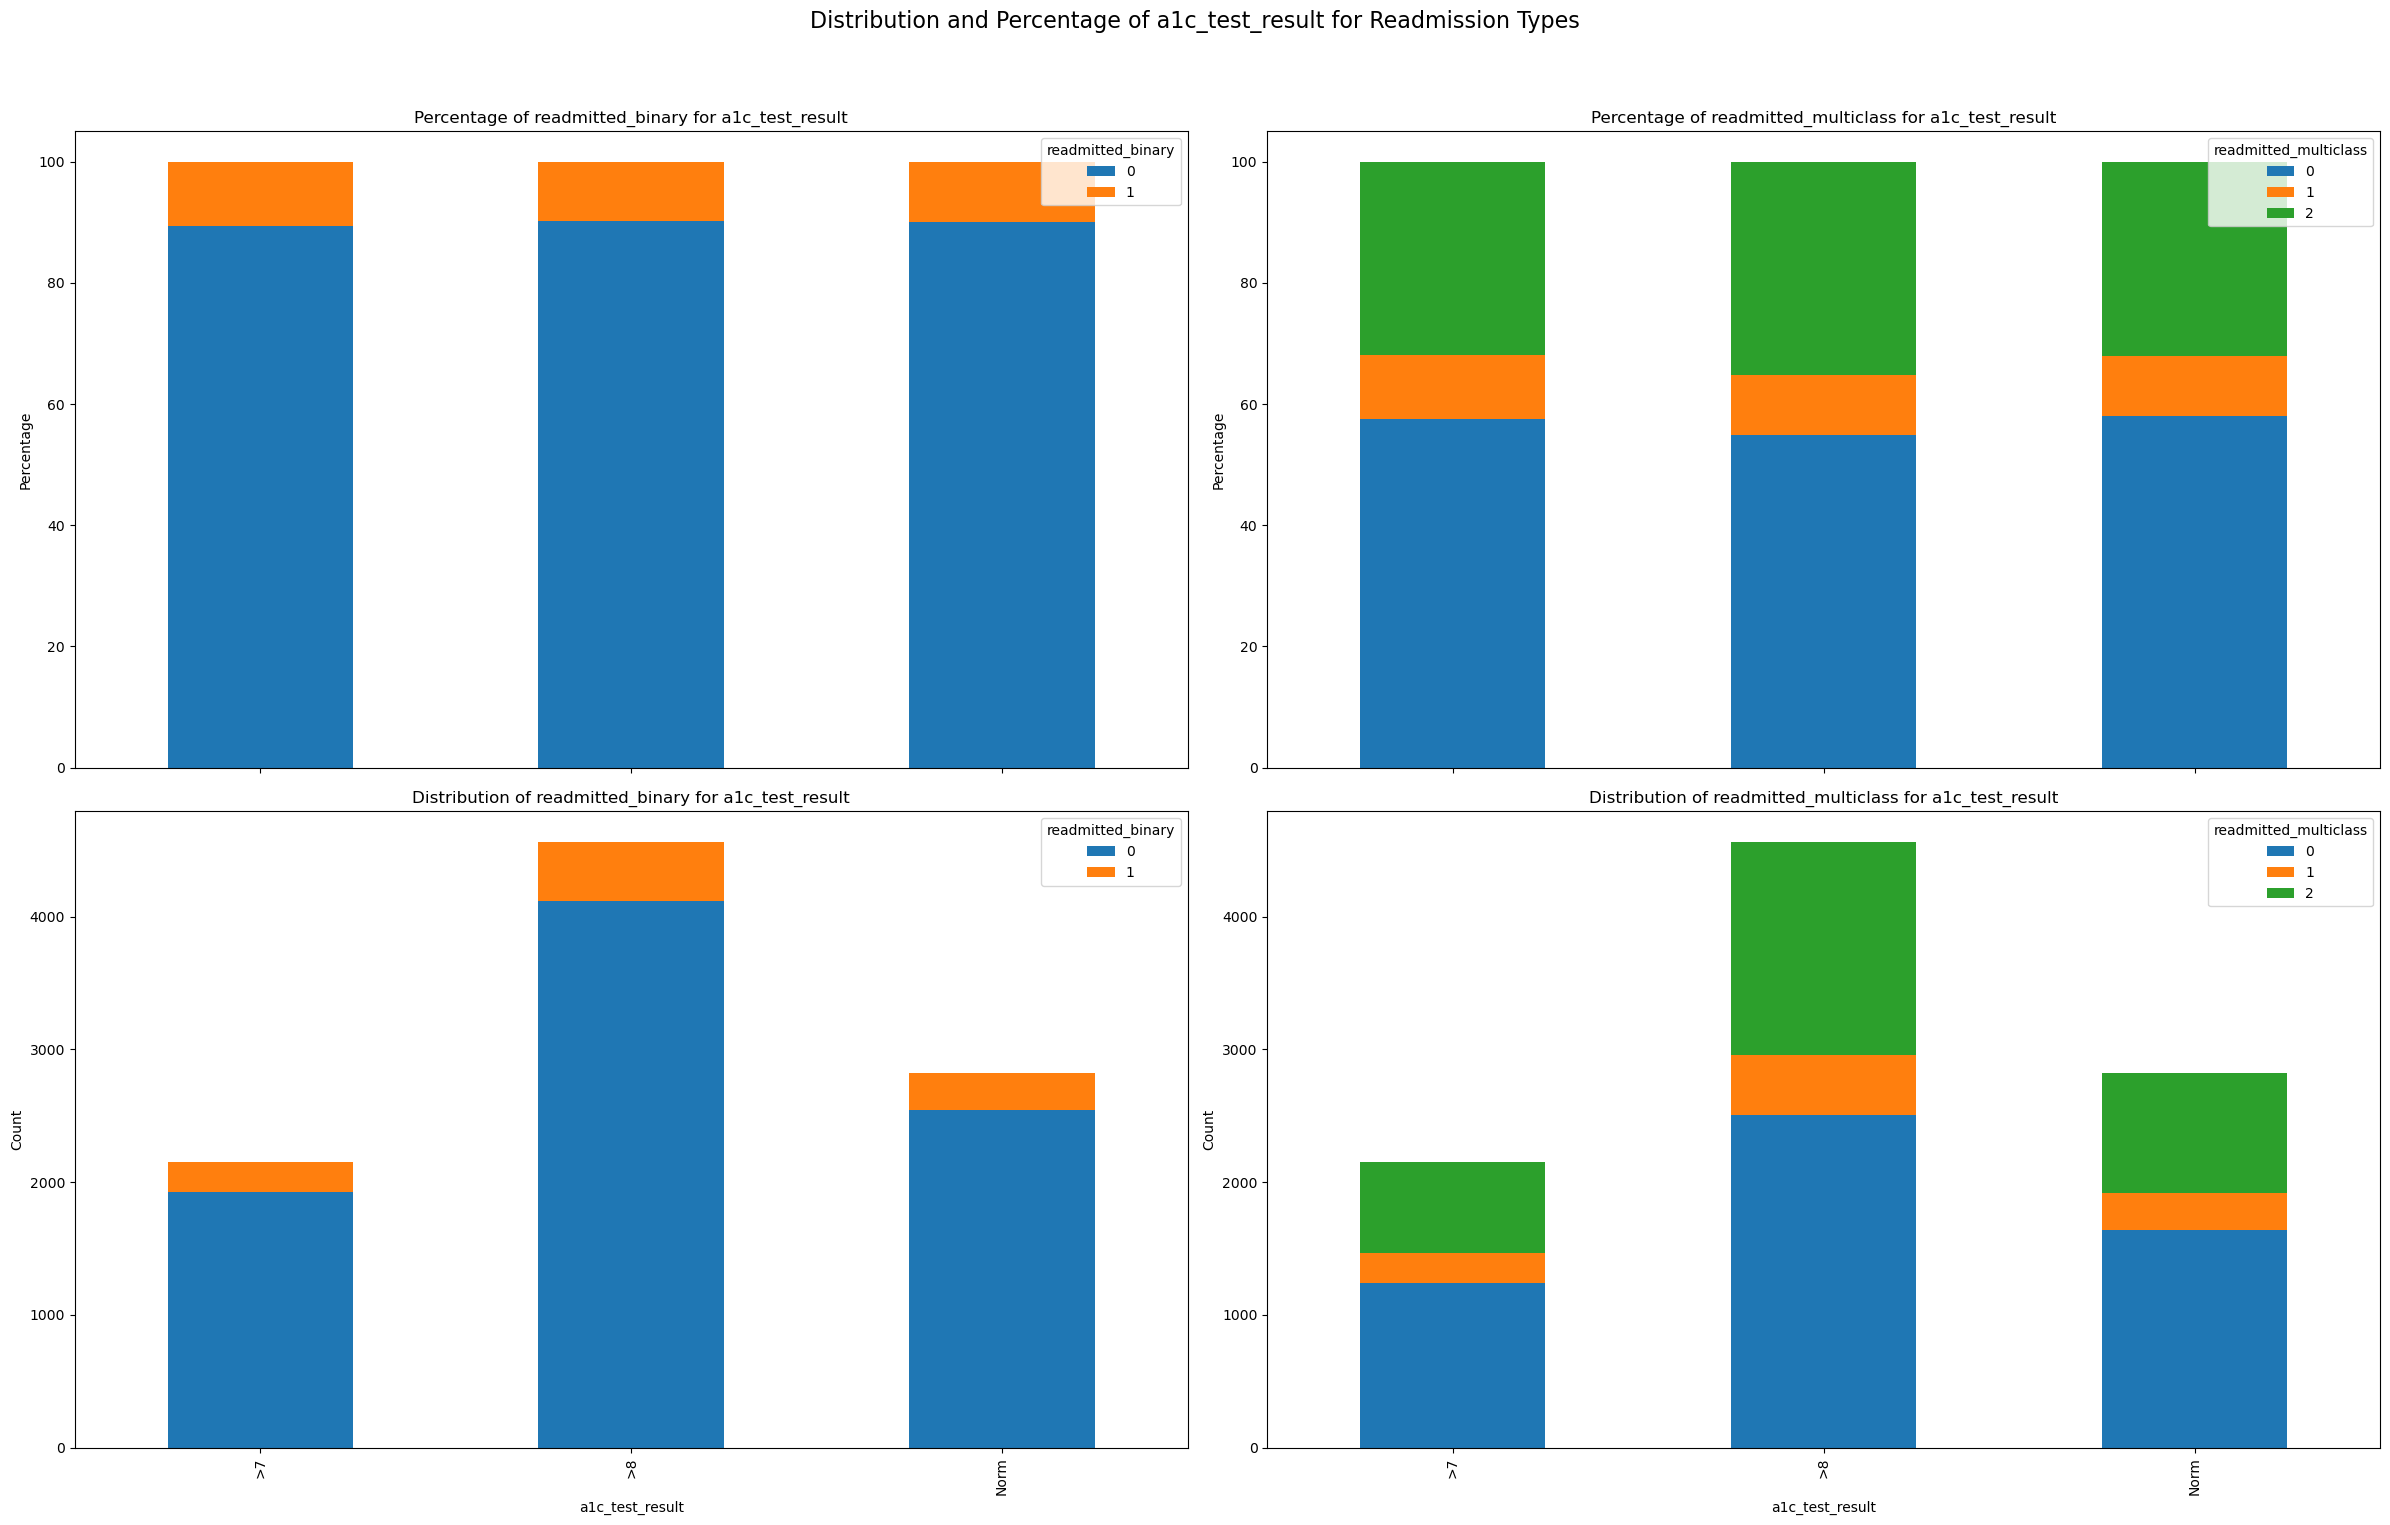

In [107]:
plot_categorical_distribution(data_train, 'a1c_test_result')

In [108]:
# fill missing values with 'Not Performed'
data_train['a1c_test_result'] = data_train['a1c_test_result'].fillna('Not Performed')
data_val['a1c_test_result'] = data_val['a1c_test_result'].fillna('Not Performed')
data_test['a1c_test_result'] = data_test['a1c_test_result'].fillna('Not Performed')

In [109]:
data_train_multi['a1c_test_result'] = data_train_multi['a1c_test_result'].fillna('Not Performed')
data_val_multi['a1c_test_result'] = data_val_multi['a1c_test_result'].fillna('Not Performed')
data_test_multi['a1c_test_result'] = data_test_multi['a1c_test_result'].fillna('Not Performed')

#### change_in_meds_during_hospitalization

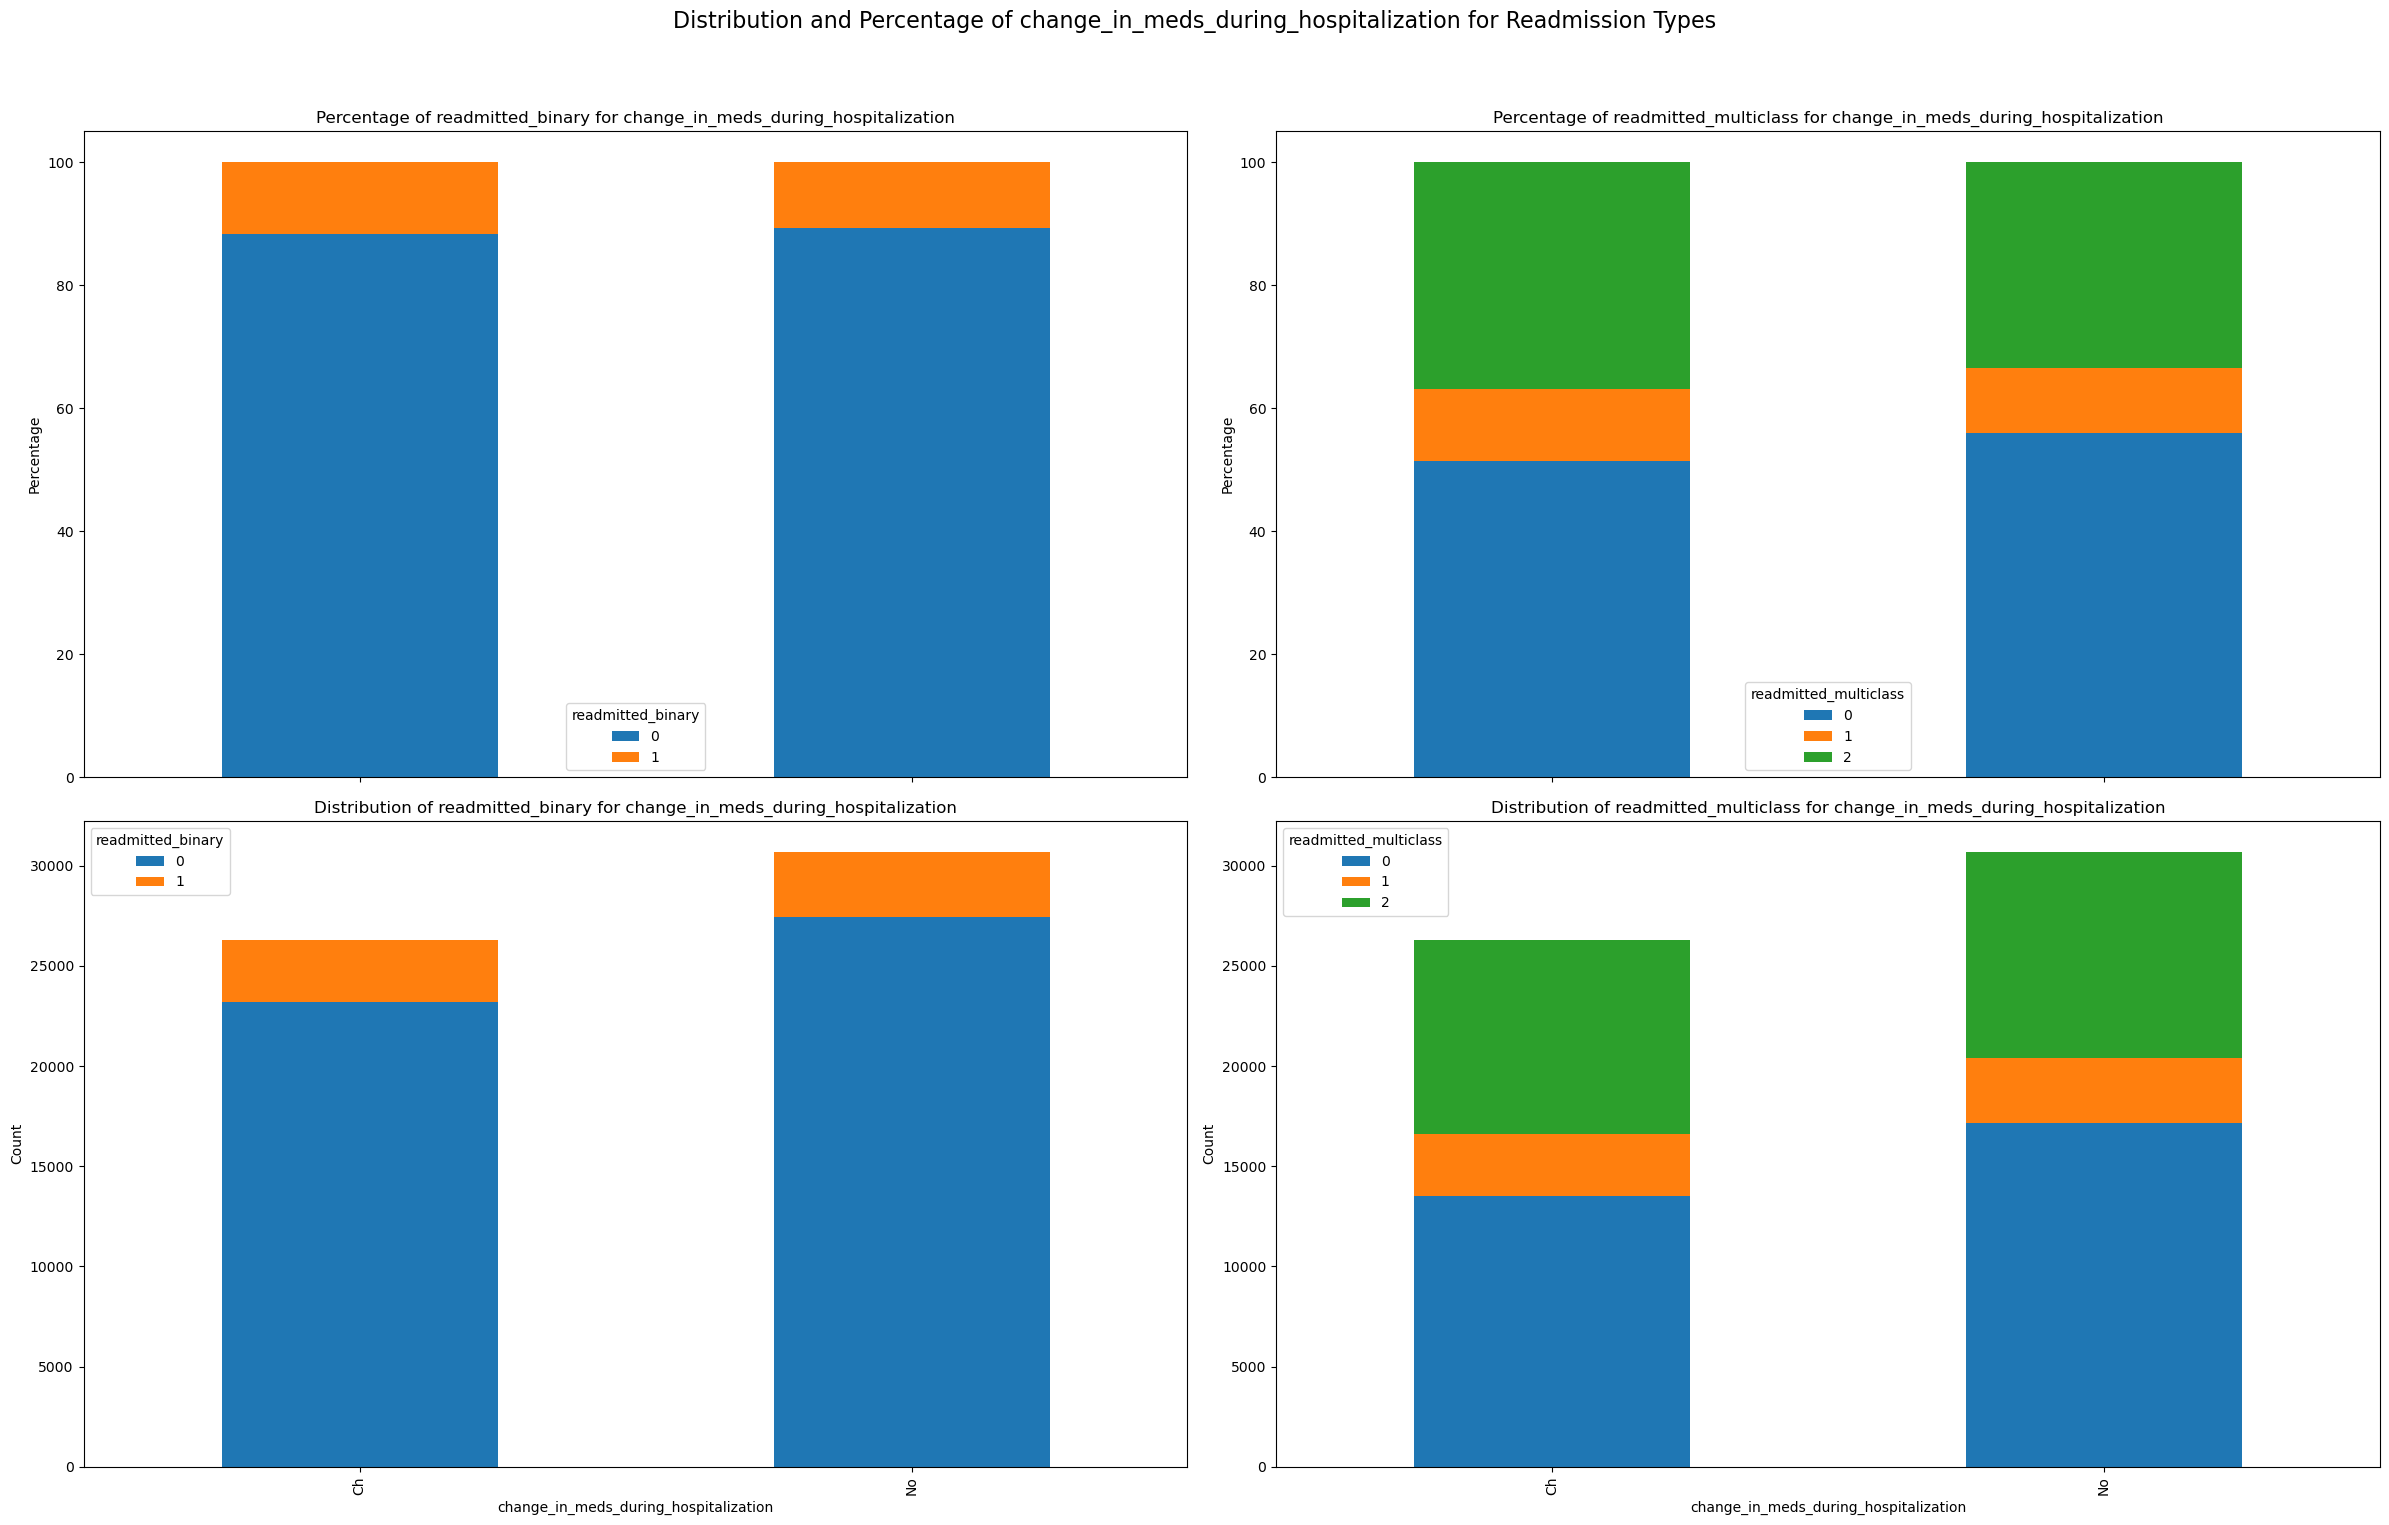

In [110]:
plot_categorical_distribution(data_train, 'change_in_meds_during_hospitalization')

In [111]:
# replace 'Ch' and 'No' with 1 and 0
data_train['change_in_meds_during_hospitalization'] = data_train['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_val['change_in_meds_during_hospitalization'] = data_val['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_test['change_in_meds_during_hospitalization'] = data_test['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})

In [112]:
data_train_multi['change_in_meds_during_hospitalization'] = data_train_multi['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_val_multi['change_in_meds_during_hospitalization'] = data_val_multi['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_test_multi['change_in_meds_during_hospitalization'] = data_test_multi['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})

#### prescribed_diabetes_meds

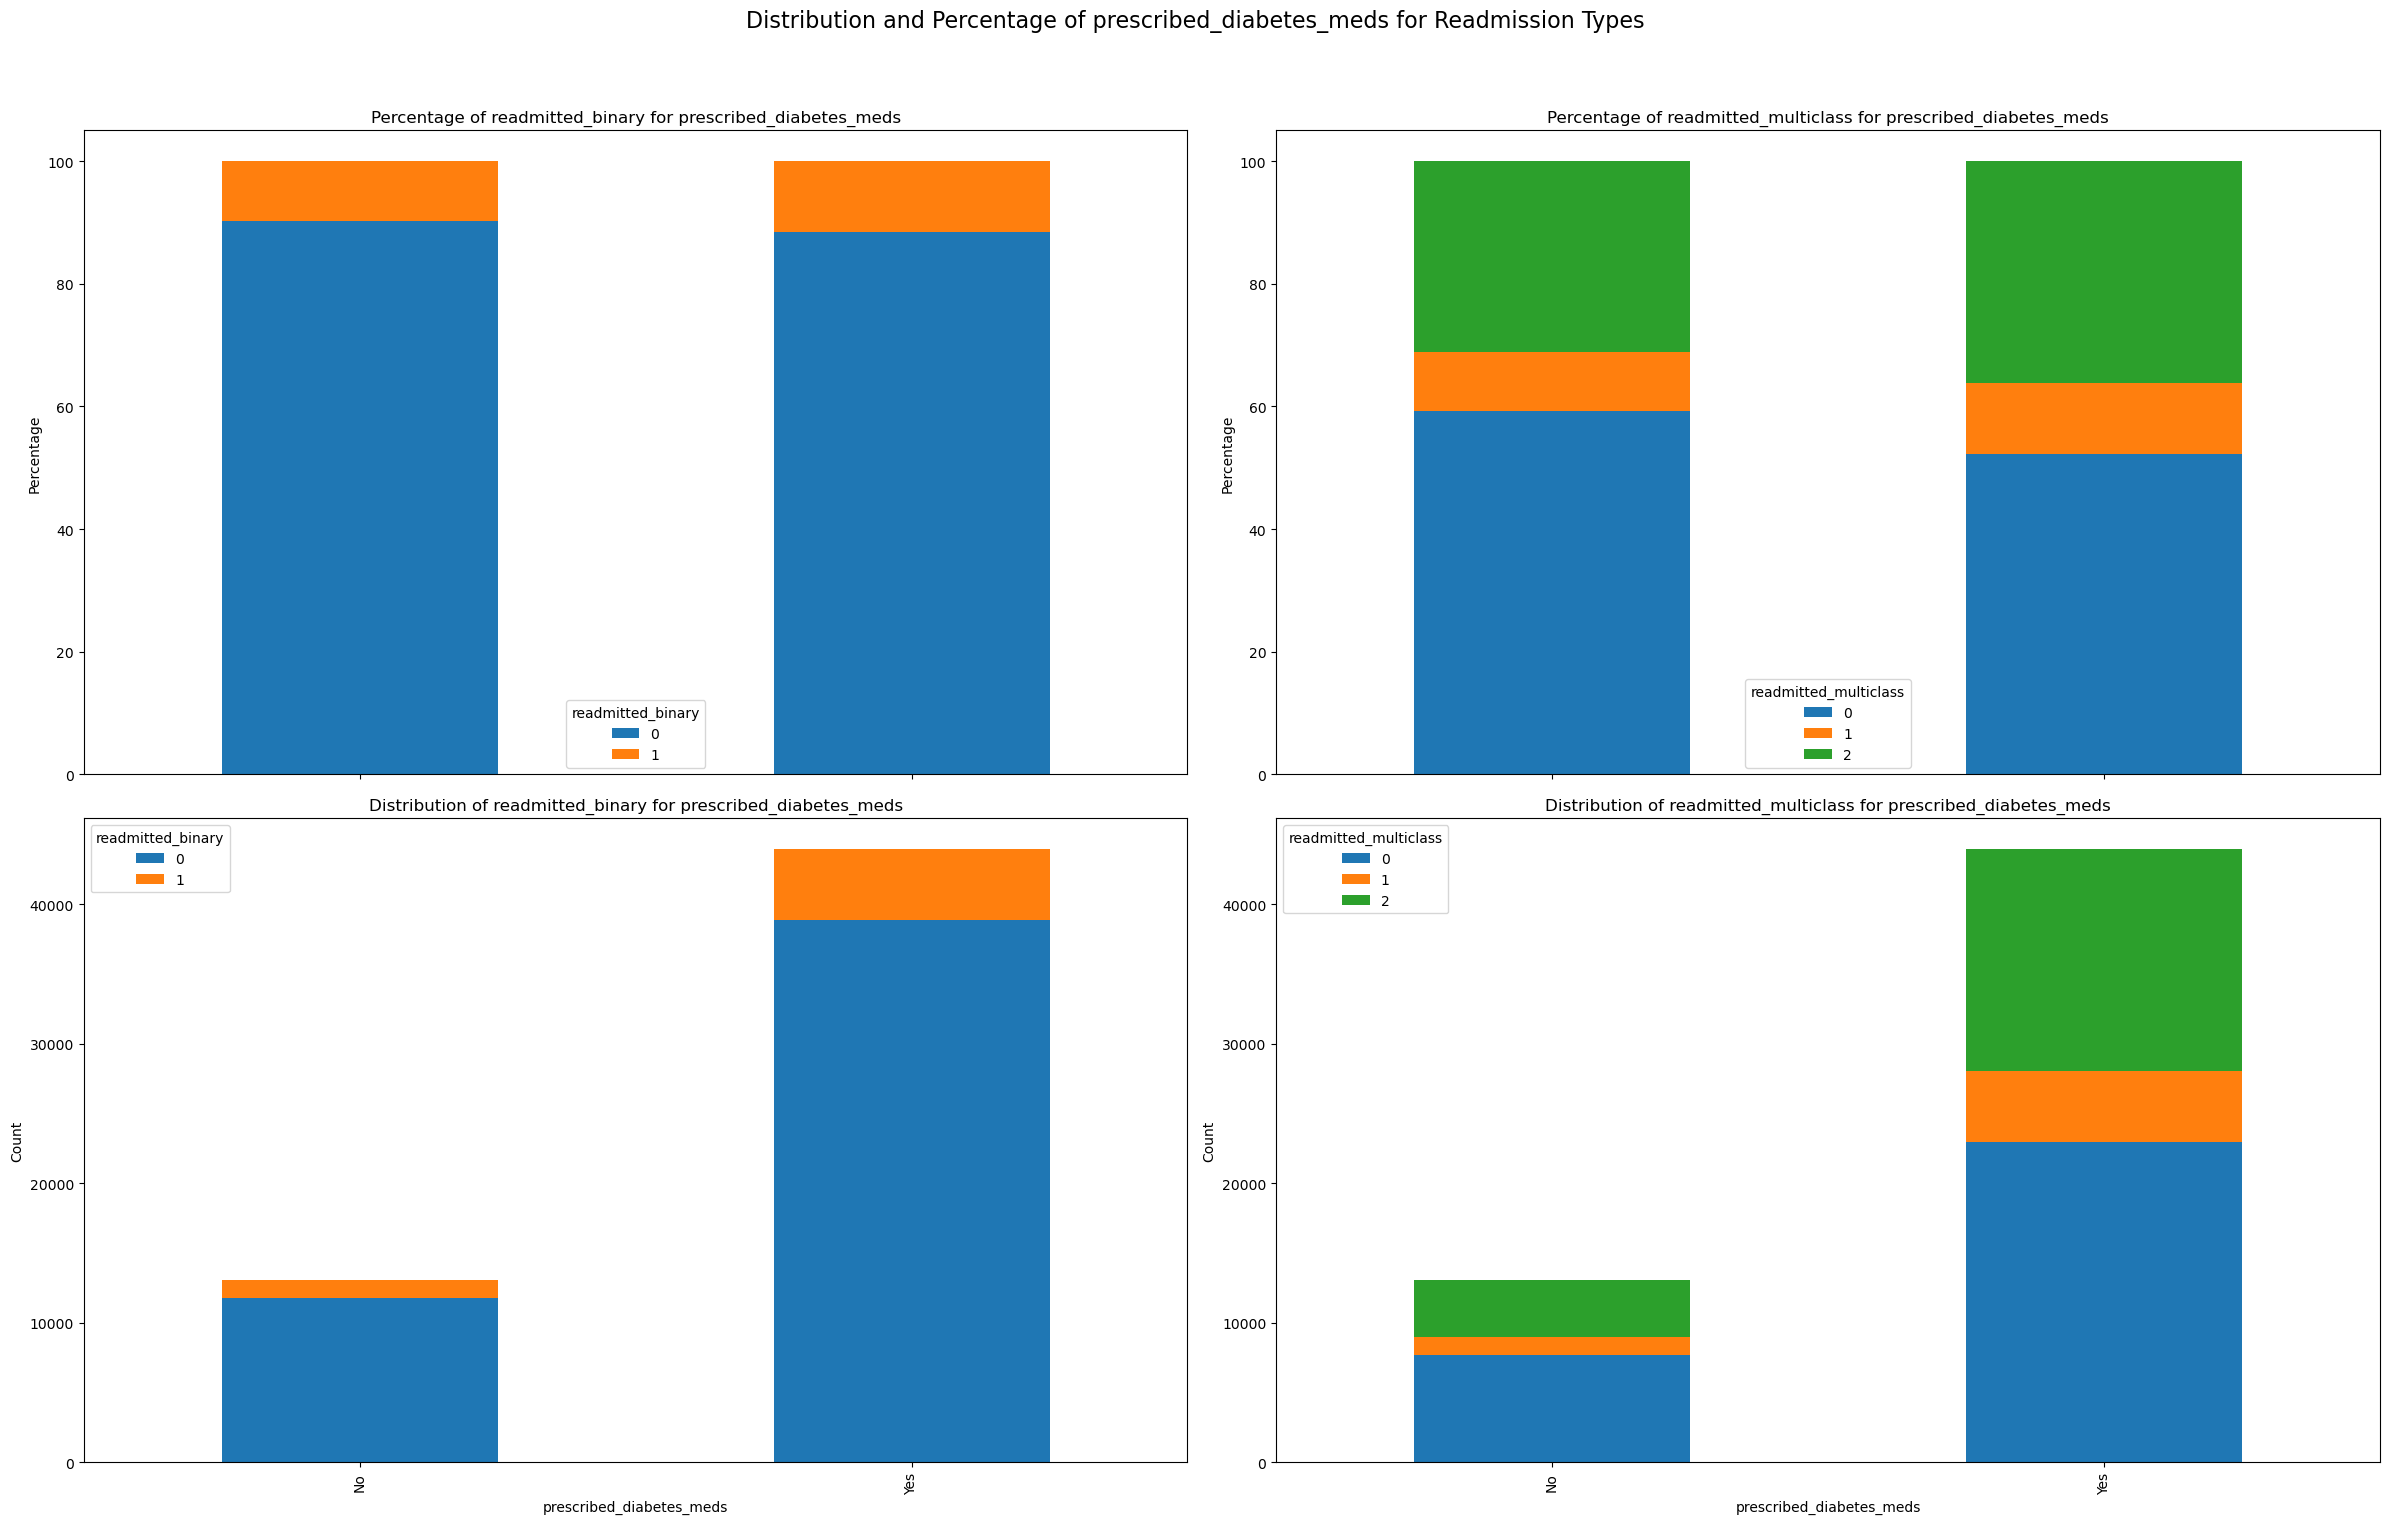

In [113]:
plot_categorical_distribution(data_train, 'prescribed_diabetes_meds')

In [114]:
# replace 'Yes' and 'No' with 1 and 0
data_train['prescribed_diabetes_meds'] = data_train['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_val['prescribed_diabetes_meds'] = data_val['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_test['prescribed_diabetes_meds'] = data_test['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})

In [115]:
data_train_multi['prescribed_diabetes_meds'] = data_train_multi['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_val_multi['prescribed_diabetes_meds'] = data_val_multi['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_test_multi['prescribed_diabetes_meds'] = data_test_multi['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})

#### medication

In [116]:
data_train['medication'].value_counts()

medication
['insulin']                                                               17391
[]                                                                        13045
['metformin']                                                              2528
['metformin', 'insulin']                                                   2417
['glipizide']                                                              2181
                                                                          ...  
['metformin', 'rosiglitazone', 'tolazamide', 'insulin']                       1
['repaglinide', 'glimepiride', 'glyburide', 'insulin']                        1
['metformin', 'nateglinide', 'glimepiride', 'pioglitazone', 'insulin']        1
['glipizide', 'insulin', 'glyburide-metformin', 'glipizide-metformin']        1
['metformin', 'glimepiride', 'insulin', 'glyburide-metformin']                1
Name: count, Length: 282, dtype: int64

In [117]:
# Extract unique medications from the 'medication' column in data_train_copy
unique_medications = set()

# Iterate through each row in the 'medication' column of data_train_copy and add the medications to the set
for medication_list in data_train['medication']:
    medications = medication_list.strip('[]').replace(" ", "").split(',')
    unique_medications.update(medications)

# Convert the set to a list to count the unique medications
unique_medications_list = list(unique_medications)

# Create binary columns for each unique medication in data_train and set values to 1 if present, 0 if not
for medication in unique_medications_list:
    data_train[medication] = data_train['medication'].apply(lambda x: 1 if medication in x else 0)
    data_train_multi[medication] = data_train_multi['medication'].apply(lambda x: 1 if medication in x else 0)


# Repeat the process for data_validation_copy using the unique medications extracted from data_train_copy
for medication in unique_medications_list:
    data_val[medication] = data_val['medication'].apply(lambda x: 1 if medication in x else 0)
    data_test[medication] = data_test['medication'].apply(lambda x: 1 if medication in x else 0)
    data_val_multi[medication] = data_val_multi['medication'].apply(lambda x: 1 if medication in x else 0)
    data_test_multi[medication] = data_test_multi['medication'].apply(lambda x: 1 if medication in x else 0)

# Drop the original 'medication'
data_train.drop(columns=['medication'], inplace=True)
data_val.drop(columns=['medication'], inplace=True)
data_test.drop(columns=['medication'], inplace=True)

data_train_multi.drop(columns=['medication'], inplace=True)
data_val_multi.drop(columns=['medication'], inplace=True)
data_test_multi.drop(columns=['medication'], inplace=True)


# Binary

## Feature Engineering

#### sum_visits

In [118]:
# create a new column sum_visits to sum up the number of visits
data_train['sum_visits'] = data_train['outpatient_visits_in_previous_year'] + data_train['inpatient_visits_in_previous_year'] + data_train['emergency_visits_in_previous_year']
data_val['sum_visits'] = data_val['outpatient_visits_in_previous_year'] + data_val['inpatient_visits_in_previous_year'] + data_val['emergency_visits_in_previous_year']
data_test['sum_visits'] = data_test['outpatient_visits_in_previous_year'] + data_test['inpatient_visits_in_previous_year'] + data_test['emergency_visits_in_previous_year']

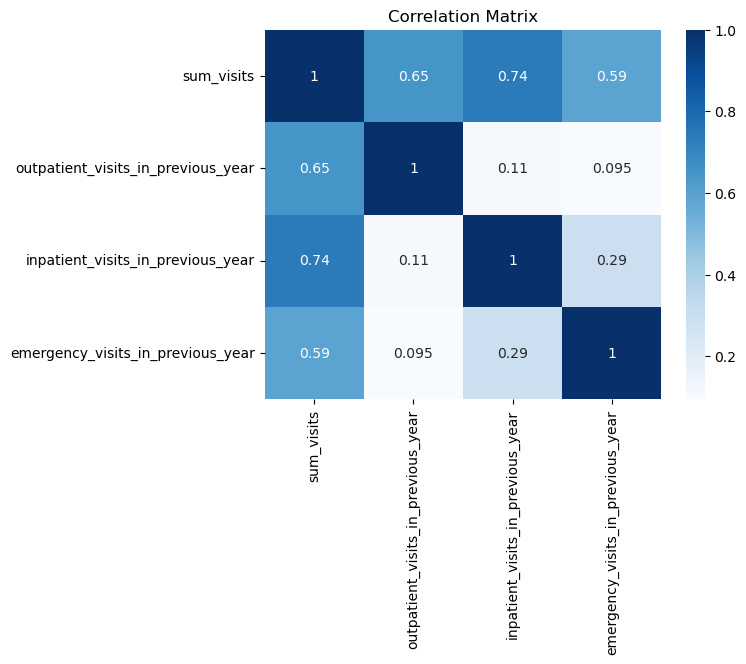

In [119]:
corr_matrix = data_train[['sum_visits', 'outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


In [120]:
data_train.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
data_val.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
data_test.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)

#### High Readmission diagnoses (outcomment everything, not improvement in score)

#### Interaction between Medications and Lab Tests

# Encoding

In [121]:
columns_to_hot_encode = ['race', 'admission_type', 'discharge_disposition', 'admission_source', 'glucose_test_result', 'a1c_test_result', 'primary_diagnosis', 'secondary_diagnosis', 'payer_code']

In [122]:
# Once encoding for binary classification

# Initialize the OneHotEncoder with handle_unknown='ignore' to ignore unknown categories
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

# Fit the encoder on the training data
encoder.fit(data_train[columns_to_hot_encode])

# Transform both training and testing data
train_encoded = encoder.transform(data_train[columns_to_hot_encode])
val_encoded = encoder.transform(data_val[columns_to_hot_encode])
test_encoded = encoder.transform(data_test[columns_to_hot_encode])

# Convert the encoded matrices to DataFrames
# Ensure the index is aligned with the original DataFrame's index
train_encoded_df = pd.DataFrame(train_encoded.toarray(), 
                                index=data_train.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

val_encoded_df = pd.DataFrame(val_encoded.toarray(),
                                index=data_val.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

test_encoded_df = pd.DataFrame(test_encoded.toarray(), 
                               index=data_test.index,
                               columns=encoder.get_feature_names_out(columns_to_hot_encode))

# Concatenate the encoded columns back to the original dataframes
data_train = pd.concat([data_train.drop(columns=columns_to_hot_encode), train_encoded_df], axis=1)
data_val = pd.concat([data_val.drop(columns=columns_to_hot_encode), val_encoded_df], axis=1)
data_test = pd.concat([data_test.drop(columns=columns_to_hot_encode), test_encoded_df], axis=1)

# Scaling

In [123]:
columns_to_scale = ['age', 'admission_count', 'sum_visits', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

In [124]:
# scale the columns
scaler = MinMaxScaler()

# fit the scaler on the training data
scaler.fit(data_train[columns_to_scale])

# transform both training and testing data
data_train[columns_to_scale] = scaler.transform(data_train[columns_to_scale])
data_val[columns_to_scale] = scaler.transform(data_val[columns_to_scale])
data_test[columns_to_scale] = scaler.transform(data_test[columns_to_scale])

## Remaining missing values

In [125]:
# we will use following features to impute age
features_for_imputation = ['sum_visits', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Prepare the training data for imputation (excluding 'age')
train_data_for_imputation = data_train[features_for_imputation]

# Fit the imputer on the training data and transform the 'age' column
data_train['age'] = knn_imputer.fit_transform(data_train[['age']].join(train_data_for_imputation))[:, 0]

# Prepare the validation and test data for imputation (excluding 'age')
val_data_for_imputation = data_val[features_for_imputation]
test_data_for_imputation = data_test[features_for_imputation]

# Transform the 'age' column in validation and test data using the trained imputer
data_val['age'] = knn_imputer.transform(data_val[['age']].join(val_data_for_imputation))[:, 0]
data_test['age'] = knn_imputer.transform(data_test[['age']].join(test_data_for_imputation))[:, 0]

# Save and Reload

In [126]:
# use pickle to save the data_train, data_val and data_test
with open('data_train.pkl', 'wb') as f:
    pickle.dump(data_train, f)

with open('data_val.pkl', 'wb') as f:
    pickle.dump(data_val, f)

with open('data_test.pkl', 'wb') as f:
    pickle.dump(data_test, f)

In [127]:
# load the data_train, data_val and data_test
with open('data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)

with open('data_val.pkl', 'rb') as f:
    data_val = pickle.load(f)

with open('data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)

# Binary Classification

In [128]:
# define X_train, y_train, X_val, y_val
X_train = data_train.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_train = data_train['readmitted_binary']

X_val = data_val.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_val = data_val['readmitted_binary']

X_test = data_test.copy()

In [129]:
# we have to remember to drop patient_id as it doesn't predict anything itself
X_train.drop(['patient_id'], axis=1, inplace=True)
X_val.drop(['patient_id'], axis=1, inplace=True)
X_test.drop(['patient_id'], axis=1, inplace=True)

### OverSampling

In [130]:
# Create a pipeline that first applies SMOTE and then applies RandomUnderSampler
over = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample to 50% of majority class
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Undersample to equalize
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Apply the pipeline to your training data
X_train, y_train = pipeline.fit_resample(X_train, y_train)

### Feature Selection

In [131]:
# We used the below code to get the best number of features by using RFE with logistic regression as model


# nof_list=np.arange(30,110)            
# high_score=0
# # Variable to store the optimum features
# model = LogisticRegression(random_state=42, max_iter=300)
# nof=0           
# score_list =[]
# for n in range(len(nof_list)):
#     rfe = RFE(model,n_features_to_select = nof_list[n])
#     X_train_rfe = rfe.fit_transform(X_train,y_train)
#     X_val_rfe = rfe.transform(X_val)
#     model.fit(X_train_rfe,y_train)
    
#     score = model.score(X_val_rfe,y_val)
#     score_list.append(score)
    
#     if(score>high_score):
#         high_score = score
#         nof = nof_list[n]
# print("Optimum number of features: %d" %nof)
# print("Score with %d features: %f" % (nof, high_score))


# --> we try 32 features

In [132]:
# # use logistic regression in RFE to select best features

# logreg = LogisticRegression(random_state=42, max_iter=100)

# # Assuming logreg is your logistic regression model
# rfe = RFE(estimator=logreg, n_features_to_select=32)

# # Number of folds for KFold
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store results
# feature_support = []

# # Loop over each fold
# for train_index, test_index in kf.split(X_train):
#     # Splitting the data
#     X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#     # Fitting the RFE model on the training fold
#     rfe.fit(X_train_fold, y_train_fold.values.ravel())

#     # Store the support of the features
#     feature_support.append(rfe.support_)

# # Aggregate feature support from all folds
# feature_support_matrix = np.array(feature_support)
# average_support = np.mean(feature_support_matrix, axis=0)

# # Select features that are considered important in most folds
# selected_features = X_train.columns[average_support > 0.5].tolist()

# # Filter the datasets to include only the selected features
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]
# X_val = X_val[selected_features]


# # Fitting the RFE model
# rfe = rfe.fit(X_train, y_train.values.ravel())

# cols = X_train.columns[rfe.support_].tolist()

# X_train = X_train[cols]
# X_test = X_test[cols]
# X_val = X_val[cols]

In [134]:
# Using RFE for Feature Selection
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=5)
rfecv = rfecv.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfecv.support_]
# Extracting information
print("Optimal number of features : %d" % rfecv.n_features_)
print("Feature Ranking: ", rfecv.ranking_)
print("Selected Features: ", rfecv.support_)


In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
X_val = X_val[selected_features_rfe]

### Models

In [ ]:
# create a function that will fit the model and print the f1 score

def fit_model(model, X_train, y_train, X_validation, y_validation):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    print('F1 score: {}'.format(f1_score(y_validation, y_pred)))
    return model

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "MLP": MLPClassifier(max_iter=100)
}

# F1 scorer
f1_scorer = make_scorer(f1_score)

# Perform cross-validation and print F1 scores for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=5)
    print(f"{name} - F1 scores for each fold: {scores}")
    print(f"{name} - Average F1 score: {np.mean(scores)}\n")

Logistic Regression - F1 scores for each fold: [0.5560054  0.72206648 0.77001149 0.76245211 0.76470588]
Logistic Regression - Average F1 score: 0.7150482714739318

Random Forest - F1 scores for each fold: [0.17282628 0.86582495 0.96317497 0.96413885 0.96471938]
Random Forest - Average F1 score: 0.7861368868551131

Gradient Boosting - F1 scores for each fold: [0.1300489  0.85076826 0.94013721 0.94086529 0.94960465]
Gradient Boosting - Average F1 score: 0.7622848622758613

AdaBoost - F1 scores for each fold: [0.2989546  0.82401698 0.89794413 0.89572713 0.88909461]
AdaBoost - Average F1 score: 0.7611474900831093

MLP - F1 scores for each fold: [0.41421815 0.82662995 0.89568082 0.88501546 0.89264813]
MLP - Average F1 score: 0.7828385032195222



In [ ]:
# based on that we choose Random Forest, Gradient Boosting and MLP

### Gridsearch

#### Gradient Boosting

In [ ]:
param_grid = {
    'learning_rate': [0.01],
    'max_depth': [3],
    'n_estimators': [400],
    'subsample': [1],
    'ccp_alpha': [0.001],
    'validation_fraction': [0.2],
    'n_iter_no_change': [5],
    'tol': [0.01]
}

# Create the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(gb, param_grid, scoring=make_scorer(f1_score), cv=5, verbose=1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_gb = grid_search.best_estimator_
fit_model(best_gb, X_train, y_train, X_val, y_val)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best parameters: {'ccp_alpha': 0.001, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'n_iter_no_change': 5, 'subsample': 1, 'tol': 0.01, 'validation_fraction': 0.2}
F1 score: 0.3096446700507614


GradientBoostingClassifier(ccp_alpha=0.001, learning_rate=0.01,
                           n_estimators=400, n_iter_no_change=5,
                           random_state=42, subsample=1, tol=0.01,
                           validation_fraction=0.2)

In [ ]:
best_gb

GradientBoostingClassifier(ccp_alpha=0.001, learning_rate=0.01,
                           n_estimators=400, n_iter_no_change=5,
                           random_state=42, subsample=1, tol=0.01,
                           validation_fraction=0.2)

In [ ]:
# create a gradient boosting model with the parameters 
# learning_rate=0.01 
# max_depth=3 
# n_estimators=400 
# subsample=1 
# validation_fraction=0.2 
# n_iter_no_change=5 
# tol=0.01 
# ccp_alpha=0.001 
# n_iter_no_change=5 
# tol=0.01

# gb = GradientBoostingClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, random_state=42, validation_fraction=validation_fraction, n_iter_no_change=n_iter_no_change, tol=tol, ccp_alpha=ccp_alpha, verbose=1)
# gb = fit_model(gb, X_train, y_train, X_val, y_val)



In [ ]:
# # Parameter lists
# n_estimators = 100
# criterion = 'entropy'     # choose between 'gini', 'entropy', and 'log_loss'
# max_depth = 30            # doesn't change after a certain value, around 30
# min_samples_split = 4     # constant and then decreases
# min_samples_leaf = 12     # around 12
# min_weight_fraction_leaf = 0.0    # keep 0
# max_features = 'sqrt'     # choose between 'auto', 'log2', and 'sqrt'
# max_leaf_nodes = None
# min_impurity_decrease = 0.0   # has to be 0
# bootstrap = True         # choose between True and False, True seems better
# oob_score = False        # only true if bootstrap is true, use false
# n_jobs = None
# verbose = 0              # keep 0
# warm_start = False
# class_weight = 'balanced'     # choose between 'balanced' and 'balanced_subsample', 'balanced' seems better
# ccp_alpha = 0.0          # has to be 0
# max_samples = None

# # Create a random forest model with the specified parameters
# rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
#                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
#                             min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
#                             max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, 
#                             bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
#                             warm_start=warm_start, class_weight=class_weight, ccp_alpha=ccp_alpha, 
#                             max_samples=max_samples)

# fit_model(rf, X_train, y_train, X_val, y_val)

#### Random Forest

In [ ]:
# # create a random forest model with the following parameters: 
# class_weight='balanced'
# criterion='gini'
# max_depth=15
# min_samples_split=200
# min_samples_leaf=101
# max_features=None
# max_leaf_nodes=50
# min_impurity_decrease=0.03
# n_estimators=50
# n_jobs=-1
# verbose=1
# rf = RandomForestClassifier(class_weight='balanced', random_state=42, criterion='gini', max_depth=15, min_samples_split=200, min_samples_leaf=101, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.03, n_estimators=50, n_jobs=-1, verbose=1)
# rf = fit_model(rf, X_train, y_train, X_val, y_val)

In [ ]:
params = {
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 15,
    'min_samples_split': 200,
    'min_samples_leaf': 101,
    'max_features': None,
    'max_leaf_nodes': 50,
    'min_impurity_decrease': 0.03,
    'n_estimators': 50,
    'n_jobs': -1
}

# Define a parameter grid around the provided values
param_grid = {
    'class_weight': ['balanced'],
    'criterion': ['gini'],
    'max_depth': [15],
    'min_samples_split': [200],
    'min_samples_leaf': [101],
    'max_features': [None],
    'max_leaf_nodes': [50],
    'min_impurity_decrease': [0.03],
    'n_estimators': [50],
    'n_jobs': [-1]
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, scoring=make_scorer(f1_score), cv=5, verbose=1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_rf = grid_search.best_estimator_
fit_model(best_rf, X_train, y_train, X_val, y_val)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.03, 'min_samples_leaf': 101, 'min_samples_split': 200, 'n_estimators': 50, 'n_jobs': -1}
F1 score: 0.3116337673246535


RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=None,
                       max_leaf_nodes=50, min_impurity_decrease=0.03,
                       min_samples_leaf=101, min_samples_split=200,
                       n_estimators=50, n_jobs=-1, random_state=42)

#### MLP

In [ ]:
mlp = MLPClassifier(random_state=42)

# Define a parameter grid to explore. Adjust the ranges as needed.
# Example parameters (you should replace these with your own):
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, scoring=make_scorer(f1_score), cv=5, verbose=1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_mlp = grid_search.best_estimator_
fit_model(best_mlp, X_train, y_train, X_val, y_val)

### Submission

In [433]:
# make predictions on validation set and save them in a csv file for submission with encounter_id as column and the predictions as values
y_pred = best_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['readmitted_binary'])
y_pred['encounter_id'] = X_test.index
y_pred = y_pred[['encounter_id', 'readmitted_binary']].replace({1: 'Yes', 0: 'No'})
y_pred.to_csv('predictions_rf.csv', index=False)

# Multi Classification

## Feature Engineering

### sum_visits

In [ ]:
# same as in binary

data_train_multi['sum_visits'] = data_train_multi['outpatient_visits_in_previous_year'] + data_train_multi['inpatient_visits_in_previous_year'] + data_train_multi['emergency_visits_in_previous_year']
data_val_multi['sum_visits'] = data_val_multi['outpatient_visits_in_previous_year'] + data_val_multi['inpatient_visits_in_previous_year'] + data_val_multi['emergency_visits_in_previous_year']
data_test_multi['sum_visits'] = data_test_multi['outpatient_visits_in_previous_year'] + data_test_multi['inpatient_visits_in_previous_year'] + data_test_multi['emergency_visits_in_previous_year']

In [ ]:
corr_matrix = data_train_multi[['sum_visits', 'outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
data_train_multi.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
data_val_multi.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
data_test_multi.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)

## Encoding

In [ ]:
# has to be done seperately since categories in binary and multi are not same anymore

# Initialize the OneHotEncoder with handle_unknown='ignore' to ignore unknown categories
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

# Fit the encoder on the training data
encoder.fit(data_train_multi[columns_to_hot_encode])

# Transform both training and testing data
train_encoded = encoder.transform(data_train_multi[columns_to_hot_encode])
val_encoded = encoder.transform(data_val_multi[columns_to_hot_encode])
test_encoded = encoder.transform(data_test_multi[columns_to_hot_encode])

# Convert the encoded matrices to DataFrames
# Ensure the index is aligned with the original DataFrame's index
train_encoded_df = pd.DataFrame(train_encoded.toarray(),
                                index=data_train_multi.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

val_encoded_df = pd.DataFrame(val_encoded.toarray(),
                                index=data_val_multi.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

test_encoded_df = pd.DataFrame(test_encoded.toarray(),
                               index=data_test_multi.index,
                               columns=encoder.get_feature_names_out(columns_to_hot_encode))

# Concatenate the encoded columns back to the original dataframes
data_train_multi = pd.concat([data_train_multi.drop(columns=columns_to_hot_encode), train_encoded_df], axis=1)
data_val_multi = pd.concat([data_val_multi.drop(columns=columns_to_hot_encode), val_encoded_df], axis=1)
data_test_multi = pd.concat([data_test_multi.drop(columns=columns_to_hot_encode), test_encoded_df], axis=1)

### Scaling

In [ ]:
# also scaling has to be done sperately since outliers were different in binary and multi

# scale the columns
scaler = MinMaxScaler()

# fit the scaler on the training data
scaler.fit(data_train_multi[columns_to_scale])

# transform both training and testing data
data_train_multi[columns_to_scale] = scaler.transform(data_train_multi[columns_to_scale])
data_val_multi[columns_to_scale] = scaler.transform(data_val_multi[columns_to_scale])
data_test_multi[columns_to_scale] = scaler.transform(data_test_multi[columns_to_scale])

### Remaining missing values

In [ ]:
# same reason for imputation

# we will use following features to impute age
features_for_imputation = ['sum_visits', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Prepare the training data for imputation (excluding 'age')
train_data_for_imputation = data_train_multi[features_for_imputation]

# Fit the imputer on the training data and transform the 'age' column
data_train_multi['age'] = knn_imputer.fit_transform(data_train_multi[['age']].join(train_data_for_imputation))[:, 0]

# Prepare the validation and test data for imputation (excluding 'age')
val_data_for_imputation = data_val_multi[features_for_imputation]
test_data_for_imputation = data_test_multi[features_for_imputation]

# Transform the 'age' column in validation and test data using the trained imputer
data_val_multi['age'] = knn_imputer.transform(data_val_multi[['age']].join(val_data_for_imputation))[:, 0]
data_test_multi['age'] = knn_imputer.transform(data_test_multi[['age']].join(test_data_for_imputation))[:, 0]

### Save and Reload

In [ ]:
# use pickle to save the data_train, data_val and data_test
with open('data_train_multi.pkl', 'wb') as f:
    pickle.dump(data_train_multi, f)

with open('data_val_multi.pkl', 'wb') as f:
    pickle.dump(data_val_multi, f)

with open('data_test_multi.pkl', 'wb') as f:
    pickle.dump(data_test_multi, f)

In [ ]:
# load the data_train, data_val and data_test
with open('data_train_multi.pkl', 'rb') as f:
    data_train_multi = pickle.load(f)

with open('data_val_multi.pkl', 'rb') as f:
    data_val_multi = pickle.load(f)

with open('data_test_multi.pkl', 'rb') as f:
    data_test_multi = pickle.load(f)

### Multi Classification

In [ ]:
X_train_multi = data_train_multi.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_train_multi = data_train_multi['readmitted_multiclass']

X_val_multi = data_val_multi.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_val_multi = data_val_multi['readmitted_multiclass']

X_test_multi = data_test_multi.copy()

In [ ]:
X_train_multi.drop(['patient_id'], axis=1, inplace=True)
X_val_multi.drop(['patient_id'], axis=1, inplace=True)
X_test_multi.drop(['patient_id'], axis=1, inplace=True)

In [ ]:
# Create Isolation Forest model
iso_forest = IsolationForest(contamination='auto', random_state=42)

# Fit the model
iso_forest.fit(X_train_multi)

# Predict on the validation set
y_pred = iso_forest.predict(X_val_multi)

# Convert predictions to binary (1 for normal, -1 for anomaly)
y_pred_binary = np.where(y_pred == 1, 0, 1)

# Evaluate the F1 score
f1 = f1_score(y_val_multi, y_pred_binary, average='weighted')
print(f'Isolation Forest: F1 Score = {f1:.4f}')

### OverSampling

In [ ]:
# Check the class distribution before resampling
class_distribution_before = pd.Series(y_train_multi).value_counts(normalize=True)
print("Class distribution before resampling:")
print(class_distribution_before)

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_multi, y_train_multi = smote.fit_resample(X_train_multi, y_train_multi)

# Check the class distribution after resampling
class_distribution_after = pd.Series(y_train_multi).value_counts(normalize=True)
print("\nClass distribution after resampling:")
print(class_distribution_after)

### Feature Selection